<a href="https://colab.research.google.com/github/OlegPozovnoy/RLHW3/blob/master/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
#rc('font',**{'family':'sans-serif'})
#rc('text', usetex=True)
#rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
#rc('text.latex',preamble=r'\usepackage[russian]{babel}')
#rc('figure', **{'dpi': 300})

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import torchvision.datasets as datasets
from torchvision.utils import make_grid

## Pix2Pix

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
def plot_losses(d_losses, g_losses):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    n_epochs = len(d_losses) - 1
    x_train = np.linspace(0, n_epochs, len(d_losses))
    x_test = np.arange(n_epochs + 1)

    ax.plot(x_train, d_losses, label='Ошибка дискриминатора')
    ax.plot(x_test, g_losses, label='Ошибка генератора')
    ax.legend()
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Ошибка')
    plt.show()

In [74]:

class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, batch_norm=True):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm2d(output_size)

    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)

        if self.batch_norm:
            return self.bn(out)
        else:
            return out


class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True):
        super(DeconvBlock, self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size,
                                               kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(output_size)
        self.drop = torch.nn.Dropout(0.25)
        self.relu = torch.nn.ReLU(True)
        self.batch_norm = batch_norm

    def forward(self, x):
        if self.batch_norm:
            out = self.bn(self.deconv(self.relu(x)))
        else:
            out = self.deconv(self.relu(x))

        return out


class Generator(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()


        self.conv1 = ConvBlock(input_dim, 64, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(64, 128)
        self.conv3 = ConvBlock(128, 256)
        self.conv4 = ConvBlock(256, 512)
        self.conv5 = ConvBlock(512, 512, batch_norm=False)

        self.deconv1 = DeconvBlock(512, 512)
        self.deconv2 = DeconvBlock(1024, 256)
        self.deconv3 = DeconvBlock(512, 128)
        self.deconv4 = DeconvBlock(256, 64)
        self.deconv5 = DeconvBlock(128, output_dim, batch_norm=False)

    def forward(self, x):
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)

        dec1 = self.deconv1(enc5)
        dec1 = torch.cat([dec1, enc4], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc3], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc2], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc1], 1)
        dec5 = self.deconv5(dec4)
        out = torch.nn.Tanh()(dec5)
        return out


class Discriminator(torch.nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()

        self.conv1 = ConvBlock(input_dim, 64, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(64, 128)
        self.conv3 = ConvBlock(128, 256)
        self.conv4 = ConvBlock(256, 512, stride=1)
        self.conv5 = ConvBlock(512, 1, stride=1, batch_norm=False)

    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        out = torch.nn.Sigmoid()(x)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)




In [75]:
import torch.utils.data as data
import os
from PIL import Image

class loadData(data.Dataset):
    def __init__(self, image_dir, subfolder, transform):
        super(loadData, self).__init__()
        self.input_path = os.path.join(image_dir, subfolder)
        self.image_filenames = [x for x in sorted(os.listdir(self.input_path))]
        self.transform = transform

    def __getitem__(self, index):
        fileim = os.path.join(self.input_path, self.image_filenames[index])
        img = Image.open(fileim)
        
        image = img.crop((0, 0, img.width // 2, img.height))
        templ = img.crop((img.width // 2, 0, img.width, img.height))
        
        image = self.transform(image)
        templ = self.transform(templ)

        return templ, image

    def __len__(self):
        return len(self.image_filenames)

	...epoch 0/300	batch 0/7	D loss: 1.425279	G loss: 65.027931
	...epoch 0/300	batch 1/7	D loss: 1.857410	G loss: 59.465477
	...epoch 0/300	batch 2/7	D loss: 1.513573	G loss: 54.539433
	...epoch 0/300	batch 3/7	D loss: 1.452648	G loss: 51.157345
	...epoch 0/300	batch 4/7	D loss: 1.344427	G loss: 48.877193
	...epoch 0/300	batch 5/7	D loss: 1.329577	G loss: 46.060379
	...epoch 0/300	batch 6/7	D loss: 1.276991	G loss: 45.028172


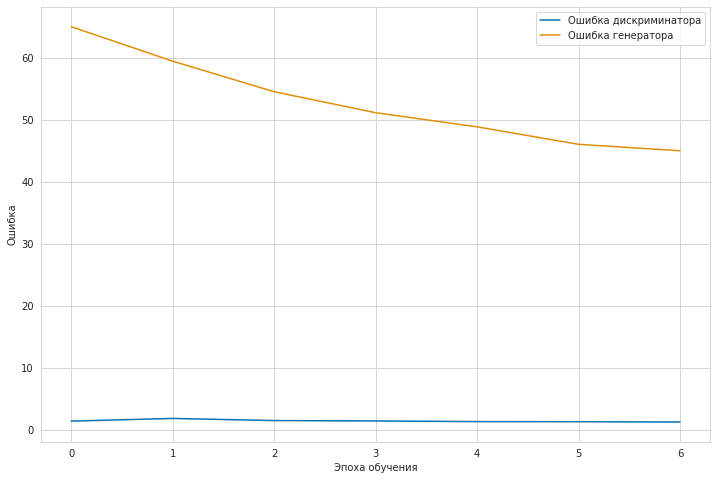

	...epoch 1/300	batch 0/7	D loss: 1.258342	G loss: 44.615658
	...epoch 1/300	batch 1/7	D loss: 1.244539	G loss: 43.875904
	...epoch 1/300	batch 2/7	D loss: 1.175965	G loss: 42.721115
	...epoch 1/300	batch 3/7	D loss: 1.153780	G loss: 41.498295
	...epoch 1/300	batch 4/7	D loss: 1.121183	G loss: 41.403774
	...epoch 1/300	batch 5/7	D loss: 1.081833	G loss: 40.380291
	...epoch 1/300	batch 6/7	D loss: 1.116688	G loss: 42.189816


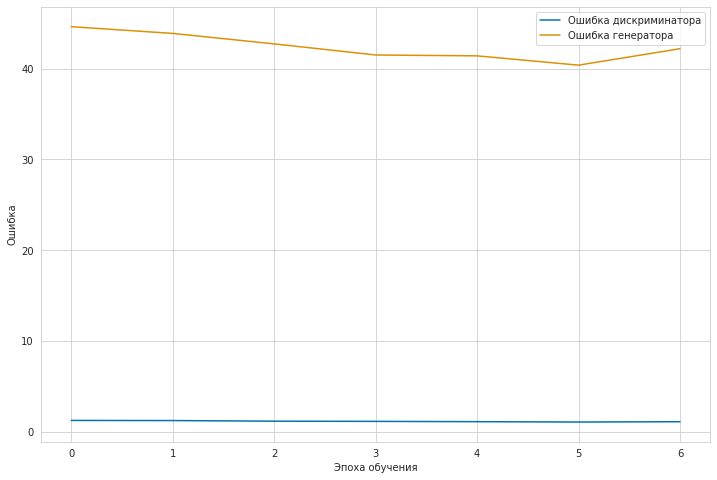

	...epoch 2/300	batch 0/7	D loss: 0.989236	G loss: 41.775970
	...epoch 2/300	batch 1/7	D loss: 0.908782	G loss: 40.246391
	...epoch 2/300	batch 2/7	D loss: 0.986912	G loss: 40.792572
	...epoch 2/300	batch 3/7	D loss: 0.996087	G loss: 39.617630
	...epoch 2/300	batch 4/7	D loss: 0.857877	G loss: 40.650604
	...epoch 2/300	batch 5/7	D loss: 0.862469	G loss: 40.611176
	...epoch 2/300	batch 6/7	D loss: 0.896045	G loss: 40.665749


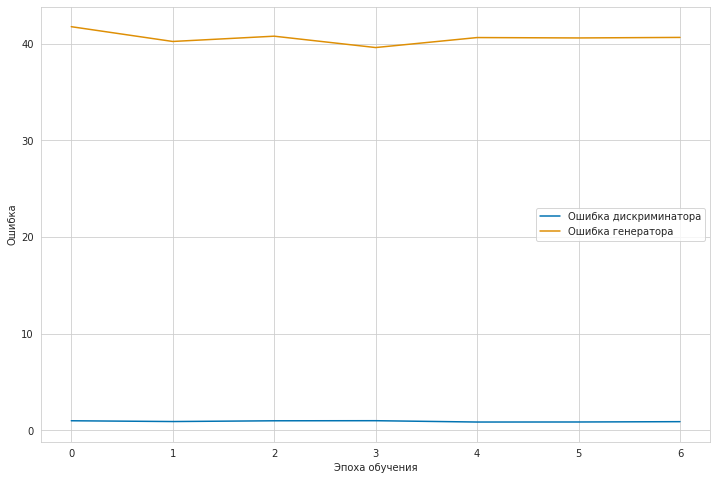

	...epoch 3/300	batch 0/7	D loss: 0.737048	G loss: 41.111523
	...epoch 3/300	batch 1/7	D loss: 0.722697	G loss: 39.712578
	...epoch 3/300	batch 2/7	D loss: 0.761372	G loss: 40.851517
	...epoch 3/300	batch 3/7	D loss: 0.782591	G loss: 38.138435
	...epoch 3/300	batch 4/7	D loss: 0.720067	G loss: 40.019619
	...epoch 3/300	batch 5/7	D loss: 0.592822	G loss: 40.307148
	...epoch 3/300	batch 6/7	D loss: 0.574092	G loss: 39.456005


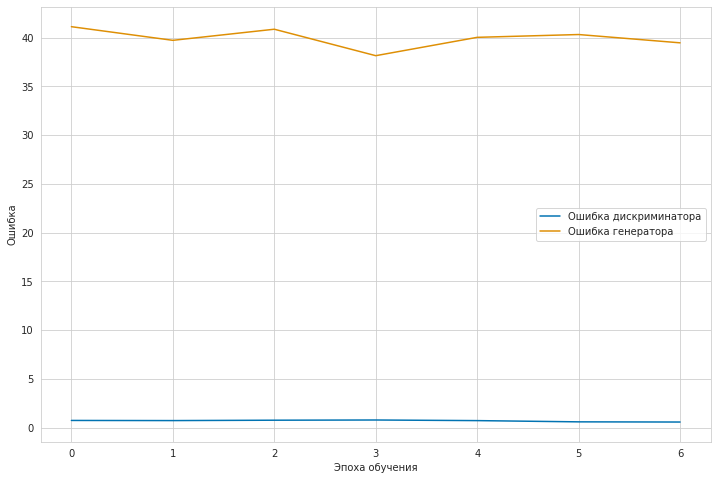

	...epoch 4/300	batch 0/7	D loss: 0.527564	G loss: 38.401249
	...epoch 4/300	batch 1/7	D loss: 0.487674	G loss: 39.740574
	...epoch 4/300	batch 2/7	D loss: 0.494182	G loss: 40.427284
	...epoch 4/300	batch 3/7	D loss: 0.531673	G loss: 37.662109
	...epoch 4/300	batch 4/7	D loss: 0.580817	G loss: 38.238190
	...epoch 4/300	batch 5/7	D loss: 0.642252	G loss: 40.001942
	...epoch 4/300	batch 6/7	D loss: 1.114501	G loss: 42.984730


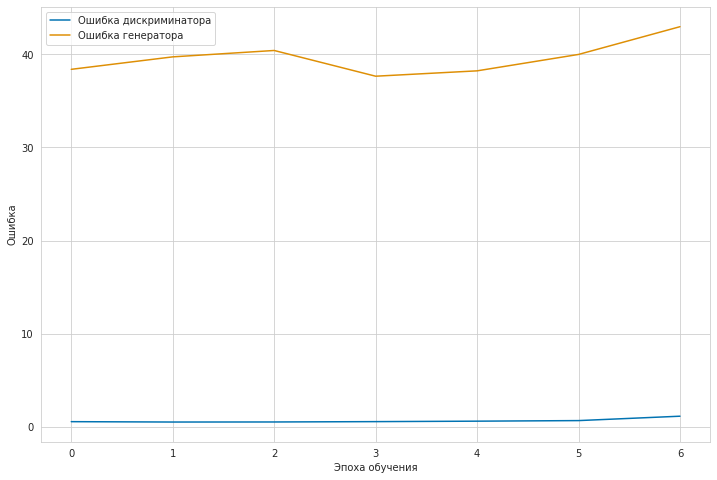

	...epoch 5/300	batch 0/7	D loss: 1.117942	G loss: 39.314873
	...epoch 5/300	batch 1/7	D loss: 0.982220	G loss: 39.841984
	...epoch 5/300	batch 2/7	D loss: 0.984208	G loss: 38.685589
	...epoch 5/300	batch 3/7	D loss: 0.802450	G loss: 36.809631
	...epoch 5/300	batch 4/7	D loss: 0.804017	G loss: 38.178539
	...epoch 5/300	batch 5/7	D loss: 0.688882	G loss: 39.324421
	...epoch 5/300	batch 6/7	D loss: 0.859475	G loss: 36.413017


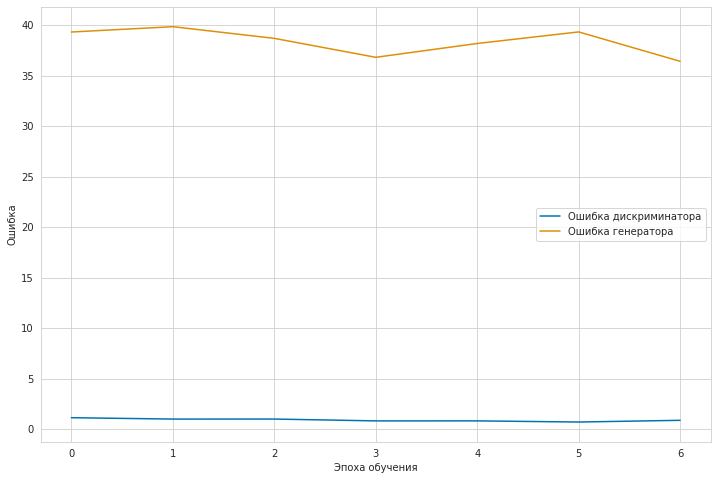

	...epoch 6/300	batch 0/7	D loss: 0.924711	G loss: 37.591831
	...epoch 6/300	batch 1/7	D loss: 1.085139	G loss: 41.975372
	...epoch 6/300	batch 2/7	D loss: 1.006004	G loss: 37.522770
	...epoch 6/300	batch 3/7	D loss: 0.601862	G loss: 37.535812
	...epoch 6/300	batch 4/7	D loss: 0.606729	G loss: 37.469845
	...epoch 6/300	batch 5/7	D loss: 0.515788	G loss: 38.119465
	...epoch 6/300	batch 6/7	D loss: 0.470489	G loss: 36.443813


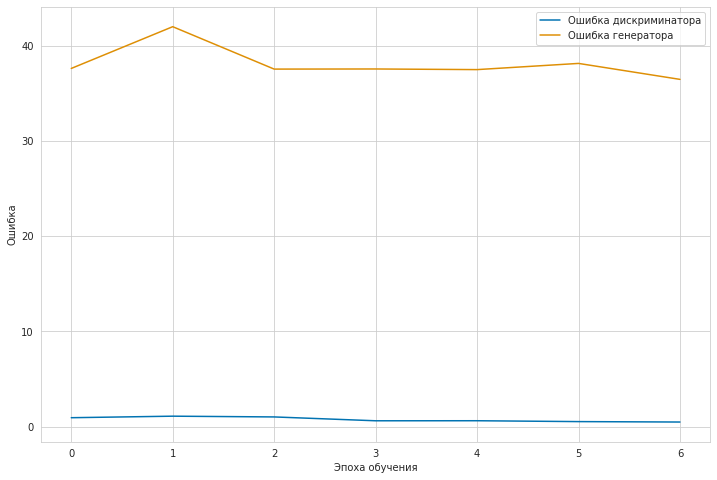

	...epoch 7/300	batch 0/7	D loss: 0.470083	G loss: 37.295761
	...epoch 7/300	batch 1/7	D loss: 0.599108	G loss: 39.215736
	...epoch 7/300	batch 2/7	D loss: 0.615966	G loss: 36.274113
	...epoch 7/300	batch 3/7	D loss: 0.530062	G loss: 38.382835
	...epoch 7/300	batch 4/7	D loss: 0.637597	G loss: 38.120270
	...epoch 7/300	batch 5/7	D loss: 0.780310	G loss: 38.519283
	...epoch 7/300	batch 6/7	D loss: 1.322603	G loss: 39.659378


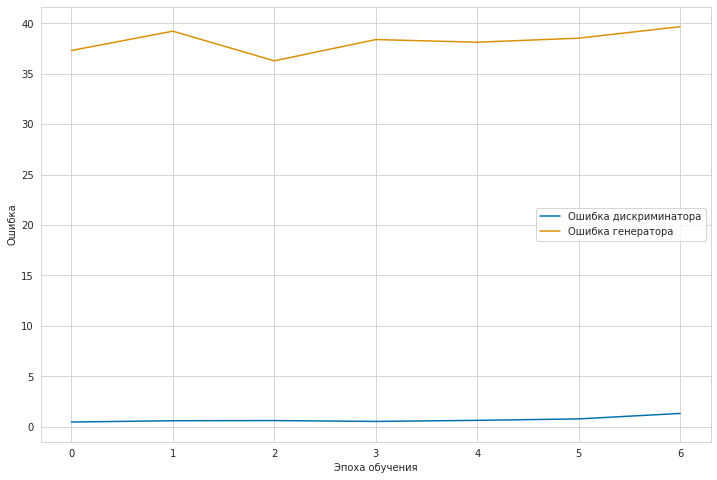

	...epoch 8/300	batch 0/7	D loss: 0.985981	G loss: 38.896412
	...epoch 8/300	batch 1/7	D loss: 0.721428	G loss: 38.474876
	...epoch 8/300	batch 2/7	D loss: 0.725448	G loss: 38.157356
	...epoch 8/300	batch 3/7	D loss: 0.534220	G loss: 37.059357
	...epoch 8/300	batch 4/7	D loss: 0.470472	G loss: 36.416355
	...epoch 8/300	batch 5/7	D loss: 0.467103	G loss: 37.531826
	...epoch 8/300	batch 6/7	D loss: 0.432190	G loss: 39.939800


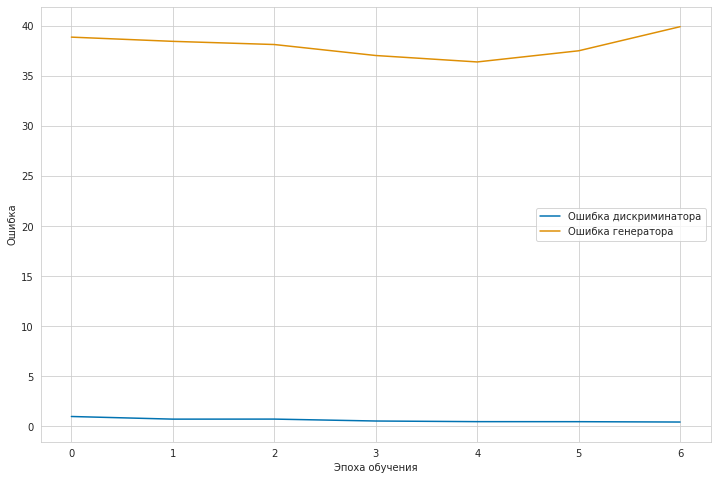

	...epoch 9/300	batch 0/7	D loss: 0.458998	G loss: 40.858112
	...epoch 9/300	batch 1/7	D loss: 0.400439	G loss: 37.598717
	...epoch 9/300	batch 2/7	D loss: 0.343149	G loss: 39.207233
	...epoch 9/300	batch 3/7	D loss: 0.483877	G loss: 38.606594
	...epoch 9/300	batch 4/7	D loss: 0.542432	G loss: 38.438499
	...epoch 9/300	batch 5/7	D loss: 1.161228	G loss: 38.341969
	...epoch 9/300	batch 6/7	D loss: 1.745632	G loss: 37.432167


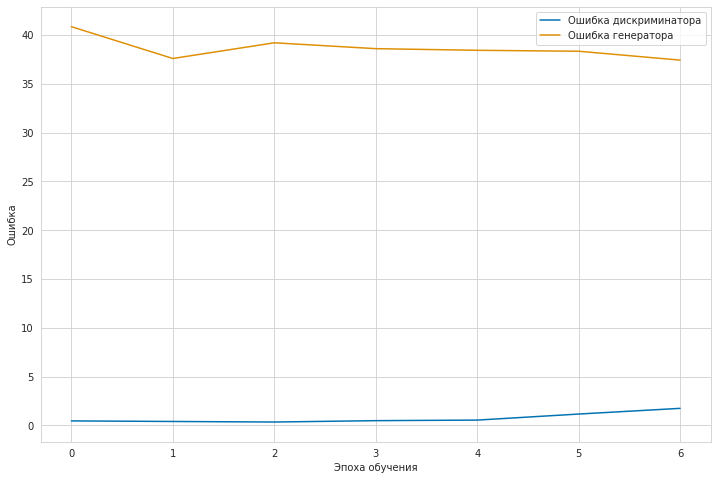

	...epoch 10/300	batch 0/7	D loss: 1.484969	G loss: 37.096642
	...epoch 10/300	batch 1/7	D loss: 1.836447	G loss: 36.165127
	...epoch 10/300	batch 2/7	D loss: 1.072397	G loss: 37.701942
	...epoch 10/300	batch 3/7	D loss: 0.779122	G loss: 37.424580
	...epoch 10/300	batch 4/7	D loss: 0.926465	G loss: 35.254196
	...epoch 10/300	batch 5/7	D loss: 0.709151	G loss: 37.939732
	...epoch 10/300	batch 6/7	D loss: 0.835097	G loss: 36.889076


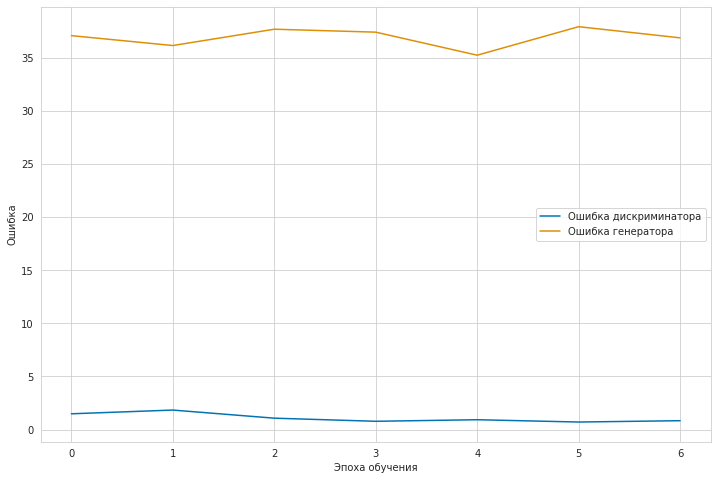

	...epoch 11/300	batch 0/7	D loss: 0.711145	G loss: 36.738071
	...epoch 11/300	batch 1/7	D loss: 0.704784	G loss: 36.535522
	...epoch 11/300	batch 2/7	D loss: 0.714615	G loss: 36.735538
	...epoch 11/300	batch 3/7	D loss: 0.578584	G loss: 37.428734
	...epoch 11/300	batch 4/7	D loss: 0.601778	G loss: 35.924362
	...epoch 11/300	batch 5/7	D loss: 0.652811	G loss: 36.683723
	...epoch 11/300	batch 6/7	D loss: 0.970918	G loss: 38.507912


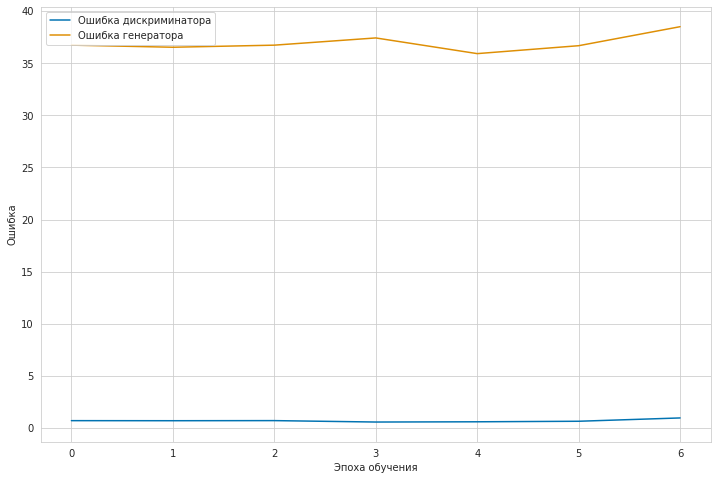

	...epoch 12/300	batch 0/7	D loss: 0.684418	G loss: 36.604214
	...epoch 12/300	batch 1/7	D loss: 0.518513	G loss: 35.814842
	...epoch 12/300	batch 2/7	D loss: 0.585040	G loss: 36.651924
	...epoch 12/300	batch 3/7	D loss: 0.636583	G loss: 35.621140
	...epoch 12/300	batch 4/7	D loss: 0.635138	G loss: 37.175934
	...epoch 12/300	batch 5/7	D loss: 0.542457	G loss: 38.473083
	...epoch 12/300	batch 6/7	D loss: 0.438852	G loss: 39.705898


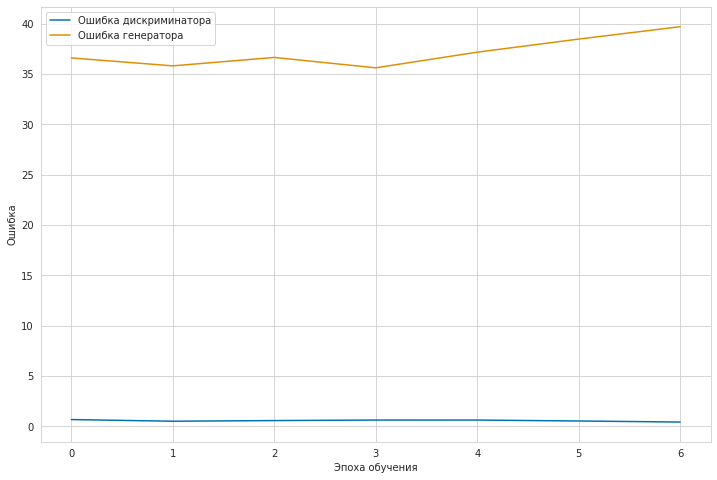

	...epoch 13/300	batch 0/7	D loss: 0.595790	G loss: 37.997826
	...epoch 13/300	batch 1/7	D loss: 0.554781	G loss: 37.334347
	...epoch 13/300	batch 2/7	D loss: 0.605214	G loss: 37.533333
	...epoch 13/300	batch 3/7	D loss: 0.569101	G loss: 35.452862
	...epoch 13/300	batch 4/7	D loss: 0.809834	G loss: 37.245785
	...epoch 13/300	batch 5/7	D loss: 1.043992	G loss: 36.140297
	...epoch 13/300	batch 6/7	D loss: 0.998660	G loss: 36.274906


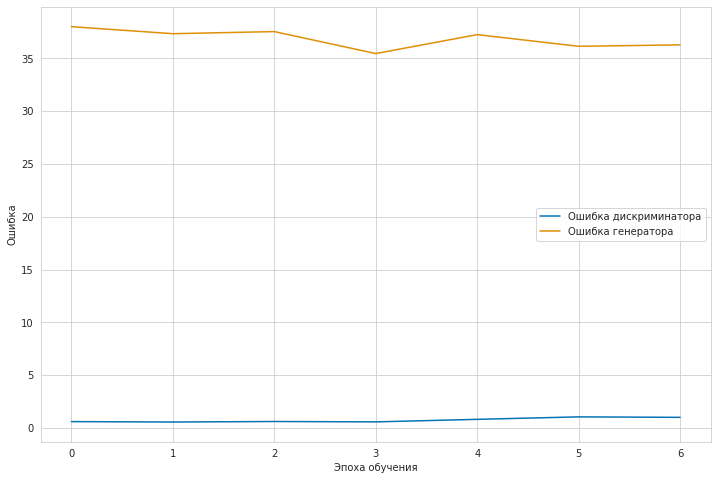

	...epoch 14/300	batch 0/7	D loss: 1.010602	G loss: 38.037640
	...epoch 14/300	batch 1/7	D loss: 1.157504	G loss: 36.962933
	...epoch 14/300	batch 2/7	D loss: 0.636200	G loss: 36.084267
	...epoch 14/300	batch 3/7	D loss: 0.503233	G loss: 37.154873
	...epoch 14/300	batch 4/7	D loss: 0.448413	G loss: 34.465172
	...epoch 14/300	batch 5/7	D loss: 0.426563	G loss: 35.237701
	...epoch 14/300	batch 6/7	D loss: 0.383379	G loss: 43.292023


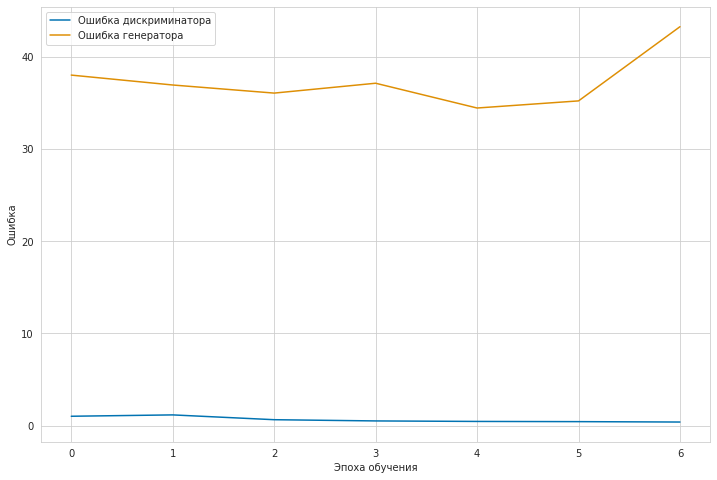

	...epoch 15/300	batch 0/7	D loss: 0.435348	G loss: 37.399517
	...epoch 15/300	batch 1/7	D loss: 0.461120	G loss: 37.772247
	...epoch 15/300	batch 2/7	D loss: 0.470560	G loss: 36.048531
	...epoch 15/300	batch 3/7	D loss: 0.567223	G loss: 39.854534
	...epoch 15/300	batch 4/7	D loss: 0.550121	G loss: 34.882111
	...epoch 15/300	batch 5/7	D loss: 0.660252	G loss: 35.893543
	...epoch 15/300	batch 6/7	D loss: 0.436523	G loss: 37.230930


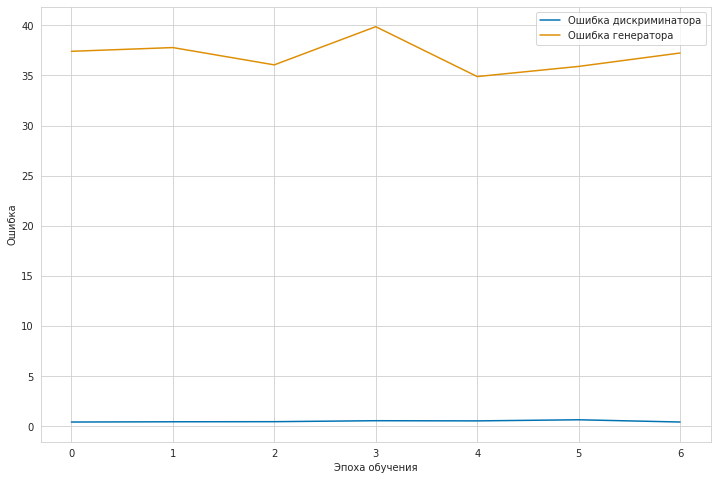

	...epoch 16/300	batch 0/7	D loss: 0.517475	G loss: 35.656384
	...epoch 16/300	batch 1/7	D loss: 0.474327	G loss: 38.101204
	...epoch 16/300	batch 2/7	D loss: 0.654026	G loss: 37.322540
	...epoch 16/300	batch 3/7	D loss: 0.463867	G loss: 35.983505
	...epoch 16/300	batch 4/7	D loss: 0.478415	G loss: 35.092731
	...epoch 16/300	batch 5/7	D loss: 0.549508	G loss: 36.641464
	...epoch 16/300	batch 6/7	D loss: 0.512589	G loss: 37.176590


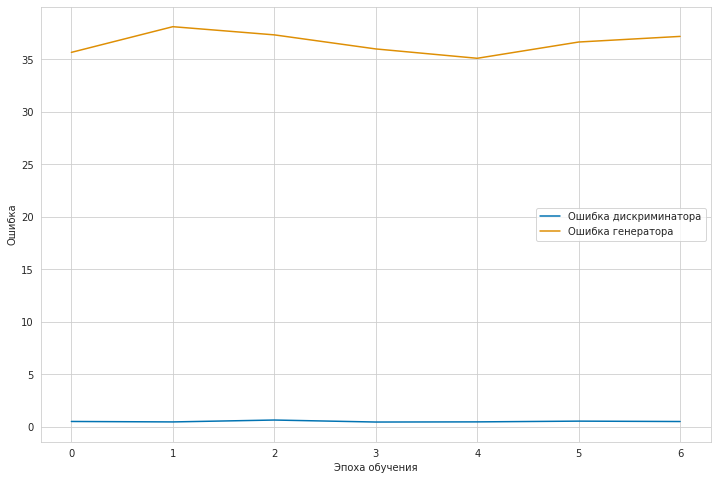

	...epoch 17/300	batch 0/7	D loss: 0.743195	G loss: 37.728191
	...epoch 17/300	batch 1/7	D loss: 0.934850	G loss: 35.263317
	...epoch 17/300	batch 2/7	D loss: 0.807833	G loss: 35.539757
	...epoch 17/300	batch 3/7	D loss: 0.582641	G loss: 36.591999
	...epoch 17/300	batch 4/7	D loss: 0.561888	G loss: 35.852112
	...epoch 17/300	batch 5/7	D loss: 0.386808	G loss: 37.470695
	...epoch 17/300	batch 6/7	D loss: 0.550423	G loss: 35.550476


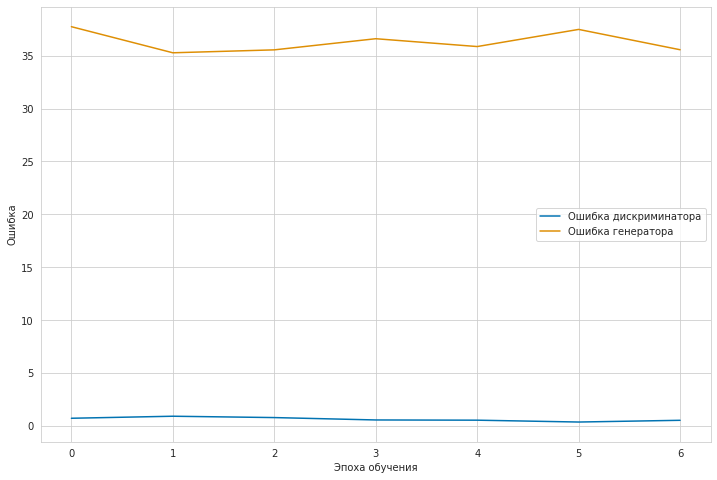

	...epoch 18/300	batch 0/7	D loss: 0.444014	G loss: 36.247089
	...epoch 18/300	batch 1/7	D loss: 0.432140	G loss: 35.848480
	...epoch 18/300	batch 2/7	D loss: 0.451376	G loss: 34.869930
	...epoch 18/300	batch 3/7	D loss: 0.382084	G loss: 37.465927
	...epoch 18/300	batch 4/7	D loss: 0.396020	G loss: 36.925938
	...epoch 18/300	batch 5/7	D loss: 0.345184	G loss: 39.013092
	...epoch 18/300	batch 6/7	D loss: 0.287285	G loss: 37.068920


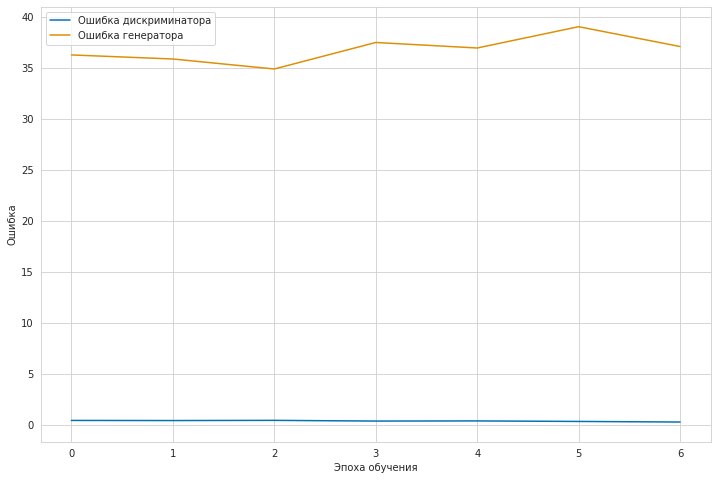

	...epoch 19/300	batch 0/7	D loss: 0.551172	G loss: 39.117615
	...epoch 19/300	batch 1/7	D loss: 0.953597	G loss: 35.771351
	...epoch 19/300	batch 2/7	D loss: 0.779944	G loss: 36.447483
	...epoch 19/300	batch 3/7	D loss: 0.659408	G loss: 36.417446
	...epoch 19/300	batch 4/7	D loss: 0.664934	G loss: 36.185894
	...epoch 19/300	batch 5/7	D loss: 0.570900	G loss: 34.256332
	...epoch 19/300	batch 6/7	D loss: 0.410000	G loss: 34.767357


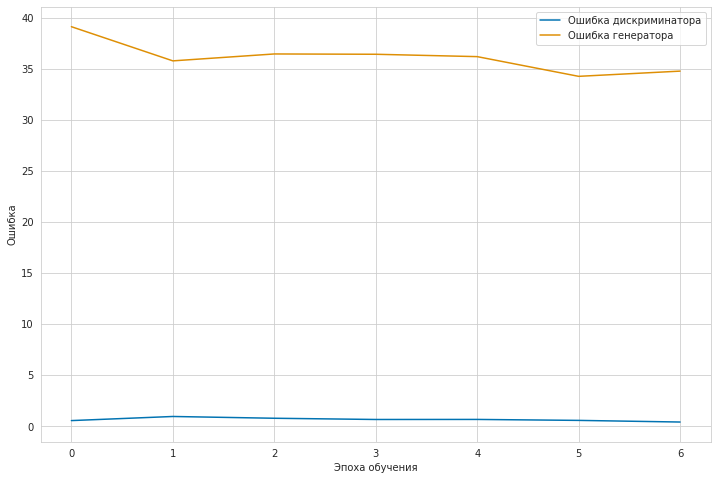

	...epoch 20/300	batch 0/7	D loss: 0.406559	G loss: 35.519318
	...epoch 20/300	batch 1/7	D loss: 0.382773	G loss: 35.453327
	...epoch 20/300	batch 2/7	D loss: 0.344978	G loss: 35.444031
	...epoch 20/300	batch 3/7	D loss: 0.415137	G loss: 37.082378
	...epoch 20/300	batch 4/7	D loss: 0.674418	G loss: 34.387512
	...epoch 20/300	batch 5/7	D loss: 0.891893	G loss: 36.849876
	...epoch 20/300	batch 6/7	D loss: 0.903457	G loss: 34.923885


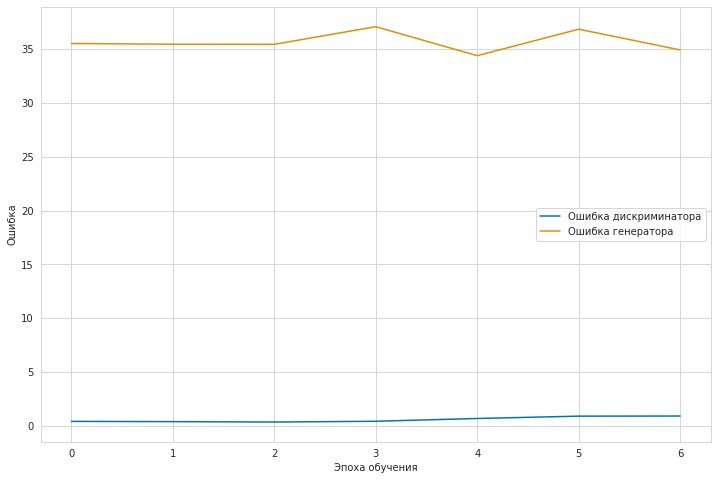

	...epoch 21/300	batch 0/7	D loss: 0.732822	G loss: 36.242714
	...epoch 21/300	batch 1/7	D loss: 0.546427	G loss: 33.711327
	...epoch 21/300	batch 2/7	D loss: 0.444318	G loss: 35.021915
	...epoch 21/300	batch 3/7	D loss: 0.324709	G loss: 34.372185
	...epoch 21/300	batch 4/7	D loss: 0.439083	G loss: 36.487415
	...epoch 21/300	batch 5/7	D loss: 0.400818	G loss: 36.071663
	...epoch 21/300	batch 6/7	D loss: 0.430581	G loss: 36.331791


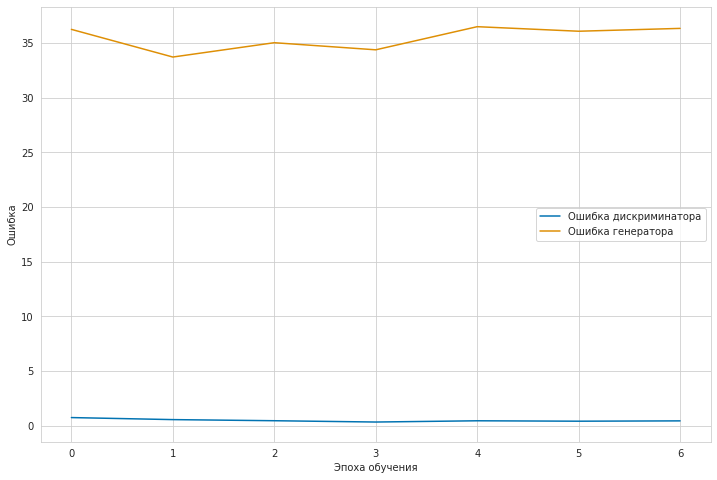

	...epoch 22/300	batch 0/7	D loss: 0.549549	G loss: 36.171169
	...epoch 22/300	batch 1/7	D loss: 0.597688	G loss: 35.733910
	...epoch 22/300	batch 2/7	D loss: 1.064886	G loss: 35.257568
	...epoch 22/300	batch 3/7	D loss: 1.048839	G loss: 33.484596
	...epoch 22/300	batch 4/7	D loss: 0.791560	G loss: 34.800941
	...epoch 22/300	batch 5/7	D loss: 0.399000	G loss: 35.484856
	...epoch 22/300	batch 6/7	D loss: 0.477625	G loss: 35.796581


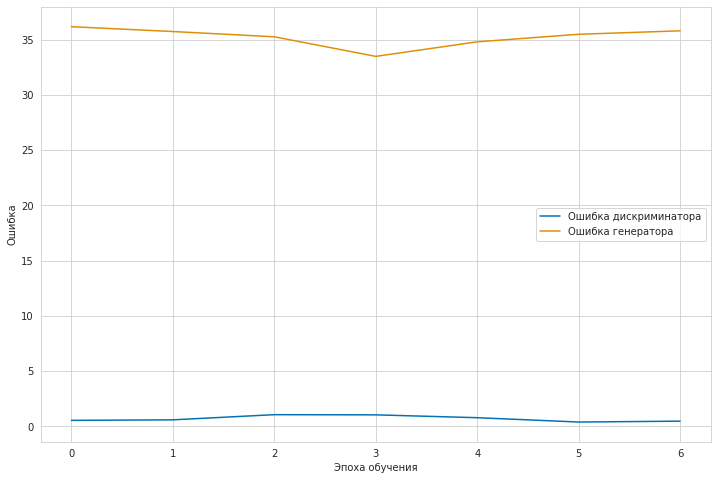

	...epoch 23/300	batch 0/7	D loss: 0.725686	G loss: 36.429668
	...epoch 23/300	batch 1/7	D loss: 0.811130	G loss: 34.329826
	...epoch 23/300	batch 2/7	D loss: 0.683333	G loss: 35.317841
	...epoch 23/300	batch 3/7	D loss: 0.589741	G loss: 34.953583
	...epoch 23/300	batch 4/7	D loss: 0.398755	G loss: 35.226585
	...epoch 23/300	batch 5/7	D loss: 0.416161	G loss: 34.996422
	...epoch 23/300	batch 6/7	D loss: 0.363527	G loss: 34.446503


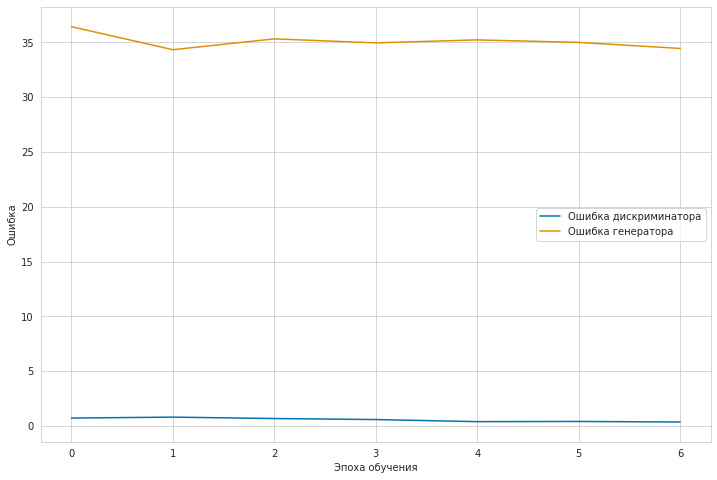

	...epoch 24/300	batch 0/7	D loss: 0.509776	G loss: 34.641460
	...epoch 24/300	batch 1/7	D loss: 0.362460	G loss: 33.660236
	...epoch 24/300	batch 2/7	D loss: 0.337871	G loss: 34.729576
	...epoch 24/300	batch 3/7	D loss: 0.310922	G loss: 33.972290
	...epoch 24/300	batch 4/7	D loss: 0.561333	G loss: 36.037888
	...epoch 24/300	batch 5/7	D loss: 0.661561	G loss: 34.137119
	...epoch 24/300	batch 6/7	D loss: 0.652176	G loss: 36.665920


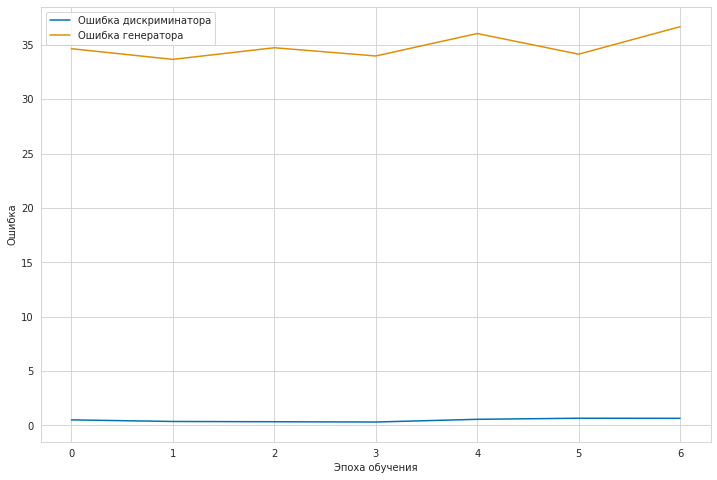

	...epoch 25/300	batch 0/7	D loss: 0.779314	G loss: 34.439114
	...epoch 25/300	batch 1/7	D loss: 0.450729	G loss: 34.806709
	...epoch 25/300	batch 2/7	D loss: 0.467102	G loss: 36.386120
	...epoch 25/300	batch 3/7	D loss: 0.505417	G loss: 34.916740
	...epoch 25/300	batch 4/7	D loss: 0.427817	G loss: 33.911568
	...epoch 25/300	batch 5/7	D loss: 0.445831	G loss: 34.178978
	...epoch 25/300	batch 6/7	D loss: 0.502648	G loss: 34.556950


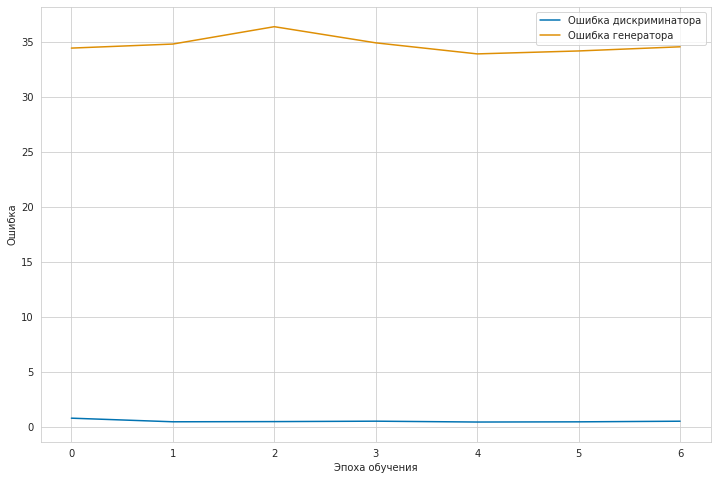

	...epoch 26/300	batch 0/7	D loss: 0.759310	G loss: 35.781544
	...epoch 26/300	batch 1/7	D loss: 0.970230	G loss: 31.376228
	...epoch 26/300	batch 2/7	D loss: 0.992187	G loss: 34.439827
	...epoch 26/300	batch 3/7	D loss: 0.615035	G loss: 30.597372
	...epoch 26/300	batch 4/7	D loss: 0.610105	G loss: 33.404636
	...epoch 26/300	batch 5/7	D loss: 0.513259	G loss: 32.910286
	...epoch 26/300	batch 6/7	D loss: 0.639476	G loss: 35.537601


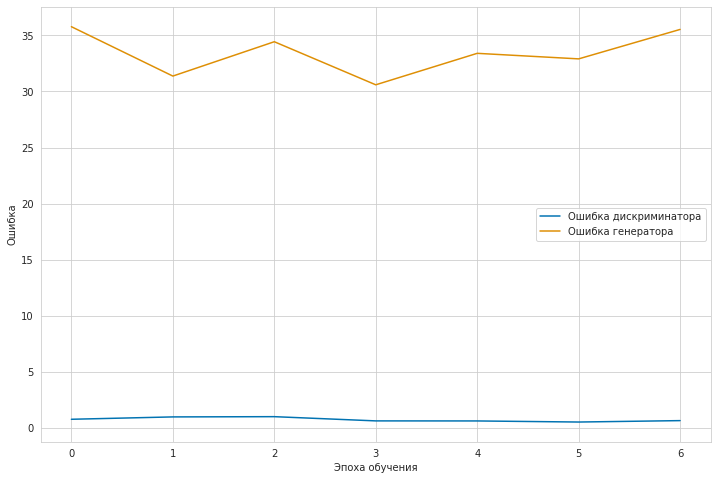

	...epoch 27/300	batch 0/7	D loss: 0.830946	G loss: 32.791656
	...epoch 27/300	batch 1/7	D loss: 0.647814	G loss: 33.847366
	...epoch 27/300	batch 2/7	D loss: 0.589738	G loss: 31.438051
	...epoch 27/300	batch 3/7	D loss: 0.804575	G loss: 33.571510
	...epoch 27/300	batch 4/7	D loss: 0.766044	G loss: 32.772427
	...epoch 27/300	batch 5/7	D loss: 0.530049	G loss: 32.053024
	...epoch 27/300	batch 6/7	D loss: 0.661987	G loss: 34.035805


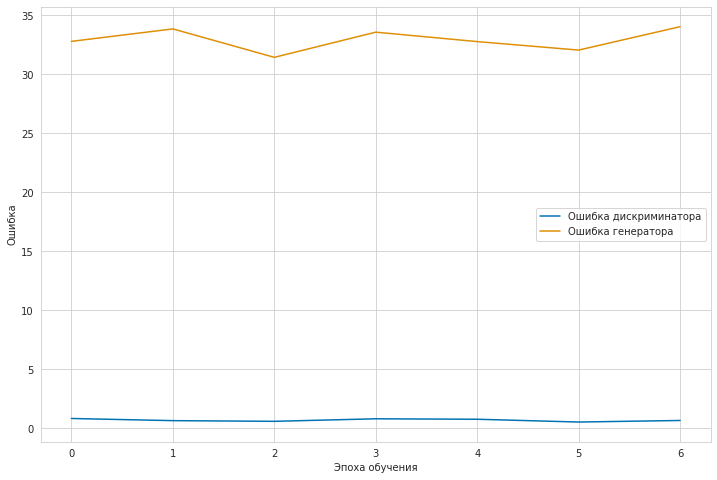

	...epoch 28/300	batch 0/7	D loss: 1.156799	G loss: 30.675694
	...epoch 28/300	batch 1/7	D loss: 0.596968	G loss: 32.582935
	...epoch 28/300	batch 2/7	D loss: 0.379495	G loss: 31.971712
	...epoch 28/300	batch 3/7	D loss: 0.517505	G loss: 31.845051
	...epoch 28/300	batch 4/7	D loss: 0.583306	G loss: 30.508419
	...epoch 28/300	batch 5/7	D loss: 0.849362	G loss: 33.084187
	...epoch 28/300	batch 6/7	D loss: 0.543837	G loss: 36.165791


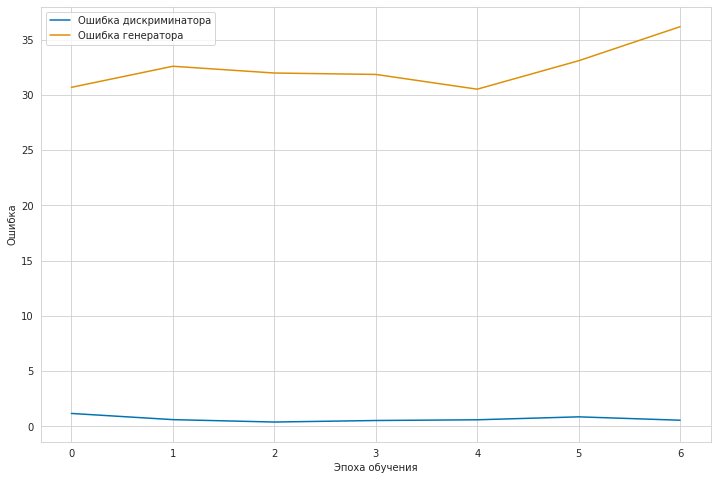

	...epoch 29/300	batch 0/7	D loss: 0.746380	G loss: 31.590487
	...epoch 29/300	batch 1/7	D loss: 0.830471	G loss: 33.176907
	...epoch 29/300	batch 2/7	D loss: 1.075596	G loss: 31.289835
	...epoch 29/300	batch 3/7	D loss: 1.147683	G loss: 31.227379
	...epoch 29/300	batch 4/7	D loss: 0.794640	G loss: 31.459051
	...epoch 29/300	batch 5/7	D loss: 0.992997	G loss: 30.849928
	...epoch 29/300	batch 6/7	D loss: 0.879137	G loss: 31.623394


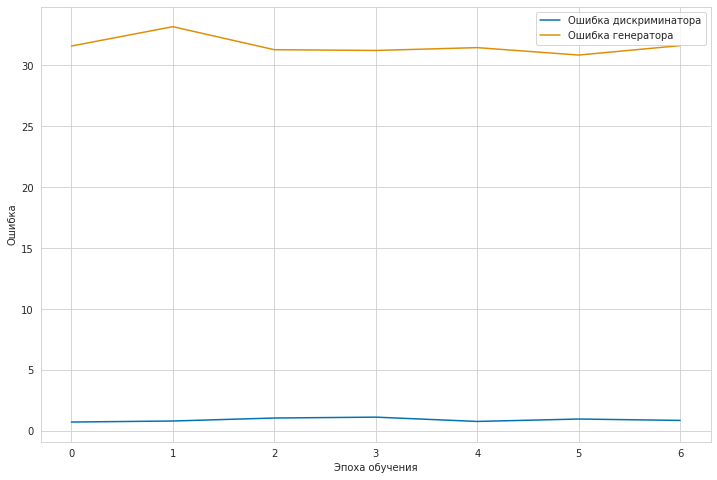

	...epoch 30/300	batch 0/7	D loss: 0.948342	G loss: 31.241776
	...epoch 30/300	batch 1/7	D loss: 0.531486	G loss: 31.158222
	...epoch 30/300	batch 2/7	D loss: 0.787785	G loss: 33.613754
	...epoch 30/300	batch 3/7	D loss: 1.028529	G loss: 30.627647
	...epoch 30/300	batch 4/7	D loss: 0.944064	G loss: 31.384974
	...epoch 30/300	batch 5/7	D loss: 0.535155	G loss: 31.479404
	...epoch 30/300	batch 6/7	D loss: 0.455828	G loss: 31.635477


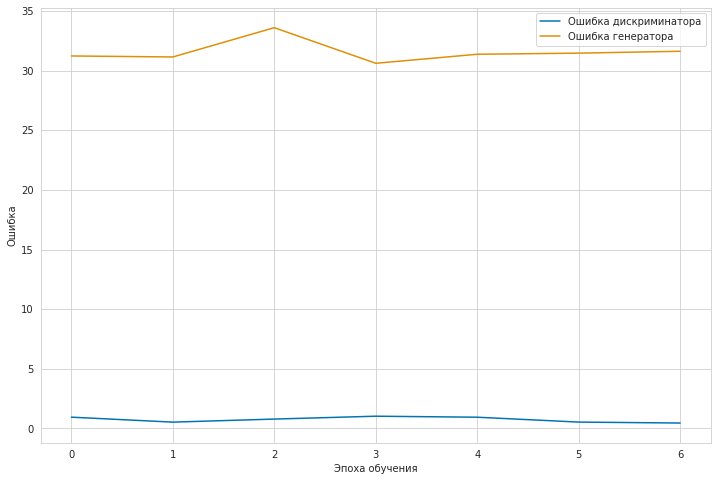

	...epoch 31/300	batch 0/7	D loss: 0.819528	G loss: 33.349609
	...epoch 31/300	batch 1/7	D loss: 0.971744	G loss: 30.129820
	...epoch 31/300	batch 2/7	D loss: 0.660535	G loss: 30.191532
	...epoch 31/300	batch 3/7	D loss: 0.552166	G loss: 30.490894
	...epoch 31/300	batch 4/7	D loss: 0.454597	G loss: 30.372528
	...epoch 31/300	batch 5/7	D loss: 0.551104	G loss: 29.575304
	...epoch 31/300	batch 6/7	D loss: 1.128972	G loss: 32.437405


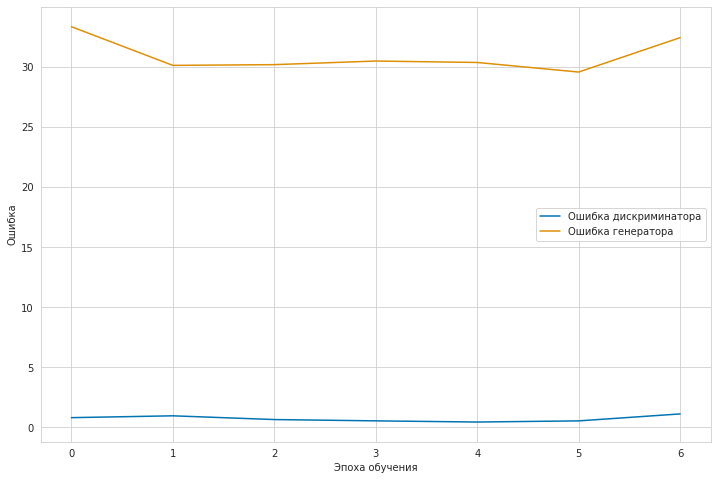

	...epoch 32/300	batch 0/7	D loss: 1.528184	G loss: 29.164494
	...epoch 32/300	batch 1/7	D loss: 0.614674	G loss: 31.488749
	...epoch 32/300	batch 2/7	D loss: 0.484992	G loss: 30.406876
	...epoch 32/300	batch 3/7	D loss: 0.573761	G loss: 30.934240
	...epoch 32/300	batch 4/7	D loss: 0.462628	G loss: 30.571119
	...epoch 32/300	batch 5/7	D loss: 0.512794	G loss: 28.628754
	...epoch 32/300	batch 6/7	D loss: 0.955971	G loss: 29.782177


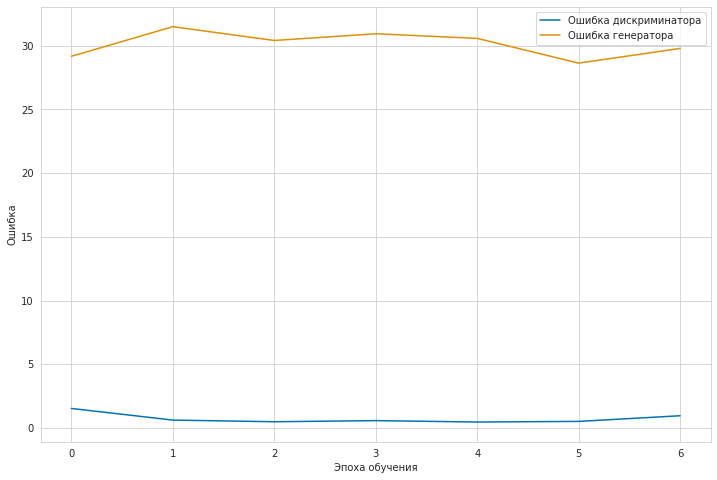

	...epoch 33/300	batch 0/7	D loss: 1.448551	G loss: 28.998220
	...epoch 33/300	batch 1/7	D loss: 0.672335	G loss: 28.631676
	...epoch 33/300	batch 2/7	D loss: 0.585519	G loss: 30.254353
	...epoch 33/300	batch 3/7	D loss: 0.522337	G loss: 29.096628
	...epoch 33/300	batch 4/7	D loss: 0.599393	G loss: 28.753643
	...epoch 33/300	batch 5/7	D loss: 0.381129	G loss: 28.609339
	...epoch 33/300	batch 6/7	D loss: 0.583381	G loss: 31.876011


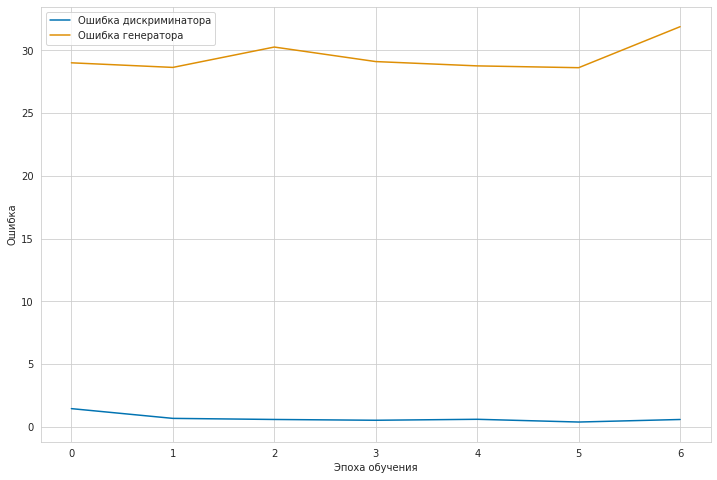

	...epoch 34/300	batch 0/7	D loss: 0.971068	G loss: 28.215467
	...epoch 34/300	batch 1/7	D loss: 0.772967	G loss: 30.185339
	...epoch 34/300	batch 2/7	D loss: 0.547324	G loss: 29.587658
	...epoch 34/300	batch 3/7	D loss: 0.691682	G loss: 27.753384
	...epoch 34/300	batch 4/7	D loss: 0.601874	G loss: 28.406260
	...epoch 34/300	batch 5/7	D loss: 0.491146	G loss: 28.518789
	...epoch 34/300	batch 6/7	D loss: 0.710023	G loss: 31.832577


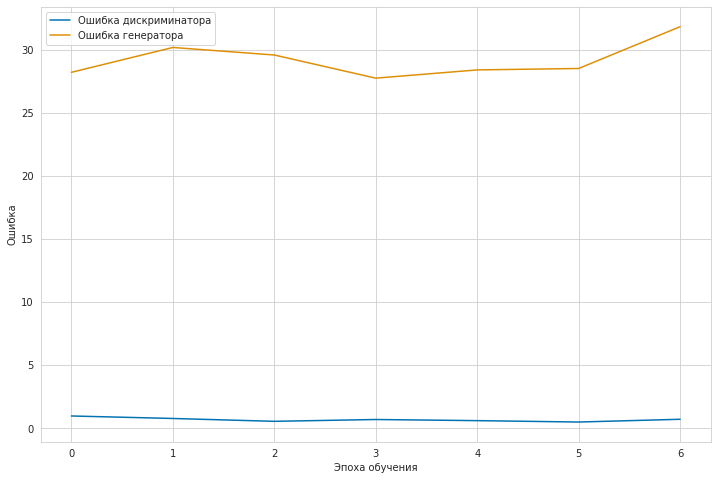

	...epoch 35/300	batch 0/7	D loss: 1.547706	G loss: 28.611412
	...epoch 35/300	batch 1/7	D loss: 0.601945	G loss: 28.475584
	...epoch 35/300	batch 2/7	D loss: 0.574311	G loss: 29.260445
	...epoch 35/300	batch 3/7	D loss: 0.689379	G loss: 28.622009
	...epoch 35/300	batch 4/7	D loss: 0.662296	G loss: 26.686653
	...epoch 35/300	batch 5/7	D loss: 0.893363	G loss: 29.539991
	...epoch 35/300	batch 6/7	D loss: 1.256560	G loss: 26.830927


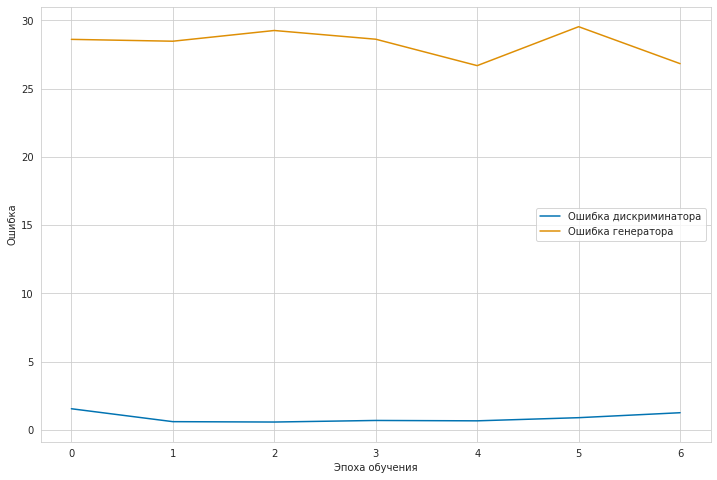

	...epoch 36/300	batch 0/7	D loss: 0.509794	G loss: 28.314287
	...epoch 36/300	batch 1/7	D loss: 0.687765	G loss: 28.172749
	...epoch 36/300	batch 2/7	D loss: 0.609316	G loss: 26.386038
	...epoch 36/300	batch 3/7	D loss: 0.562241	G loss: 28.062832
	...epoch 36/300	batch 4/7	D loss: 0.512689	G loss: 27.406237
	...epoch 36/300	batch 5/7	D loss: 0.596790	G loss: 28.793852
	...epoch 36/300	batch 6/7	D loss: 0.721702	G loss: 28.987597


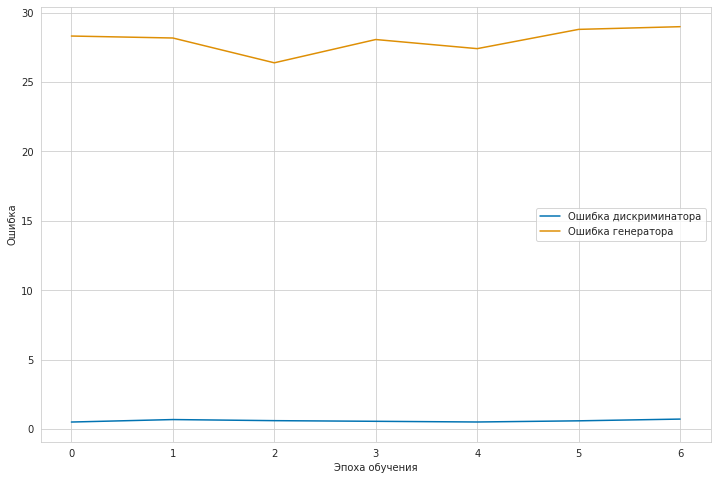

	...epoch 37/300	batch 0/7	D loss: 0.836665	G loss: 27.280201
	...epoch 37/300	batch 1/7	D loss: 0.671229	G loss: 27.917992
	...epoch 37/300	batch 2/7	D loss: 0.623440	G loss: 27.298042
	...epoch 37/300	batch 3/7	D loss: 0.820075	G loss: 27.460728
	...epoch 37/300	batch 4/7	D loss: 0.506927	G loss: 27.909172
	...epoch 37/300	batch 5/7	D loss: 0.509124	G loss: 28.270994
	...epoch 37/300	batch 6/7	D loss: 0.904572	G loss: 25.995810


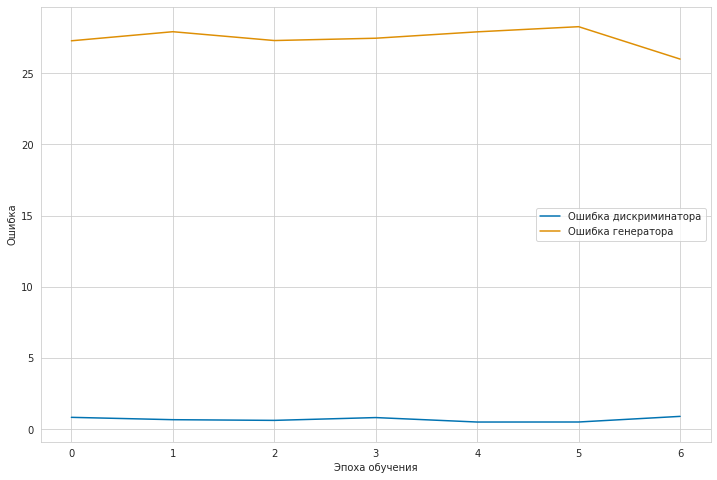

	...epoch 38/300	batch 0/7	D loss: 0.864658	G loss: 30.334295
	...epoch 38/300	batch 1/7	D loss: 2.123972	G loss: 26.728882
	...epoch 38/300	batch 2/7	D loss: 0.628612	G loss: 25.447765
	...epoch 38/300	batch 3/7	D loss: 1.134804	G loss: 27.144194
	...epoch 38/300	batch 4/7	D loss: 0.663836	G loss: 26.092333
	...epoch 38/300	batch 5/7	D loss: 0.948928	G loss: 28.780426
	...epoch 38/300	batch 6/7	D loss: 1.147142	G loss: 26.422792


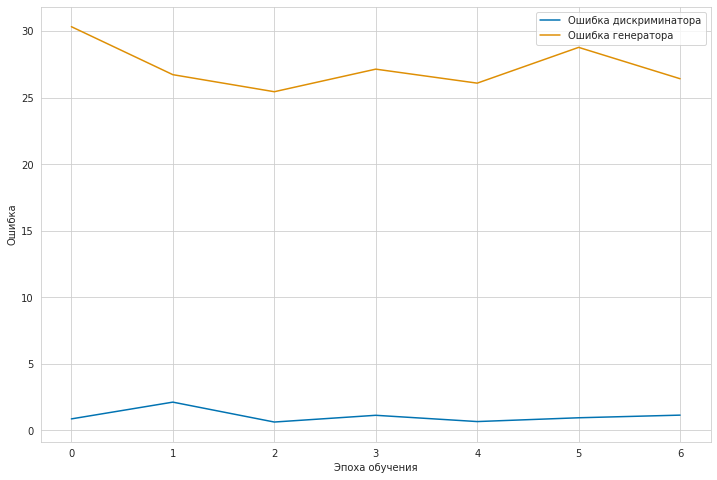

	...epoch 39/300	batch 0/7	D loss: 0.935442	G loss: 26.347374
	...epoch 39/300	batch 1/7	D loss: 0.707298	G loss: 25.322739
	...epoch 39/300	batch 2/7	D loss: 0.799793	G loss: 25.915026
	...epoch 39/300	batch 3/7	D loss: 0.557189	G loss: 26.250887
	...epoch 39/300	batch 4/7	D loss: 0.598664	G loss: 26.642673
	...epoch 39/300	batch 5/7	D loss: 0.545170	G loss: 26.288706
	...epoch 39/300	batch 6/7	D loss: 0.632876	G loss: 27.296543


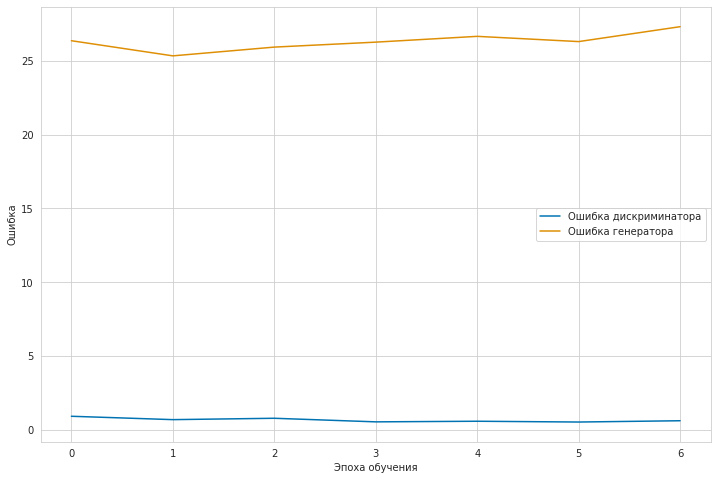

	...epoch 40/300	batch 0/7	D loss: 0.704972	G loss: 26.034050
	...epoch 40/300	batch 1/7	D loss: 0.750528	G loss: 26.251112
	...epoch 40/300	batch 2/7	D loss: 0.800135	G loss: 25.314718
	...epoch 40/300	batch 3/7	D loss: 0.751635	G loss: 27.556568
	...epoch 40/300	batch 4/7	D loss: 1.622894	G loss: 24.680143
	...epoch 40/300	batch 5/7	D loss: 0.436880	G loss: 27.559465
	...epoch 40/300	batch 6/7	D loss: 0.729051	G loss: 28.422110


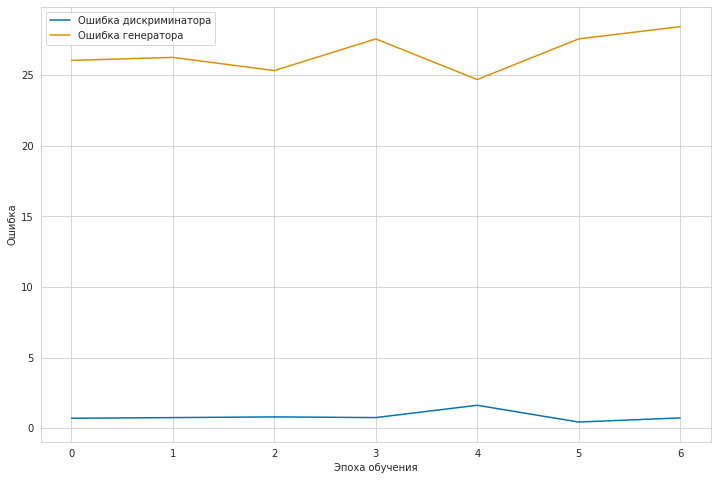

	...epoch 41/300	batch 0/7	D loss: 1.483222	G loss: 25.314369
	...epoch 41/300	batch 1/7	D loss: 0.714765	G loss: 25.650339
	...epoch 41/300	batch 2/7	D loss: 0.588855	G loss: 26.244324
	...epoch 41/300	batch 3/7	D loss: 0.701347	G loss: 25.699451
	...epoch 41/300	batch 4/7	D loss: 0.880915	G loss: 25.894653
	...epoch 41/300	batch 5/7	D loss: 0.799272	G loss: 24.858503
	...epoch 41/300	batch 6/7	D loss: 0.709351	G loss: 26.381653


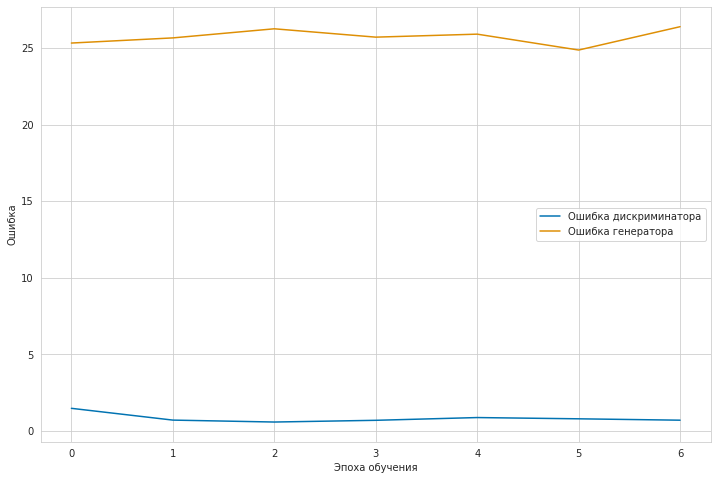

	...epoch 42/300	batch 0/7	D loss: 0.800058	G loss: 24.542788
	...epoch 42/300	batch 1/7	D loss: 0.869776	G loss: 26.443378
	...epoch 42/300	batch 2/7	D loss: 0.851908	G loss: 25.406719
	...epoch 42/300	batch 3/7	D loss: 0.823092	G loss: 23.896692
	...epoch 42/300	batch 4/7	D loss: 0.655057	G loss: 25.176298
	...epoch 42/300	batch 5/7	D loss: 0.530300	G loss: 25.068178
	...epoch 42/300	batch 6/7	D loss: 0.999805	G loss: 24.441957


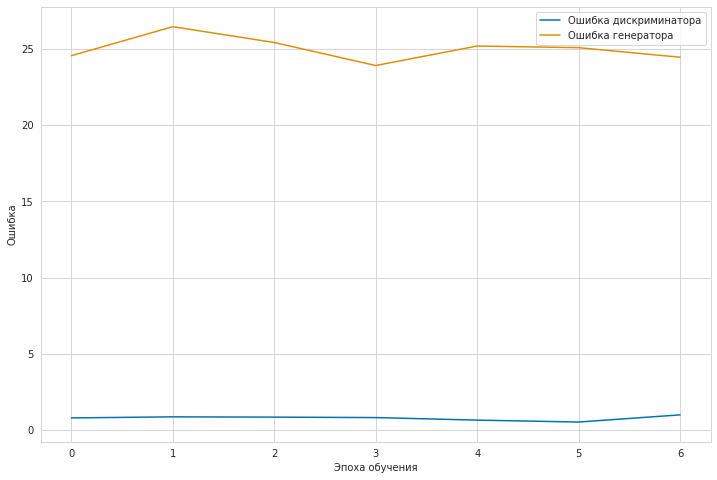

	...epoch 43/300	batch 0/7	D loss: 1.075376	G loss: 27.080858
	...epoch 43/300	batch 1/7	D loss: 2.540184	G loss: 24.938688
	...epoch 43/300	batch 2/7	D loss: 0.881268	G loss: 23.351488
	...epoch 43/300	batch 3/7	D loss: 0.875292	G loss: 23.931196
	...epoch 43/300	batch 4/7	D loss: 0.688946	G loss: 22.939716
	...epoch 43/300	batch 5/7	D loss: 0.532282	G loss: 23.379831
	...epoch 43/300	batch 6/7	D loss: 0.601303	G loss: 26.218264


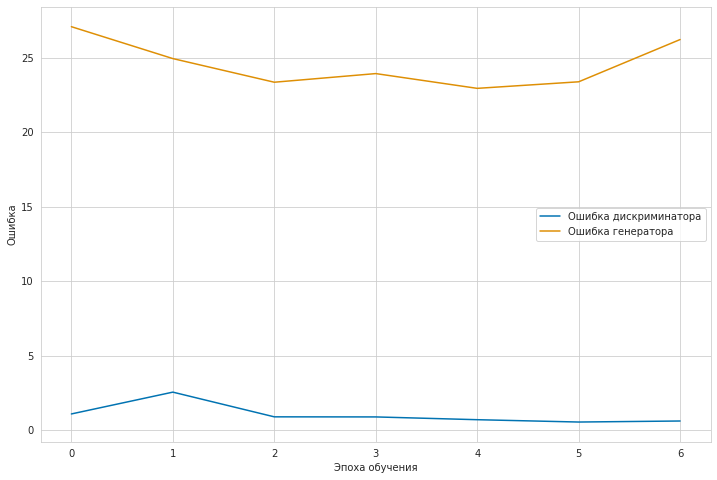

	...epoch 44/300	batch 0/7	D loss: 1.097102	G loss: 23.205004
	...epoch 44/300	batch 1/7	D loss: 0.460342	G loss: 24.834324
	...epoch 44/300	batch 2/7	D loss: 0.748083	G loss: 25.488146
	...epoch 44/300	batch 3/7	D loss: 0.933133	G loss: 22.728685
	...epoch 44/300	batch 4/7	D loss: 0.535166	G loss: 24.597834
	...epoch 44/300	batch 5/7	D loss: 0.612227	G loss: 23.222992
	...epoch 44/300	batch 6/7	D loss: 0.640046	G loss: 24.576363


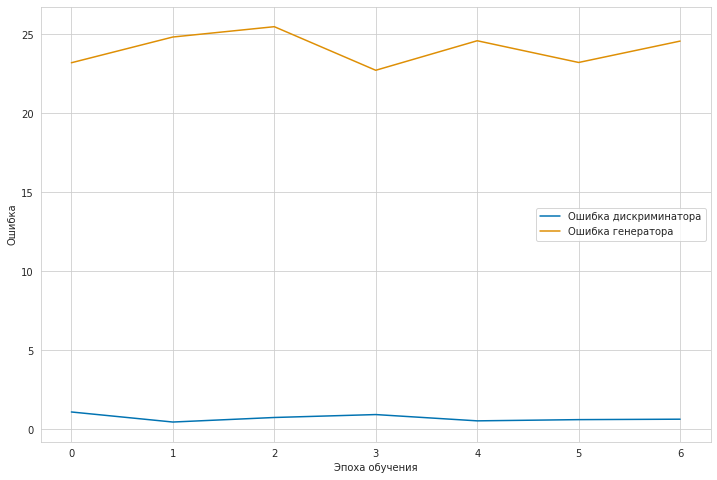

	...epoch 45/300	batch 0/7	D loss: 0.957702	G loss: 24.810099
	...epoch 45/300	batch 1/7	D loss: 0.690705	G loss: 25.194750
	...epoch 45/300	batch 2/7	D loss: 0.954897	G loss: 23.517572
	...epoch 45/300	batch 3/7	D loss: 1.052457	G loss: 25.295570
	...epoch 45/300	batch 4/7	D loss: 1.136913	G loss: 22.593712
	...epoch 45/300	batch 5/7	D loss: 0.701634	G loss: 24.133224
	...epoch 45/300	batch 6/7	D loss: 0.834748	G loss: 24.752869


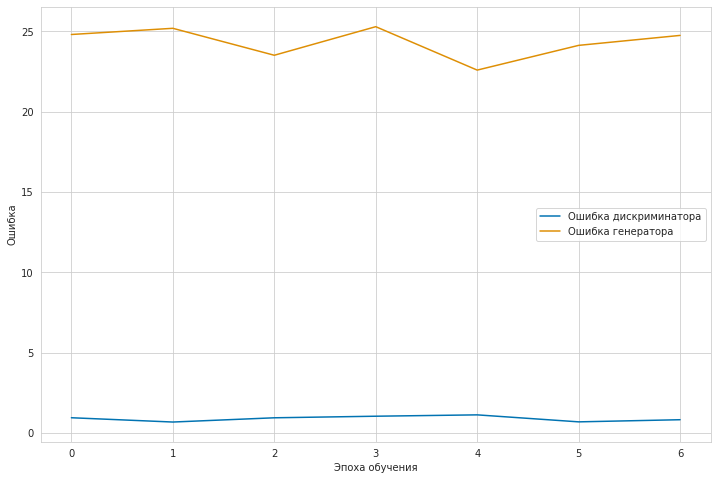

	...epoch 46/300	batch 0/7	D loss: 1.062033	G loss: 23.496531
	...epoch 46/300	batch 1/7	D loss: 1.001142	G loss: 26.110437
	...epoch 46/300	batch 2/7	D loss: 1.885023	G loss: 22.588219
	...epoch 46/300	batch 3/7	D loss: 0.788094	G loss: 23.019949
	...epoch 46/300	batch 4/7	D loss: 0.752599	G loss: 23.746857
	...epoch 46/300	batch 5/7	D loss: 0.907667	G loss: 22.474976
	...epoch 46/300	batch 6/7	D loss: 1.374189	G loss: 20.771269


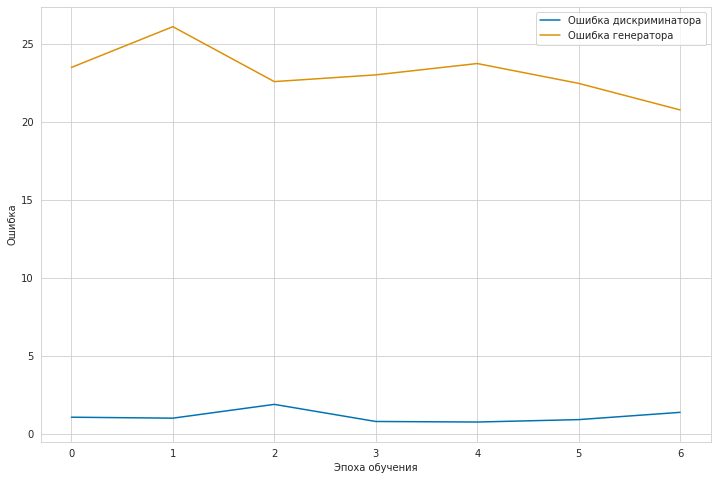

	...epoch 47/300	batch 0/7	D loss: 0.833938	G loss: 24.840328
	...epoch 47/300	batch 1/7	D loss: 0.713699	G loss: 22.939390
	...epoch 47/300	batch 2/7	D loss: 0.891162	G loss: 23.690853
	...epoch 47/300	batch 3/7	D loss: 1.100522	G loss: 22.096598
	...epoch 47/300	batch 4/7	D loss: 0.718962	G loss: 23.213884
	...epoch 47/300	batch 5/7	D loss: 0.875548	G loss: 23.443913
	...epoch 47/300	batch 6/7	D loss: 0.841636	G loss: 24.950523


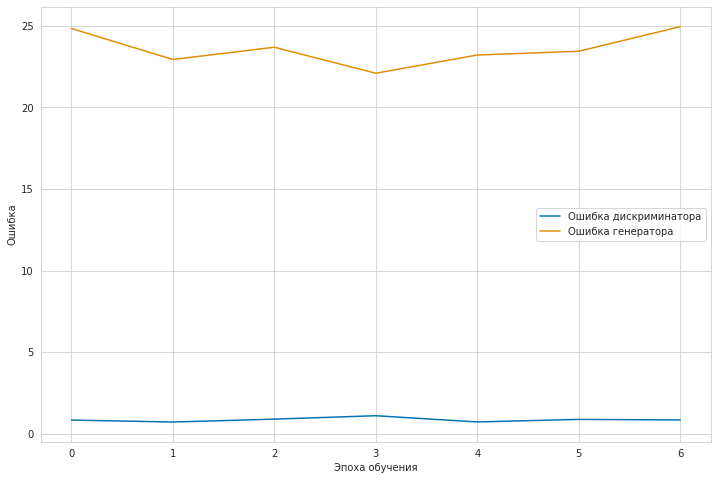

	...epoch 48/300	batch 0/7	D loss: 1.605694	G loss: 23.425224
	...epoch 48/300	batch 1/7	D loss: 0.531562	G loss: 24.119658
	...epoch 48/300	batch 2/7	D loss: 0.754489	G loss: 23.161142
	...epoch 48/300	batch 3/7	D loss: 0.778070	G loss: 23.697060
	...epoch 48/300	batch 4/7	D loss: 1.050114	G loss: 22.927856
	...epoch 48/300	batch 5/7	D loss: 0.727383	G loss: 21.995012
	...epoch 48/300	batch 6/7	D loss: 1.809544	G loss: 26.856096


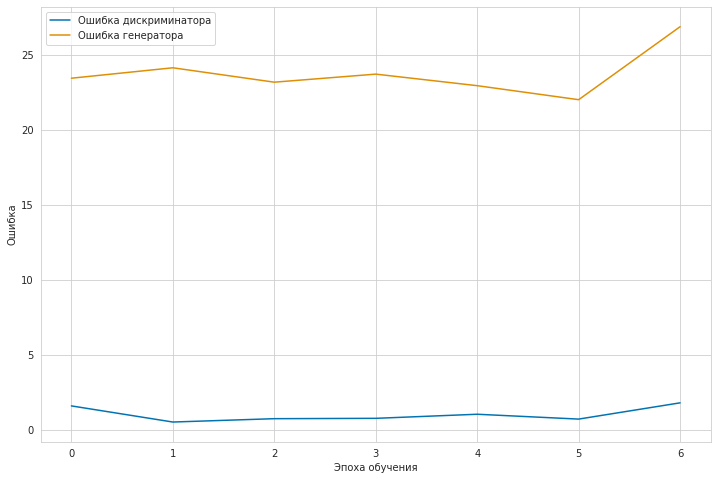

	...epoch 49/300	batch 0/7	D loss: 2.909158	G loss: 22.957193
	...epoch 49/300	batch 1/7	D loss: 1.538370	G loss: 22.760963
	...epoch 49/300	batch 2/7	D loss: 1.690545	G loss: 22.300064
	...epoch 49/300	batch 3/7	D loss: 0.937412	G loss: 21.519573
	...epoch 49/300	batch 4/7	D loss: 1.002169	G loss: 20.896229
	...epoch 49/300	batch 5/7	D loss: 0.818036	G loss: 20.980034
	...epoch 49/300	batch 6/7	D loss: 0.657622	G loss: 22.814264


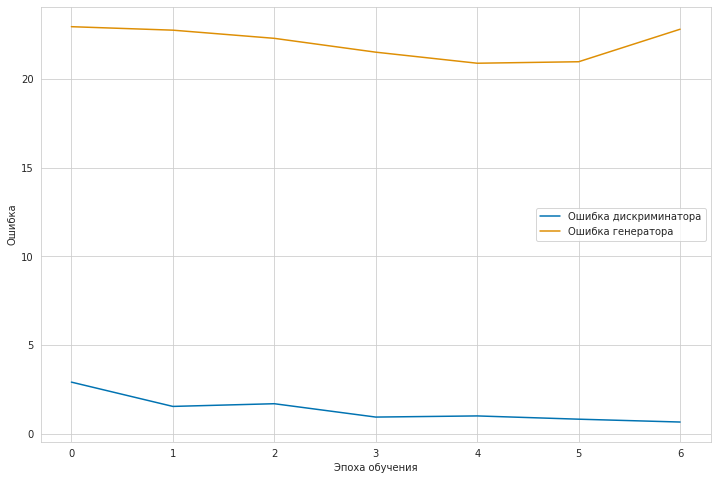

	...epoch 50/300	batch 0/7	D loss: 0.577223	G loss: 23.415712
	...epoch 50/300	batch 1/7	D loss: 0.593319	G loss: 21.696093
	...epoch 50/300	batch 2/7	D loss: 0.487928	G loss: 22.458290
	...epoch 50/300	batch 3/7	D loss: 0.525802	G loss: 22.211363
	...epoch 50/300	batch 4/7	D loss: 1.105015	G loss: 23.622250
	...epoch 50/300	batch 5/7	D loss: 1.327224	G loss: 21.860806
	...epoch 50/300	batch 6/7	D loss: 0.613857	G loss: 22.666264


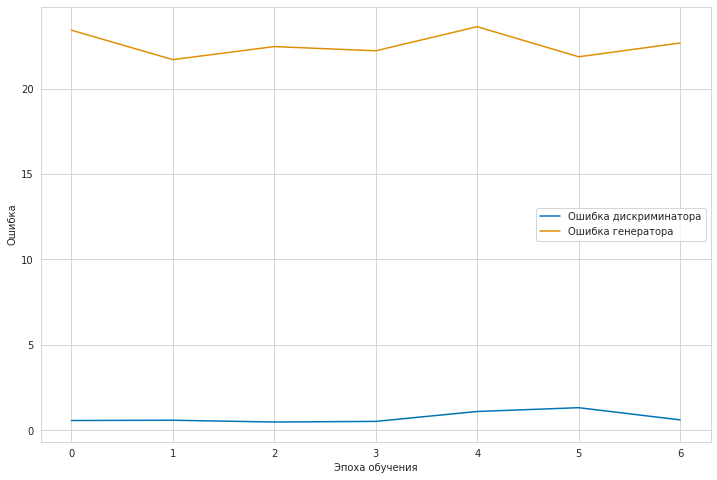

	...epoch 51/300	batch 0/7	D loss: 0.567236	G loss: 24.047619
	...epoch 51/300	batch 1/7	D loss: 0.709038	G loss: 23.346224
	...epoch 51/300	batch 2/7	D loss: 0.651965	G loss: 23.825619
	...epoch 51/300	batch 3/7	D loss: 0.922991	G loss: 22.100292
	...epoch 51/300	batch 4/7	D loss: 0.968328	G loss: 24.772810
	...epoch 51/300	batch 5/7	D loss: 1.218362	G loss: 22.841475
	...epoch 51/300	batch 6/7	D loss: 0.842700	G loss: 20.790470


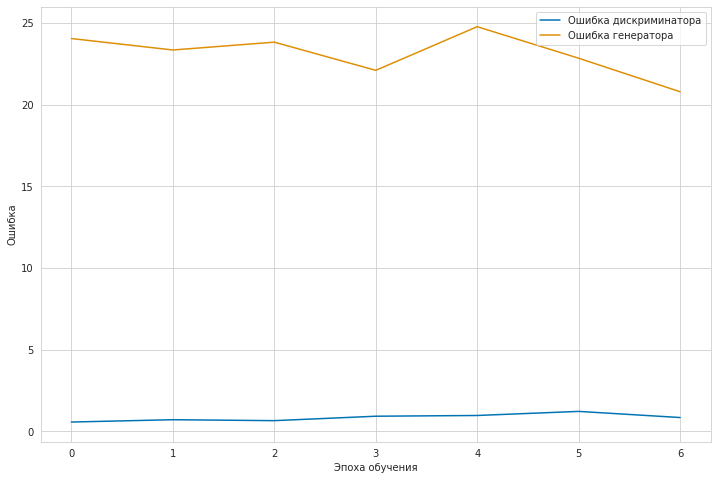

	...epoch 52/300	batch 0/7	D loss: 0.782108	G loss: 20.837606
	...epoch 52/300	batch 1/7	D loss: 0.729511	G loss: 22.682482
	...epoch 52/300	batch 2/7	D loss: 1.043399	G loss: 22.320230
	...epoch 52/300	batch 3/7	D loss: 0.760282	G loss: 22.121614
	...epoch 52/300	batch 4/7	D loss: 1.079056	G loss: 23.560621
	...epoch 52/300	batch 5/7	D loss: 1.155130	G loss: 21.400331
	...epoch 52/300	batch 6/7	D loss: 0.518814	G loss: 21.932117


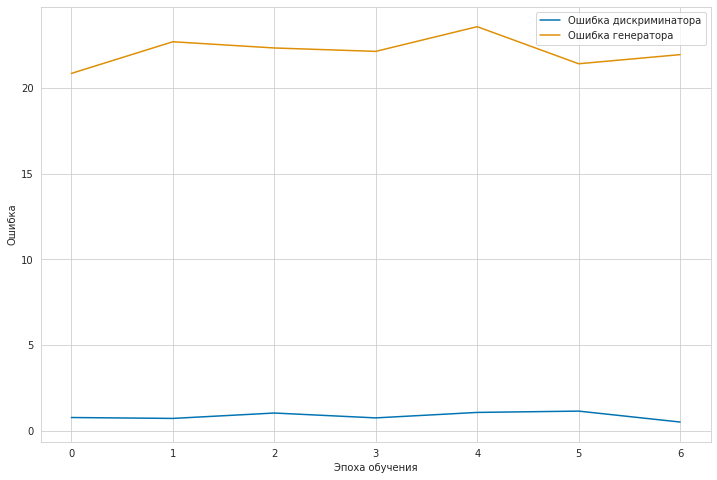

	...epoch 53/300	batch 0/7	D loss: 1.107576	G loss: 22.744377
	...epoch 53/300	batch 1/7	D loss: 1.336691	G loss: 21.526134
	...epoch 53/300	batch 2/7	D loss: 0.961419	G loss: 21.316580
	...epoch 53/300	batch 3/7	D loss: 1.382178	G loss: 21.522009
	...epoch 53/300	batch 4/7	D loss: 0.695533	G loss: 21.690578
	...epoch 53/300	batch 5/7	D loss: 0.896318	G loss: 22.221416
	...epoch 53/300	batch 6/7	D loss: 1.017341	G loss: 22.680954


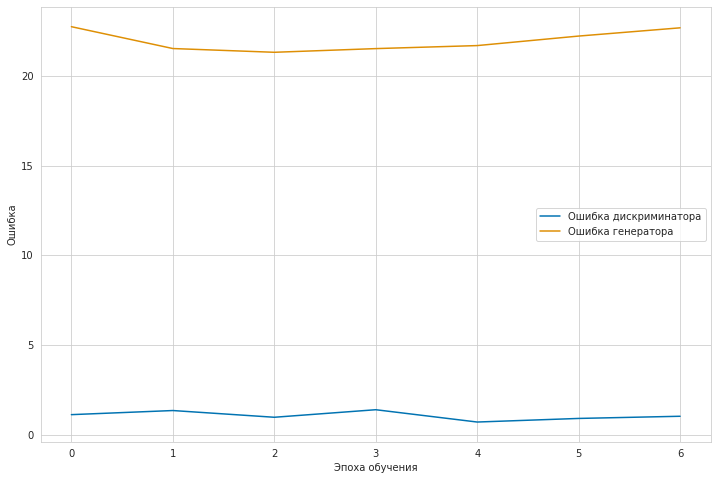

	...epoch 54/300	batch 0/7	D loss: 1.150551	G loss: 21.707308
	...epoch 54/300	batch 1/7	D loss: 0.980281	G loss: 23.128937
	...epoch 54/300	batch 2/7	D loss: 1.146375	G loss: 21.337044
	...epoch 54/300	batch 3/7	D loss: 0.899676	G loss: 21.033533
	...epoch 54/300	batch 4/7	D loss: 0.815998	G loss: 21.267527
	...epoch 54/300	batch 5/7	D loss: 0.970989	G loss: 22.525116
	...epoch 54/300	batch 6/7	D loss: 1.218630	G loss: 20.756508


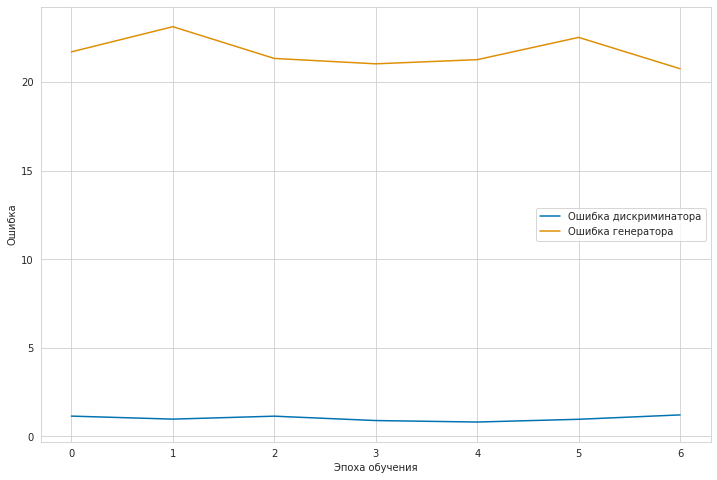

	...epoch 55/300	batch 0/7	D loss: 0.773121	G loss: 22.152851
	...epoch 55/300	batch 1/7	D loss: 1.162337	G loss: 21.770422
	...epoch 55/300	batch 2/7	D loss: 1.594820	G loss: 21.166355
	...epoch 55/300	batch 3/7	D loss: 1.086141	G loss: 20.614908
	...epoch 55/300	batch 4/7	D loss: 1.608654	G loss: 20.911461
	...epoch 55/300	batch 5/7	D loss: 1.384205	G loss: 21.258204
	...epoch 55/300	batch 6/7	D loss: 2.186406	G loss: 22.306183


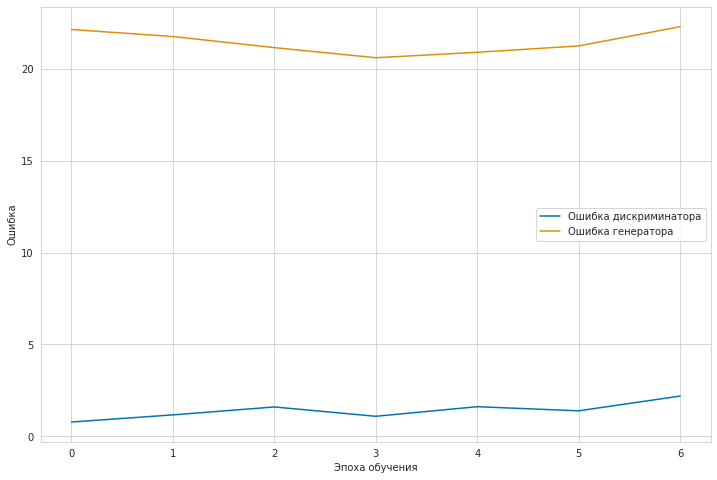

	...epoch 56/300	batch 0/7	D loss: 3.407724	G loss: 21.159761
	...epoch 56/300	batch 1/7	D loss: 1.103621	G loss: 20.128319
	...epoch 56/300	batch 2/7	D loss: 1.194732	G loss: 20.831678
	...epoch 56/300	batch 3/7	D loss: 0.661209	G loss: 20.347198
	...epoch 56/300	batch 4/7	D loss: 0.939855	G loss: 19.724657
	...epoch 56/300	batch 5/7	D loss: 0.740918	G loss: 20.121386
	...epoch 56/300	batch 6/7	D loss: 0.973260	G loss: 20.015320


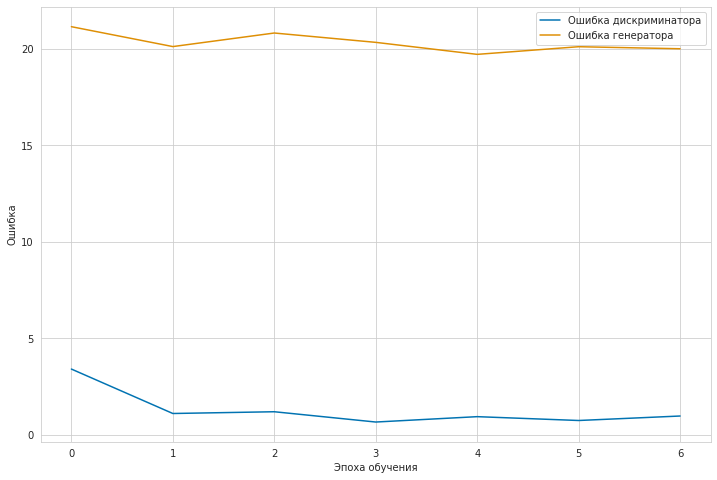

	...epoch 57/300	batch 0/7	D loss: 0.745633	G loss: 21.725573
	...epoch 57/300	batch 1/7	D loss: 0.797074	G loss: 21.553057
	...epoch 57/300	batch 2/7	D loss: 0.949063	G loss: 21.927908
	...epoch 57/300	batch 3/7	D loss: 1.167747	G loss: 20.823242
	...epoch 57/300	batch 4/7	D loss: 0.842928	G loss: 20.686480
	...epoch 57/300	batch 5/7	D loss: 0.817406	G loss: 20.610516
	...epoch 57/300	batch 6/7	D loss: 1.249408	G loss: 21.515186


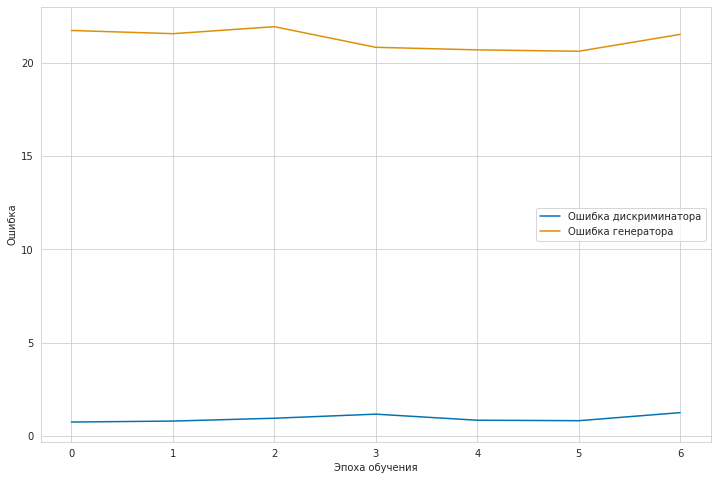

	...epoch 58/300	batch 0/7	D loss: 1.290057	G loss: 20.433302
	...epoch 58/300	batch 1/7	D loss: 1.066771	G loss: 20.406439
	...epoch 58/300	batch 2/7	D loss: 1.004281	G loss: 18.756725
	...epoch 58/300	batch 3/7	D loss: 1.378345	G loss: 22.375828
	...epoch 58/300	batch 4/7	D loss: 1.627644	G loss: 20.148190
	...epoch 58/300	batch 5/7	D loss: 0.816467	G loss: 19.287371
	...epoch 58/300	batch 6/7	D loss: 0.929387	G loss: 21.630589


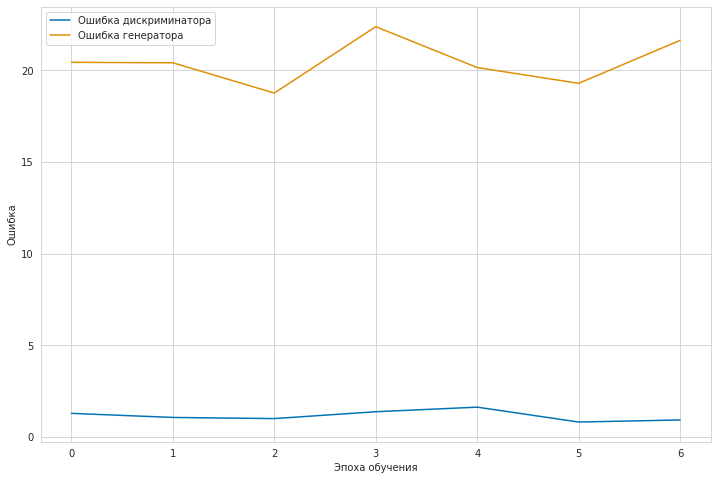

	...epoch 59/300	batch 0/7	D loss: 1.124439	G loss: 20.454821
	...epoch 59/300	batch 1/7	D loss: 0.808781	G loss: 20.796625
	...epoch 59/300	batch 2/7	D loss: 0.869939	G loss: 20.036718
	...epoch 59/300	batch 3/7	D loss: 0.897046	G loss: 20.305971
	...epoch 59/300	batch 4/7	D loss: 1.012633	G loss: 20.764250
	...epoch 59/300	batch 5/7	D loss: 1.053923	G loss: 19.490986
	...epoch 59/300	batch 6/7	D loss: 0.645187	G loss: 21.059330


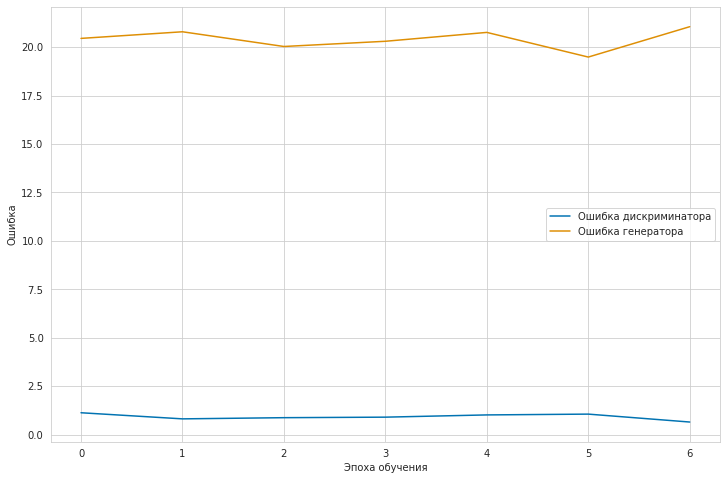

	...epoch 60/300	batch 0/7	D loss: 1.097167	G loss: 19.725677
	...epoch 60/300	batch 1/7	D loss: 0.800029	G loss: 20.203630
	...epoch 60/300	batch 2/7	D loss: 0.937265	G loss: 21.323364
	...epoch 60/300	batch 3/7	D loss: 1.679804	G loss: 20.036036
	...epoch 60/300	batch 4/7	D loss: 0.909254	G loss: 18.949438
	...epoch 60/300	batch 5/7	D loss: 1.100465	G loss: 21.188356
	...epoch 60/300	batch 6/7	D loss: 0.785893	G loss: 19.306431


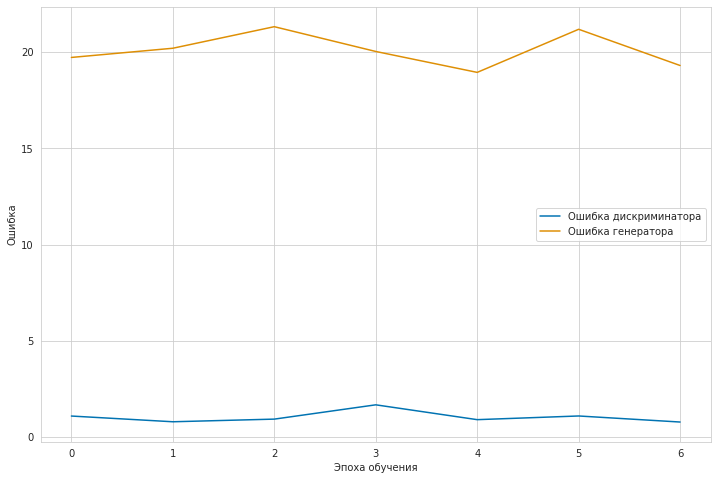

	...epoch 61/300	batch 0/7	D loss: 0.799954	G loss: 19.263407
	...epoch 61/300	batch 1/7	D loss: 0.874999	G loss: 19.934164
	...epoch 61/300	batch 2/7	D loss: 0.870578	G loss: 19.236872
	...epoch 61/300	batch 3/7	D loss: 0.865398	G loss: 19.575548
	...epoch 61/300	batch 4/7	D loss: 1.116206	G loss: 21.528709
	...epoch 61/300	batch 5/7	D loss: 1.575541	G loss: 19.312645
	...epoch 61/300	batch 6/7	D loss: 1.112043	G loss: 18.248247


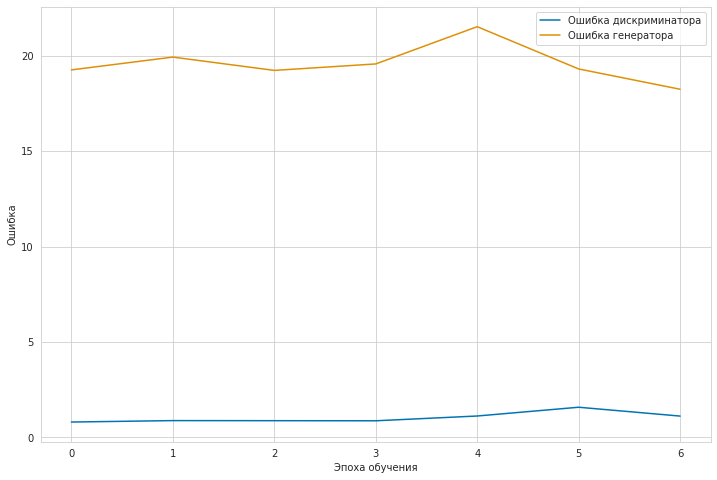

	...epoch 62/300	batch 0/7	D loss: 0.593146	G loss: 20.300760
	...epoch 62/300	batch 1/7	D loss: 0.786594	G loss: 19.246521
	...epoch 62/300	batch 2/7	D loss: 0.862433	G loss: 19.223173
	...epoch 62/300	batch 3/7	D loss: 1.041977	G loss: 21.817287
	...epoch 62/300	batch 4/7	D loss: 1.263216	G loss: 19.949142
	...epoch 62/300	batch 5/7	D loss: 0.880755	G loss: 17.981268
	...epoch 62/300	batch 6/7	D loss: 1.813892	G loss: 21.401304


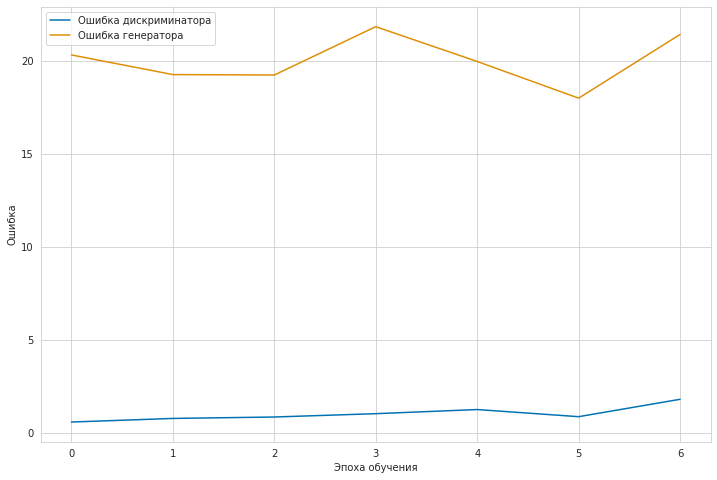

	...epoch 63/300	batch 0/7	D loss: 1.878115	G loss: 19.065931
	...epoch 63/300	batch 1/7	D loss: 0.978585	G loss: 17.981054
	...epoch 63/300	batch 2/7	D loss: 1.207936	G loss: 19.663206
	...epoch 63/300	batch 3/7	D loss: 0.812683	G loss: 18.858116
	...epoch 63/300	batch 4/7	D loss: 0.839830	G loss: 17.418440
	...epoch 63/300	batch 5/7	D loss: 0.828575	G loss: 18.551825
	...epoch 63/300	batch 6/7	D loss: 0.733641	G loss: 19.735357


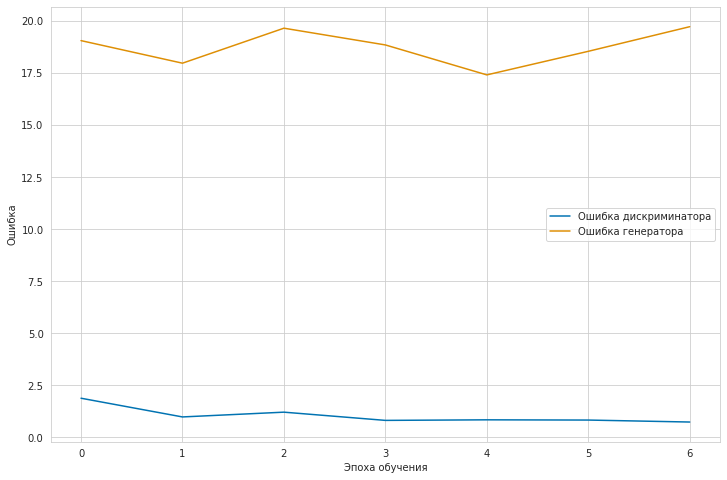

	...epoch 64/300	batch 0/7	D loss: 0.764971	G loss: 19.596834
	...epoch 64/300	batch 1/7	D loss: 0.774722	G loss: 18.097612
	...epoch 64/300	batch 2/7	D loss: 1.254273	G loss: 20.275208
	...epoch 64/300	batch 3/7	D loss: 0.859390	G loss: 19.330675
	...epoch 64/300	batch 4/7	D loss: 1.086118	G loss: 18.227245
	...epoch 64/300	batch 5/7	D loss: 0.792003	G loss: 19.666285
	...epoch 64/300	batch 6/7	D loss: 0.551308	G loss: 20.536591


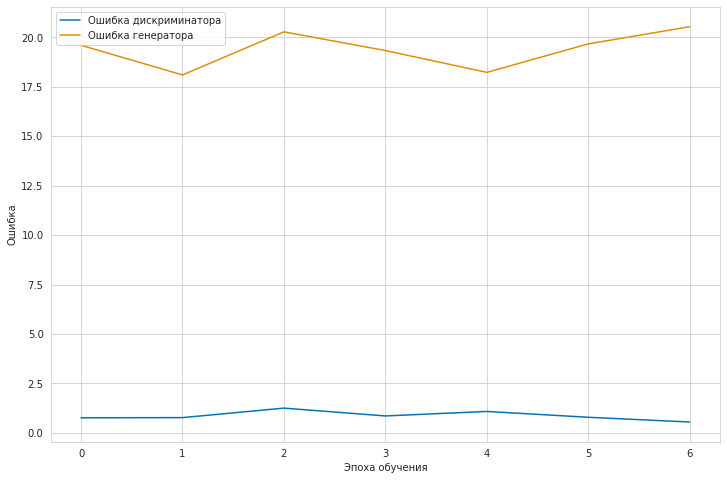

	...epoch 65/300	batch 0/7	D loss: 0.872252	G loss: 20.397060
	...epoch 65/300	batch 1/7	D loss: 0.923802	G loss: 19.191339
	...epoch 65/300	batch 2/7	D loss: 0.937158	G loss: 19.267996
	...epoch 65/300	batch 3/7	D loss: 0.715099	G loss: 19.554171
	...epoch 65/300	batch 4/7	D loss: 1.153182	G loss: 19.811602
	...epoch 65/300	batch 5/7	D loss: 0.951045	G loss: 19.806828
	...epoch 65/300	batch 6/7	D loss: 0.815911	G loss: 20.007017


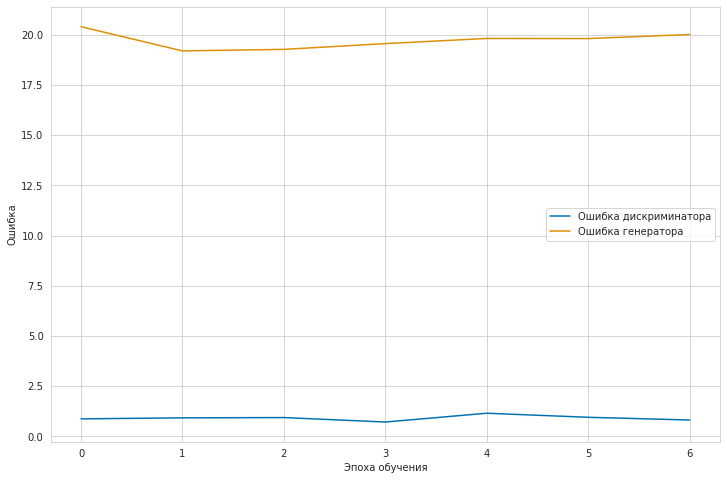

	...epoch 66/300	batch 0/7	D loss: 1.019514	G loss: 19.709532
	...epoch 66/300	batch 1/7	D loss: 1.230350	G loss: 20.693686
	...epoch 66/300	batch 2/7	D loss: 1.074716	G loss: 19.602509
	...epoch 66/300	batch 3/7	D loss: 1.018926	G loss: 18.951082
	...epoch 66/300	batch 4/7	D loss: 0.844787	G loss: 19.184431
	...epoch 66/300	batch 5/7	D loss: 1.034715	G loss: 18.909214
	...epoch 66/300	batch 6/7	D loss: 1.251172	G loss: 18.154884


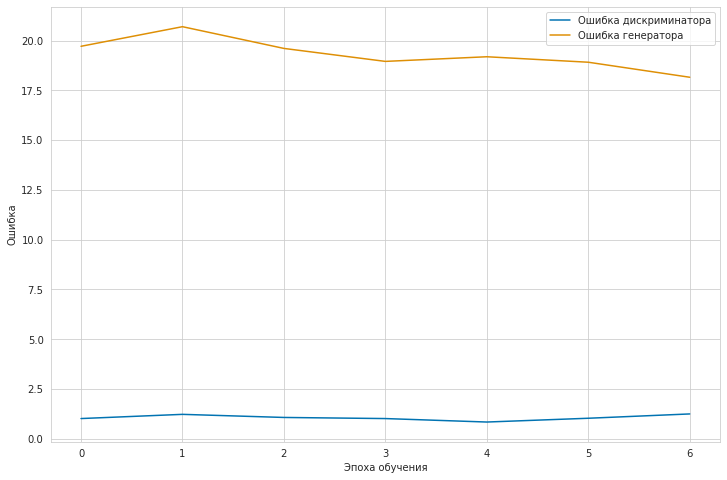

	...epoch 67/300	batch 0/7	D loss: 0.897601	G loss: 18.768202
	...epoch 67/300	batch 1/7	D loss: 1.318564	G loss: 20.827318
	...epoch 67/300	batch 2/7	D loss: 1.874938	G loss: 19.421221
	...epoch 67/300	batch 3/7	D loss: 1.223750	G loss: 17.390928
	...epoch 67/300	batch 4/7	D loss: 1.348954	G loss: 19.104610
	...epoch 67/300	batch 5/7	D loss: 0.836814	G loss: 17.945831
	...epoch 67/300	batch 6/7	D loss: 1.218634	G loss: 19.141047


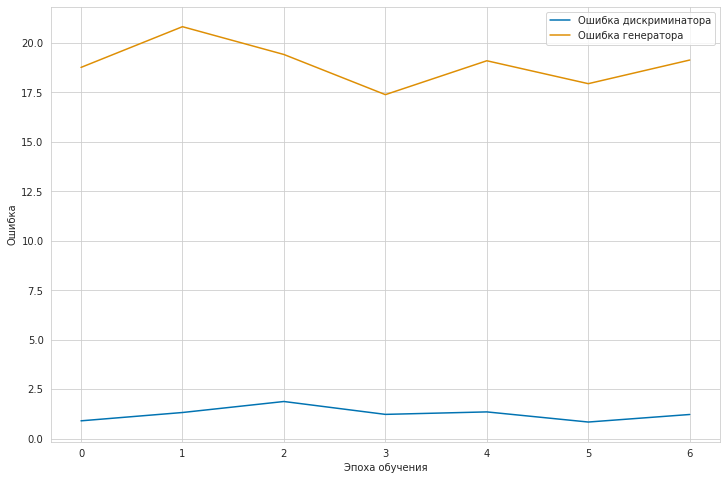

	...epoch 68/300	batch 0/7	D loss: 1.242873	G loss: 18.403061
	...epoch 68/300	batch 1/7	D loss: 0.868537	G loss: 17.532036
	...epoch 68/300	batch 2/7	D loss: 1.153352	G loss: 19.418184
	...epoch 68/300	batch 3/7	D loss: 0.858256	G loss: 18.651691
	...epoch 68/300	batch 4/7	D loss: 0.780141	G loss: 17.759804
	...epoch 68/300	batch 5/7	D loss: 1.125852	G loss: 19.604996
	...epoch 68/300	batch 6/7	D loss: 2.073748	G loss: 18.012630


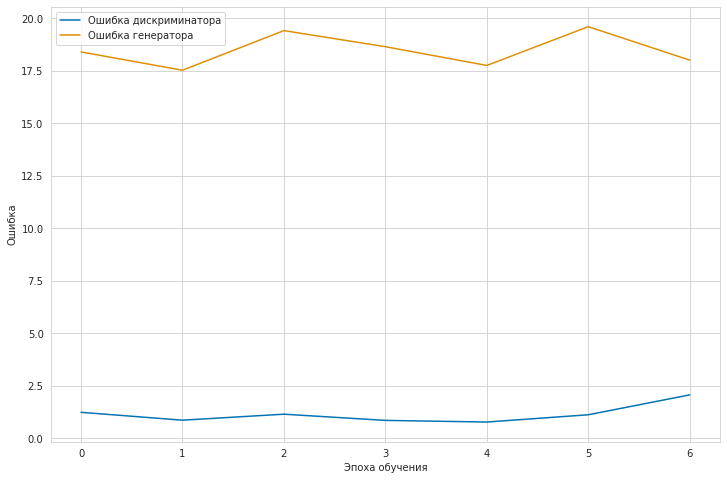

	...epoch 69/300	batch 0/7	D loss: 0.671726	G loss: 18.618536
	...epoch 69/300	batch 1/7	D loss: 0.748804	G loss: 18.247498
	...epoch 69/300	batch 2/7	D loss: 0.656121	G loss: 18.581629
	...epoch 69/300	batch 3/7	D loss: 0.828172	G loss: 18.754276
	...epoch 69/300	batch 4/7	D loss: 0.973063	G loss: 16.866182
	...epoch 69/300	batch 5/7	D loss: 0.982780	G loss: 18.718580
	...epoch 69/300	batch 6/7	D loss: 0.839705	G loss: 18.679955


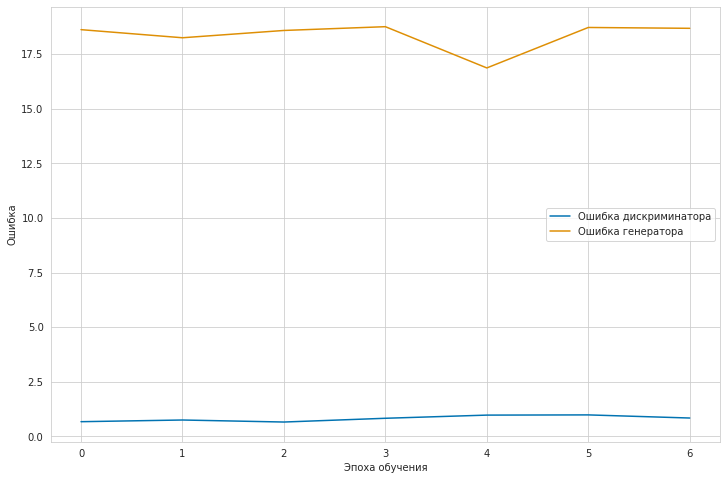

	...epoch 70/300	batch 0/7	D loss: 0.932537	G loss: 18.138170
	...epoch 70/300	batch 1/7	D loss: 0.884671	G loss: 18.506697
	...epoch 70/300	batch 2/7	D loss: 0.623024	G loss: 17.828325
	...epoch 70/300	batch 3/7	D loss: 0.833433	G loss: 18.645506
	...epoch 70/300	batch 4/7	D loss: 0.982539	G loss: 17.701040
	...epoch 70/300	batch 5/7	D loss: 0.753420	G loss: 18.620705
	...epoch 70/300	batch 6/7	D loss: 1.097515	G loss: 18.649387


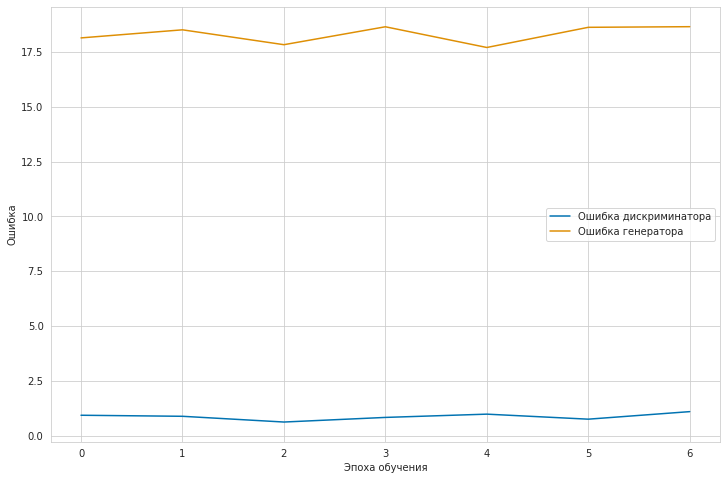

	...epoch 71/300	batch 0/7	D loss: 0.969180	G loss: 19.367758
	...epoch 71/300	batch 1/7	D loss: 1.118622	G loss: 18.014061
	...epoch 71/300	batch 2/7	D loss: 1.033086	G loss: 18.652603
	...epoch 71/300	batch 3/7	D loss: 1.018446	G loss: 18.852575
	...epoch 71/300	batch 4/7	D loss: 1.154582	G loss: 17.647470
	...epoch 71/300	batch 5/7	D loss: 0.817736	G loss: 18.426903
	...epoch 71/300	batch 6/7	D loss: 0.778271	G loss: 20.819143


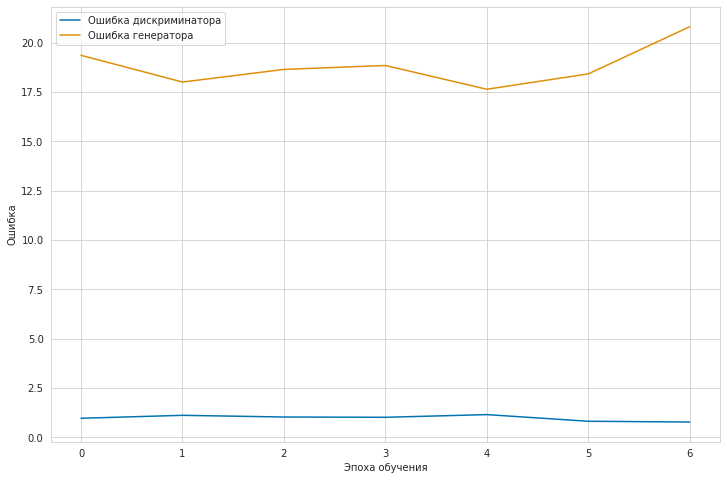

	...epoch 72/300	batch 0/7	D loss: 1.236294	G loss: 18.325991
	...epoch 72/300	batch 1/7	D loss: 1.095103	G loss: 19.244434
	...epoch 72/300	batch 2/7	D loss: 1.273655	G loss: 19.755941
	...epoch 72/300	batch 3/7	D loss: 1.120357	G loss: 17.763805
	...epoch 72/300	batch 4/7	D loss: 1.306165	G loss: 18.700279
	...epoch 72/300	batch 5/7	D loss: 0.923998	G loss: 17.936573
	...epoch 72/300	batch 6/7	D loss: 0.860698	G loss: 17.527969


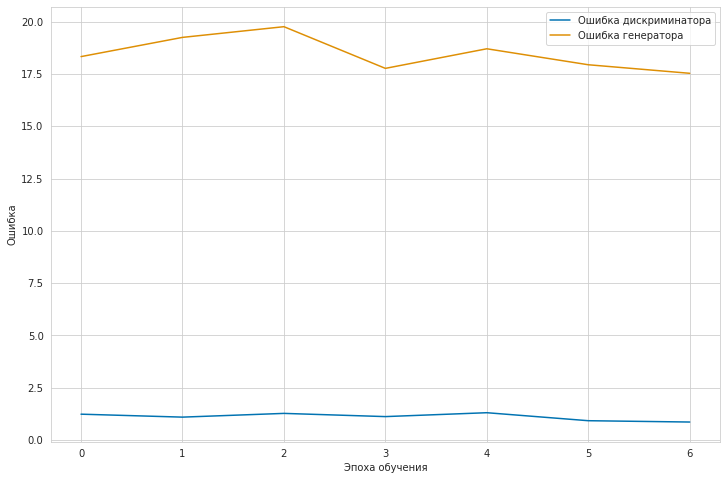

	...epoch 73/300	batch 0/7	D loss: 1.197649	G loss: 18.991945
	...epoch 73/300	batch 1/7	D loss: 1.345590	G loss: 17.819389
	...epoch 73/300	batch 2/7	D loss: 0.791340	G loss: 18.338707
	...epoch 73/300	batch 3/7	D loss: 0.637953	G loss: 18.253784
	...epoch 73/300	batch 4/7	D loss: 0.914077	G loss: 18.242813
	...epoch 73/300	batch 5/7	D loss: 0.866273	G loss: 18.070461
	...epoch 73/300	batch 6/7	D loss: 1.009490	G loss: 18.292467


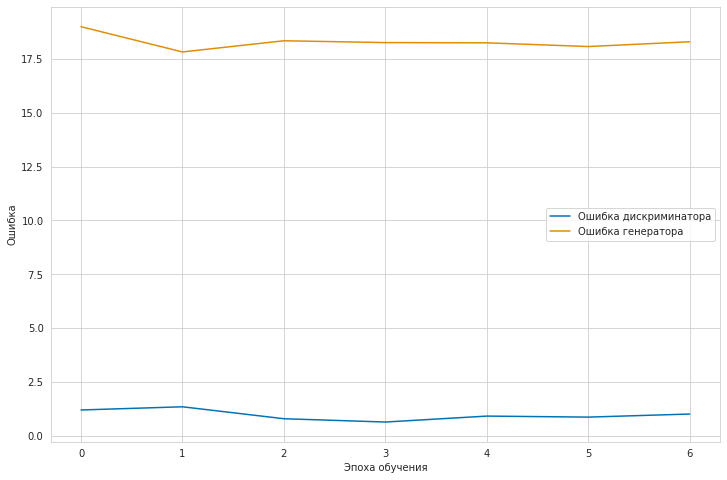

	...epoch 74/300	batch 0/7	D loss: 0.915509	G loss: 19.490606
	...epoch 74/300	batch 1/7	D loss: 0.869824	G loss: 18.038918
	...epoch 74/300	batch 2/7	D loss: 1.004283	G loss: 18.006941
	...epoch 74/300	batch 3/7	D loss: 0.822368	G loss: 18.978495
	...epoch 74/300	batch 4/7	D loss: 0.957348	G loss: 17.926754
	...epoch 74/300	batch 5/7	D loss: 1.106791	G loss: 19.219151
	...epoch 74/300	batch 6/7	D loss: 1.199931	G loss: 18.268402


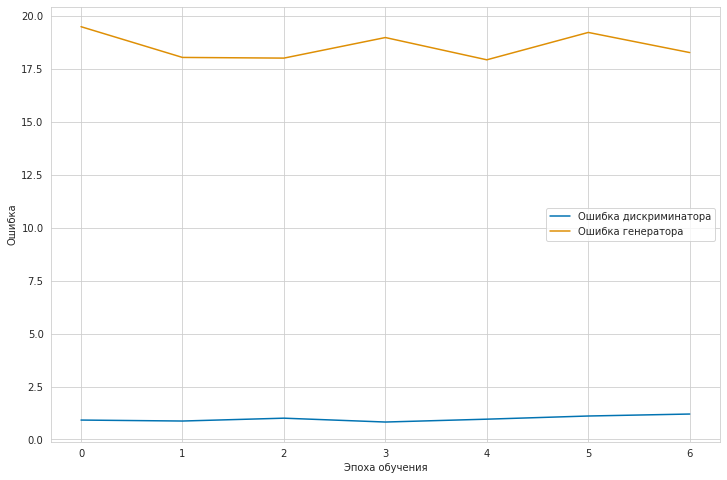

	...epoch 75/300	batch 0/7	D loss: 0.806221	G loss: 18.821356
	...epoch 75/300	batch 1/7	D loss: 0.885780	G loss: 18.137510
	...epoch 75/300	batch 2/7	D loss: 1.150476	G loss: 18.051292
	...epoch 75/300	batch 3/7	D loss: 1.073243	G loss: 18.966494
	...epoch 75/300	batch 4/7	D loss: 1.408300	G loss: 16.978777
	...epoch 75/300	batch 5/7	D loss: 0.921664	G loss: 17.438087
	...epoch 75/300	batch 6/7	D loss: 1.132536	G loss: 20.577417


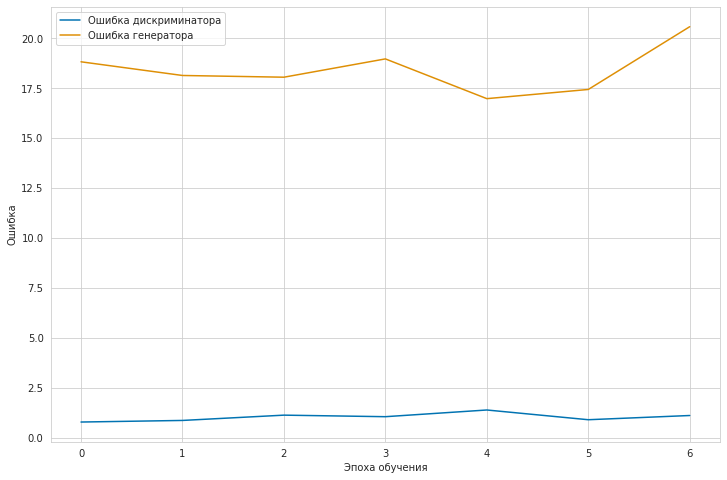

	...epoch 76/300	batch 0/7	D loss: 1.766086	G loss: 17.295397
	...epoch 76/300	batch 1/7	D loss: 1.123976	G loss: 17.154947
	...epoch 76/300	batch 2/7	D loss: 1.149796	G loss: 18.182285
	...epoch 76/300	batch 3/7	D loss: 1.706362	G loss: 16.419485
	...epoch 76/300	batch 4/7	D loss: 1.330941	G loss: 18.476917
	...epoch 76/300	batch 5/7	D loss: 0.832233	G loss: 17.796139
	...epoch 76/300	batch 6/7	D loss: 1.032447	G loss: 16.973511


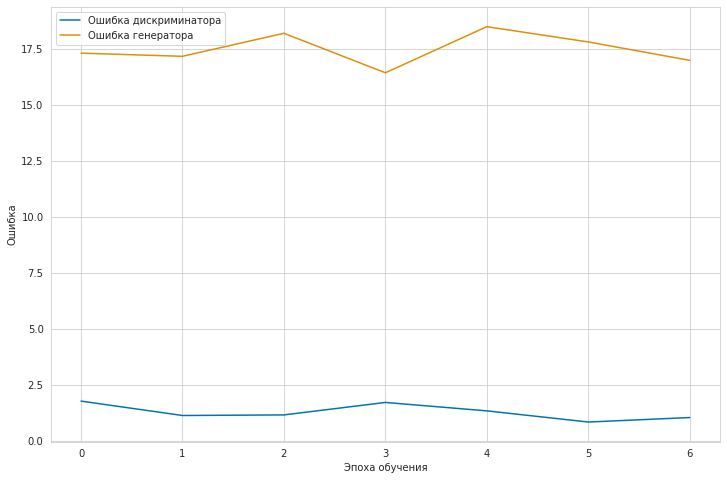

	...epoch 77/300	batch 0/7	D loss: 1.096408	G loss: 18.582180
	...epoch 77/300	batch 1/7	D loss: 0.902850	G loss: 17.094303
	...epoch 77/300	batch 2/7	D loss: 0.817702	G loss: 17.690929
	...epoch 77/300	batch 3/7	D loss: 0.713757	G loss: 17.427341
	...epoch 77/300	batch 4/7	D loss: 0.943135	G loss: 17.596632
	...epoch 77/300	batch 5/7	D loss: 0.794558	G loss: 17.179462
	...epoch 77/300	batch 6/7	D loss: 0.951678	G loss: 17.388803


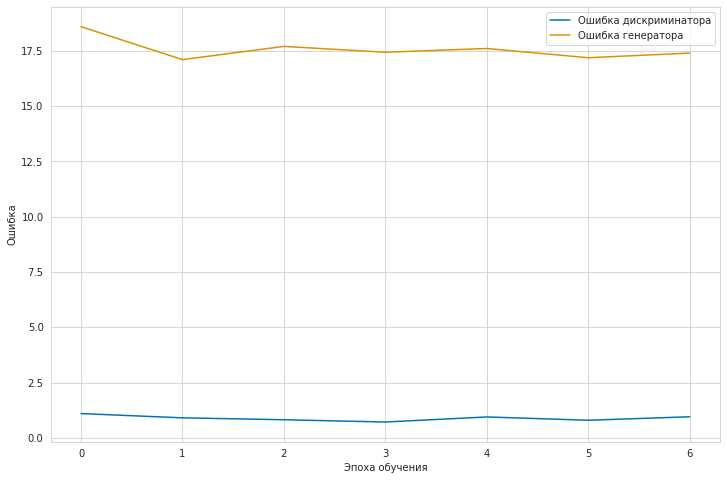

	...epoch 78/300	batch 0/7	D loss: 0.878210	G loss: 18.608086
	...epoch 78/300	batch 1/7	D loss: 0.845742	G loss: 18.730917
	...epoch 78/300	batch 2/7	D loss: 1.041621	G loss: 16.375692
	...epoch 78/300	batch 3/7	D loss: 1.373796	G loss: 19.205849
	...epoch 78/300	batch 4/7	D loss: 1.497670	G loss: 17.506044
	...epoch 78/300	batch 5/7	D loss: 0.975628	G loss: 17.720587
	...epoch 78/300	batch 6/7	D loss: 0.802271	G loss: 18.789318


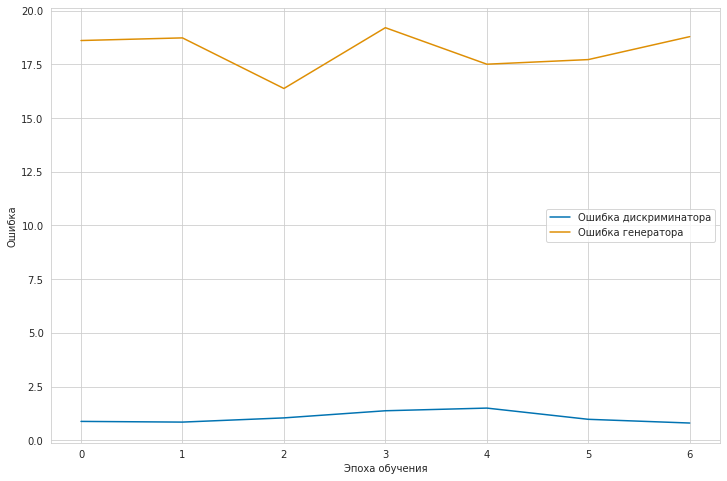

	...epoch 79/300	batch 0/7	D loss: 1.198806	G loss: 18.037651
	...epoch 79/300	batch 1/7	D loss: 0.719214	G loss: 17.041759
	...epoch 79/300	batch 2/7	D loss: 0.867360	G loss: 17.433659
	...epoch 79/300	batch 3/7	D loss: 0.894078	G loss: 16.982092
	...epoch 79/300	batch 4/7	D loss: 1.379590	G loss: 18.480633
	...epoch 79/300	batch 5/7	D loss: 1.248319	G loss: 18.032736
	...epoch 79/300	batch 6/7	D loss: 0.769040	G loss: 17.472982


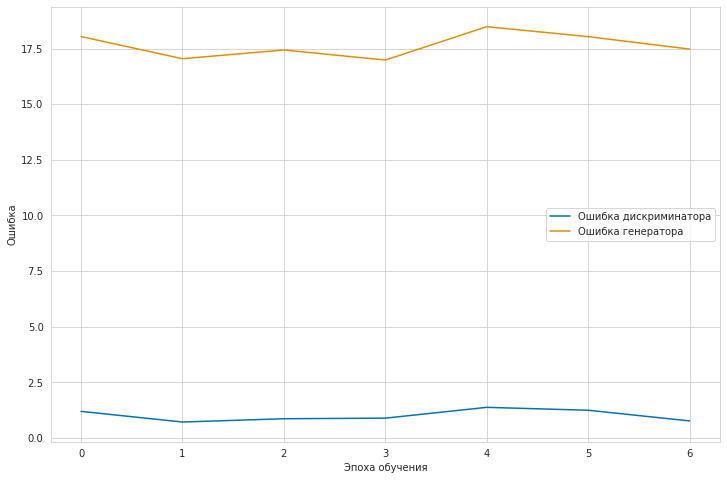

	...epoch 80/300	batch 0/7	D loss: 1.074797	G loss: 17.240473
	...epoch 80/300	batch 1/7	D loss: 0.876750	G loss: 18.281773
	...epoch 80/300	batch 2/7	D loss: 1.006937	G loss: 17.409395
	...epoch 80/300	batch 3/7	D loss: 0.973509	G loss: 17.973717
	...epoch 80/300	batch 4/7	D loss: 1.278907	G loss: 17.247578
	...epoch 80/300	batch 5/7	D loss: 0.965657	G loss: 16.837912
	...epoch 80/300	batch 6/7	D loss: 1.226511	G loss: 17.047987


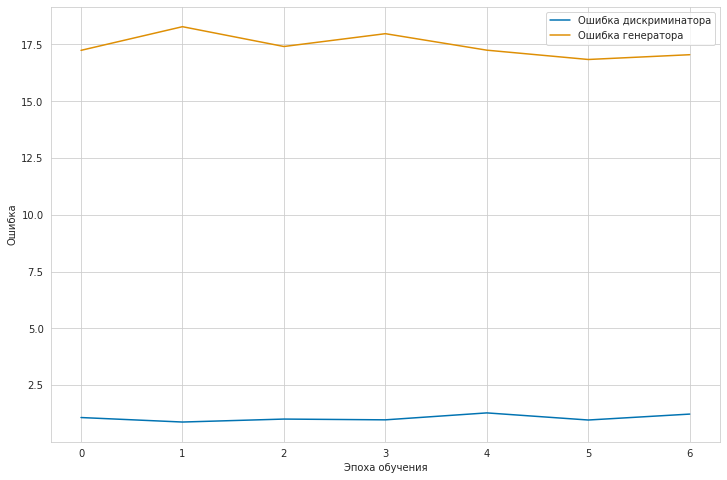

	...epoch 81/300	batch 0/7	D loss: 0.658099	G loss: 17.643703
	...epoch 81/300	batch 1/7	D loss: 1.096159	G loss: 18.336134
	...epoch 81/300	batch 2/7	D loss: 1.380883	G loss: 16.110647
	...epoch 81/300	batch 3/7	D loss: 1.199962	G loss: 19.274363
	...epoch 81/300	batch 4/7	D loss: 1.128437	G loss: 16.669510
	...epoch 81/300	batch 5/7	D loss: 1.041114	G loss: 17.988779
	...epoch 81/300	batch 6/7	D loss: 0.880788	G loss: 19.321102


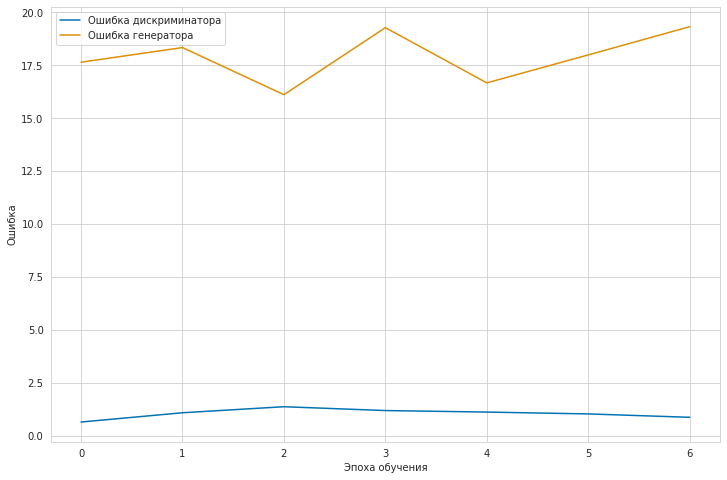

	...epoch 82/300	batch 0/7	D loss: 1.835486	G loss: 17.315447
	...epoch 82/300	batch 1/7	D loss: 0.829631	G loss: 17.034128
	...epoch 82/300	batch 2/7	D loss: 0.979938	G loss: 16.332739
	...epoch 82/300	batch 3/7	D loss: 0.886924	G loss: 17.470348
	...epoch 82/300	batch 4/7	D loss: 0.836811	G loss: 17.982159
	...epoch 82/300	batch 5/7	D loss: 0.846432	G loss: 16.041445
	...epoch 82/300	batch 6/7	D loss: 1.147669	G loss: 18.857347


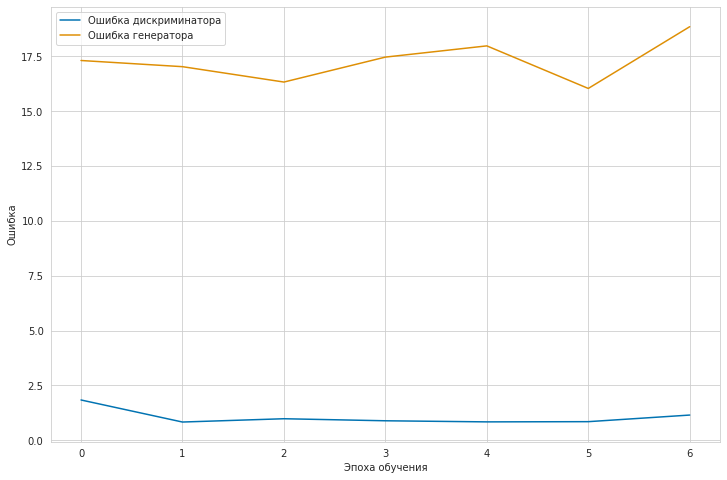

	...epoch 83/300	batch 0/7	D loss: 1.604107	G loss: 16.682472
	...epoch 83/300	batch 1/7	D loss: 1.145674	G loss: 16.817202
	...epoch 83/300	batch 2/7	D loss: 0.953623	G loss: 17.337009
	...epoch 83/300	batch 3/7	D loss: 0.962043	G loss: 16.554266
	...epoch 83/300	batch 4/7	D loss: 1.065955	G loss: 16.316063
	...epoch 83/300	batch 5/7	D loss: 1.254293	G loss: 17.175938
	...epoch 83/300	batch 6/7	D loss: 1.146065	G loss: 16.941442


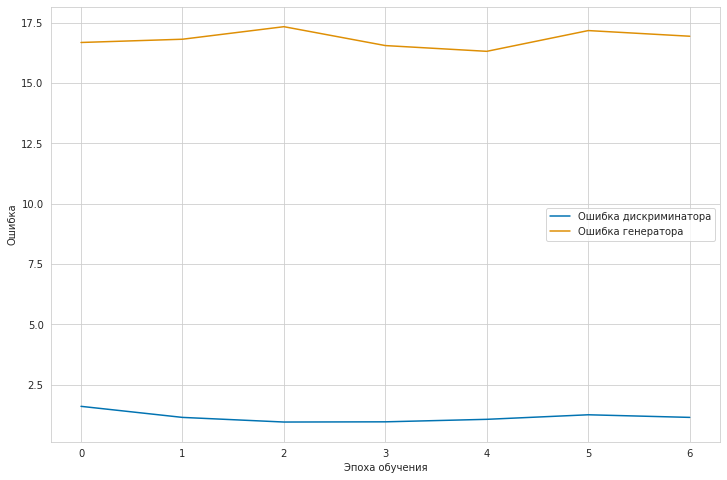

	...epoch 84/300	batch 0/7	D loss: 0.844295	G loss: 18.107721
	...epoch 84/300	batch 1/7	D loss: 0.685179	G loss: 17.324129
	...epoch 84/300	batch 2/7	D loss: 0.868326	G loss: 16.248104
	...epoch 84/300	batch 3/7	D loss: 1.015687	G loss: 18.156702
	...epoch 84/300	batch 4/7	D loss: 1.114835	G loss: 16.085892
	...epoch 84/300	batch 5/7	D loss: 0.959093	G loss: 16.954517
	...epoch 84/300	batch 6/7	D loss: 1.277516	G loss: 17.281826


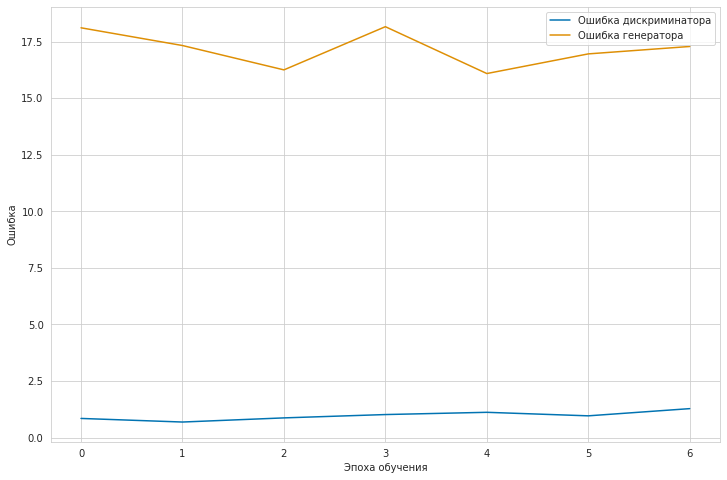

	...epoch 85/300	batch 0/7	D loss: 1.168091	G loss: 16.842012
	...epoch 85/300	batch 1/7	D loss: 0.819112	G loss: 16.868172
	...epoch 85/300	batch 2/7	D loss: 0.964420	G loss: 15.987494
	...epoch 85/300	batch 3/7	D loss: 0.997368	G loss: 16.835670
	...epoch 85/300	batch 4/7	D loss: 1.026952	G loss: 16.454418
	...epoch 85/300	batch 5/7	D loss: 1.044713	G loss: 17.838078
	...epoch 85/300	batch 6/7	D loss: 1.489688	G loss: 16.270628


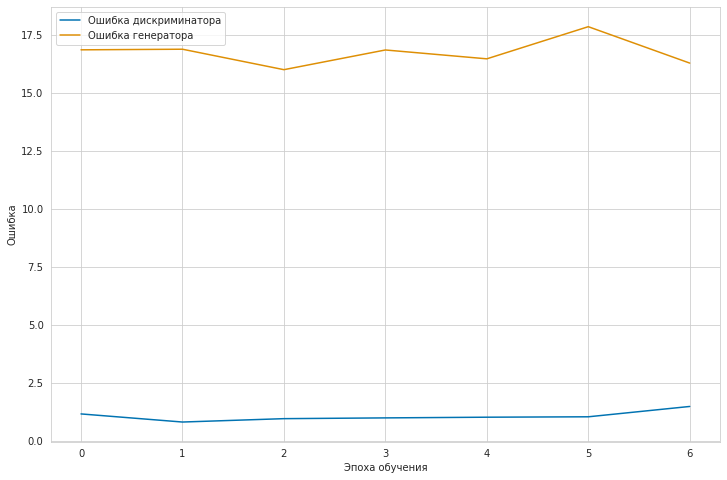

	...epoch 86/300	batch 0/7	D loss: 1.331593	G loss: 18.374718
	...epoch 86/300	batch 1/7	D loss: 0.970828	G loss: 17.444435
	...epoch 86/300	batch 2/7	D loss: 0.935075	G loss: 15.924332
	...epoch 86/300	batch 3/7	D loss: 1.257591	G loss: 17.103287
	...epoch 86/300	batch 4/7	D loss: 1.163381	G loss: 17.190046
	...epoch 86/300	batch 5/7	D loss: 0.972469	G loss: 16.397495
	...epoch 86/300	batch 6/7	D loss: 0.996124	G loss: 19.211246


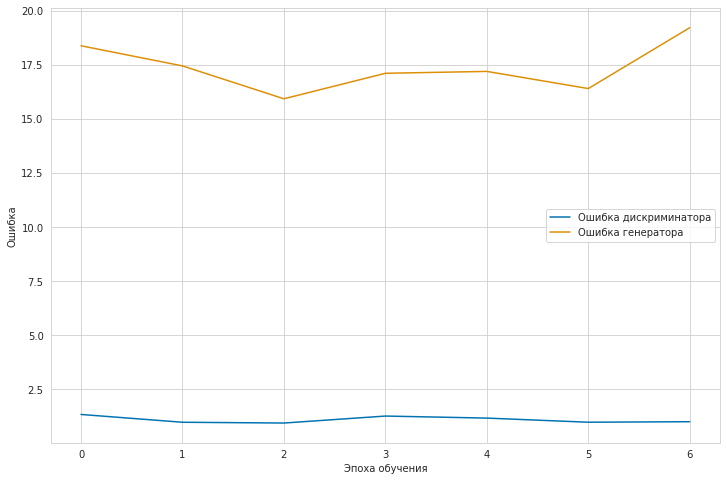

	...epoch 87/300	batch 0/7	D loss: 1.313794	G loss: 17.624020
	...epoch 87/300	batch 1/7	D loss: 0.814005	G loss: 16.723293
	...epoch 87/300	batch 2/7	D loss: 1.101709	G loss: 17.444715
	...epoch 87/300	batch 3/7	D loss: 0.964349	G loss: 16.893318
	...epoch 87/300	batch 4/7	D loss: 0.906589	G loss: 17.399324
	...epoch 87/300	batch 5/7	D loss: 0.865679	G loss: 17.260675
	...epoch 87/300	batch 6/7	D loss: 1.039016	G loss: 18.587534


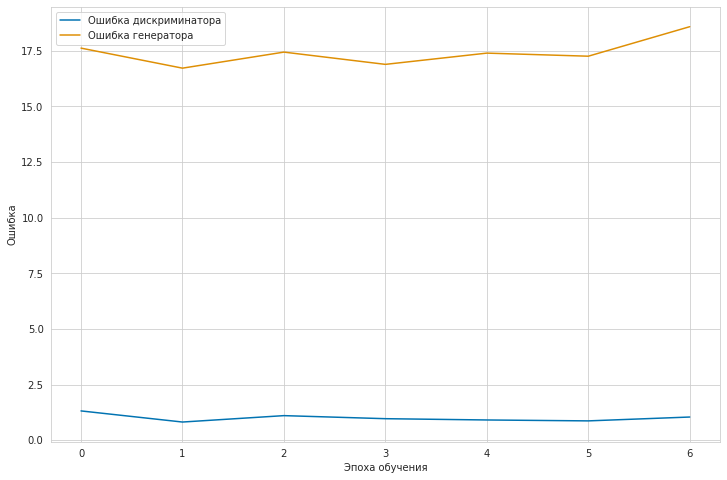

	...epoch 88/300	batch 0/7	D loss: 0.861027	G loss: 17.787369
	...epoch 88/300	batch 1/7	D loss: 1.038730	G loss: 18.384510
	...epoch 88/300	batch 2/7	D loss: 1.298424	G loss: 18.000185
	...epoch 88/300	batch 3/7	D loss: 1.026330	G loss: 17.319117
	...epoch 88/300	batch 4/7	D loss: 1.163084	G loss: 16.456432
	...epoch 88/300	batch 5/7	D loss: 0.976357	G loss: 16.931892
	...epoch 88/300	batch 6/7	D loss: 0.686146	G loss: 16.959448


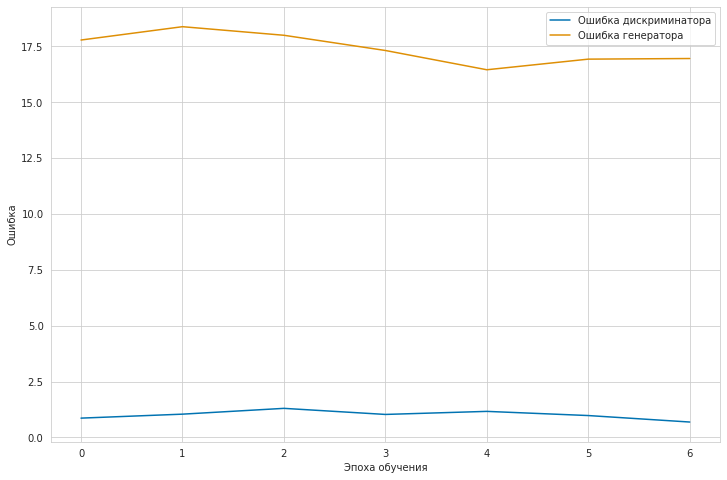

	...epoch 89/300	batch 0/7	D loss: 1.204573	G loss: 17.156075
	...epoch 89/300	batch 1/7	D loss: 1.060052	G loss: 16.769461
	...epoch 89/300	batch 2/7	D loss: 1.215566	G loss: 16.192387
	...epoch 89/300	batch 3/7	D loss: 0.975909	G loss: 17.482466
	...epoch 89/300	batch 4/7	D loss: 1.023618	G loss: 17.710423
	...epoch 89/300	batch 5/7	D loss: 1.003820	G loss: 16.461500
	...epoch 89/300	batch 6/7	D loss: 1.013772	G loss: 18.833813


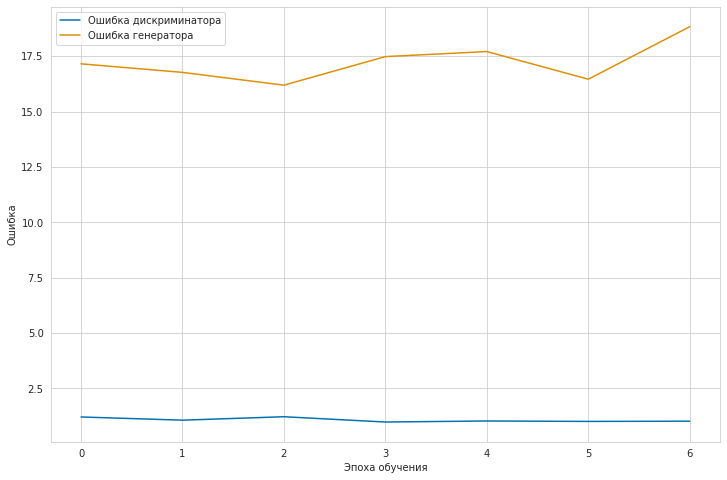

	...epoch 90/300	batch 0/7	D loss: 1.100399	G loss: 16.353611
	...epoch 90/300	batch 1/7	D loss: 1.083564	G loss: 17.788797
	...epoch 90/300	batch 2/7	D loss: 1.423403	G loss: 15.953676
	...epoch 90/300	batch 3/7	D loss: 1.047508	G loss: 16.464659
	...epoch 90/300	batch 4/7	D loss: 0.910966	G loss: 16.360357
	...epoch 90/300	batch 5/7	D loss: 1.116854	G loss: 18.013138
	...epoch 90/300	batch 6/7	D loss: 1.725960	G loss: 17.265327


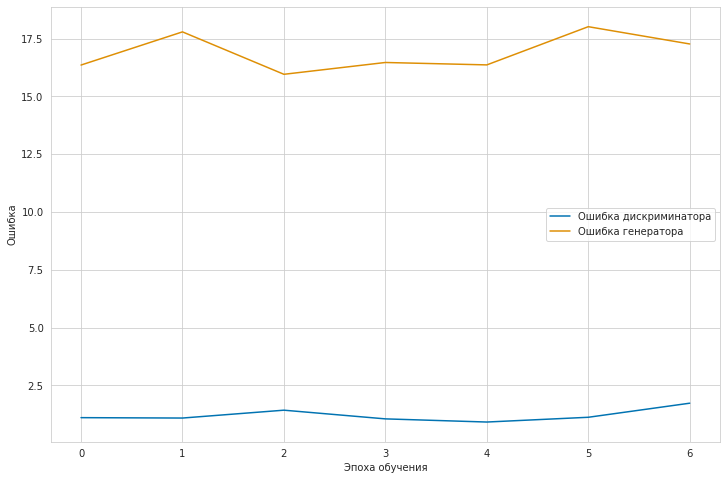

	...epoch 91/300	batch 0/7	D loss: 0.807972	G loss: 16.333410
	...epoch 91/300	batch 1/7	D loss: 0.921743	G loss: 17.817863
	...epoch 91/300	batch 2/7	D loss: 1.062824	G loss: 16.146679
	...epoch 91/300	batch 3/7	D loss: 0.974845	G loss: 16.674290
	...epoch 91/300	batch 4/7	D loss: 1.002722	G loss: 15.571636
	...epoch 91/300	batch 5/7	D loss: 0.754205	G loss: 16.126377
	...epoch 91/300	batch 6/7	D loss: 0.982287	G loss: 15.885288


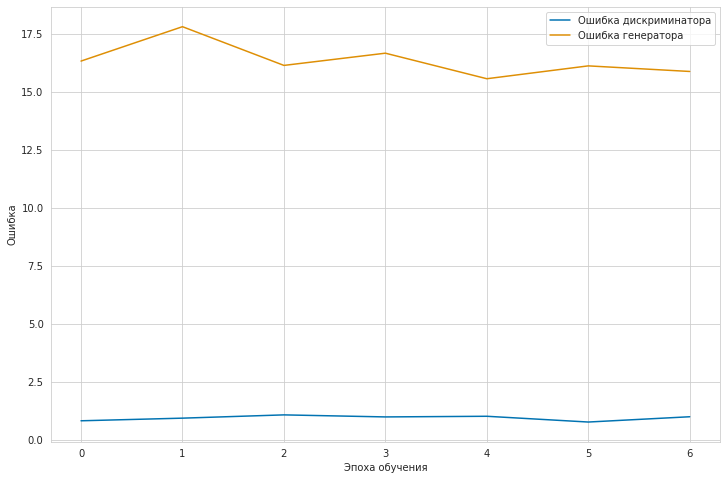

	...epoch 92/300	batch 0/7	D loss: 0.923892	G loss: 17.677118
	...epoch 92/300	batch 1/7	D loss: 1.251333	G loss: 15.677464
	...epoch 92/300	batch 2/7	D loss: 1.003857	G loss: 16.753231
	...epoch 92/300	batch 3/7	D loss: 0.816428	G loss: 16.254868
	...epoch 92/300	batch 4/7	D loss: 0.925451	G loss: 17.750366
	...epoch 92/300	batch 5/7	D loss: 1.423279	G loss: 15.300587
	...epoch 92/300	batch 6/7	D loss: 1.091398	G loss: 15.809869


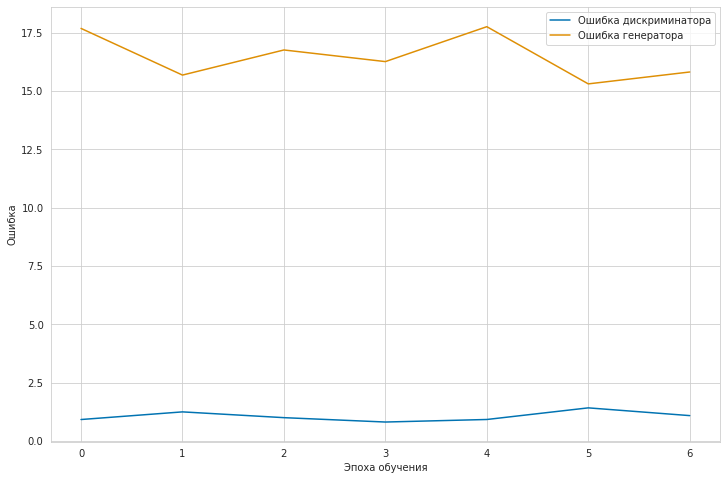

	...epoch 93/300	batch 0/7	D loss: 0.760106	G loss: 15.711436
	...epoch 93/300	batch 1/7	D loss: 1.023640	G loss: 16.225967
	...epoch 93/300	batch 2/7	D loss: 0.929901	G loss: 15.663338
	...epoch 93/300	batch 3/7	D loss: 0.920772	G loss: 17.033592
	...epoch 93/300	batch 4/7	D loss: 1.294470	G loss: 16.646210
	...epoch 93/300	batch 5/7	D loss: 1.160959	G loss: 16.712275
	...epoch 93/300	batch 6/7	D loss: 1.055557	G loss: 17.468916


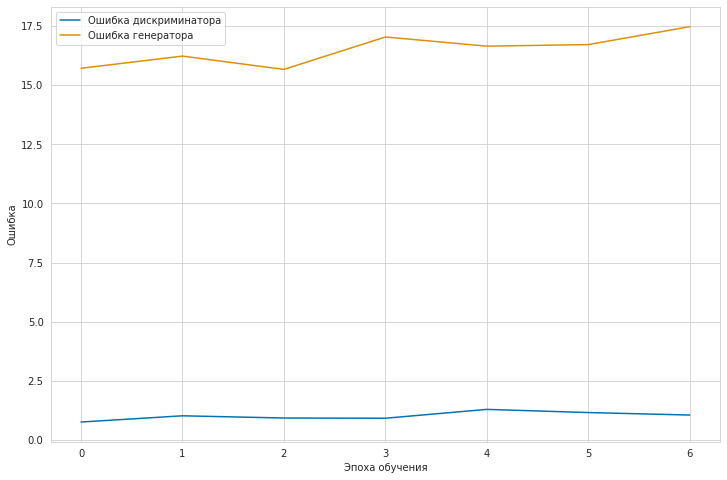

	...epoch 94/300	batch 0/7	D loss: 1.205020	G loss: 15.689034
	...epoch 94/300	batch 1/7	D loss: 0.773320	G loss: 16.497379
	...epoch 94/300	batch 2/7	D loss: 1.121375	G loss: 16.006504
	...epoch 94/300	batch 3/7	D loss: 1.034609	G loss: 17.434366
	...epoch 94/300	batch 4/7	D loss: 1.113678	G loss: 15.673548
	...epoch 94/300	batch 5/7	D loss: 1.044405	G loss: 15.460876
	...epoch 94/300	batch 6/7	D loss: 0.804059	G loss: 16.598553


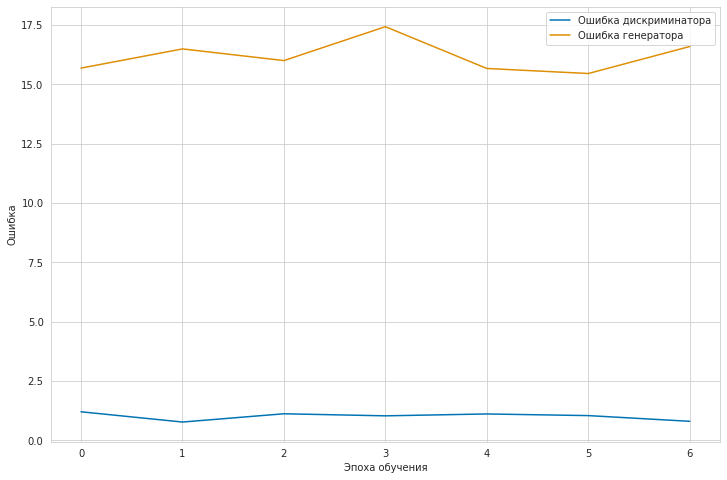

	...epoch 95/300	batch 0/7	D loss: 0.895314	G loss: 16.025307
	...epoch 95/300	batch 1/7	D loss: 1.104825	G loss: 15.892065
	...epoch 95/300	batch 2/7	D loss: 0.879467	G loss: 16.307657
	...epoch 95/300	batch 3/7	D loss: 0.887204	G loss: 15.563332
	...epoch 95/300	batch 4/7	D loss: 1.090968	G loss: 15.786460
	...epoch 95/300	batch 5/7	D loss: 1.041747	G loss: 16.137094
	...epoch 95/300	batch 6/7	D loss: 1.149343	G loss: 15.075383


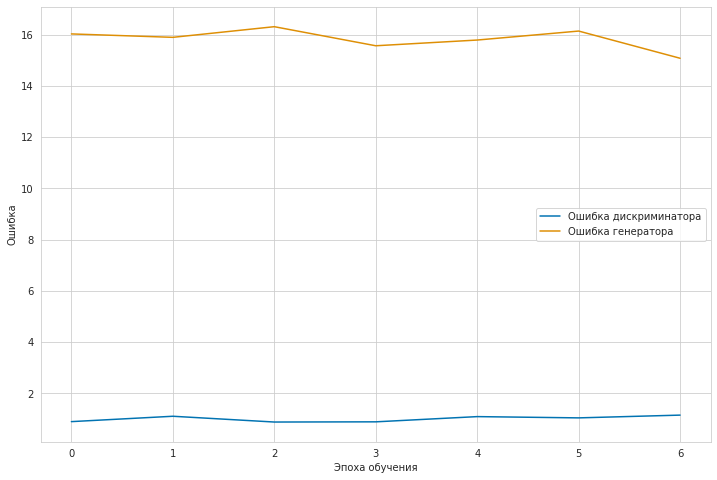

	...epoch 96/300	batch 0/7	D loss: 1.054492	G loss: 15.793229
	...epoch 96/300	batch 1/7	D loss: 0.987081	G loss: 15.847005
	...epoch 96/300	batch 2/7	D loss: 1.020767	G loss: 15.427041
	...epoch 96/300	batch 3/7	D loss: 0.906103	G loss: 16.072653
	...epoch 96/300	batch 4/7	D loss: 0.939905	G loss: 15.941929
	...epoch 96/300	batch 5/7	D loss: 1.049439	G loss: 15.408166
	...epoch 96/300	batch 6/7	D loss: 1.383182	G loss: 18.267399


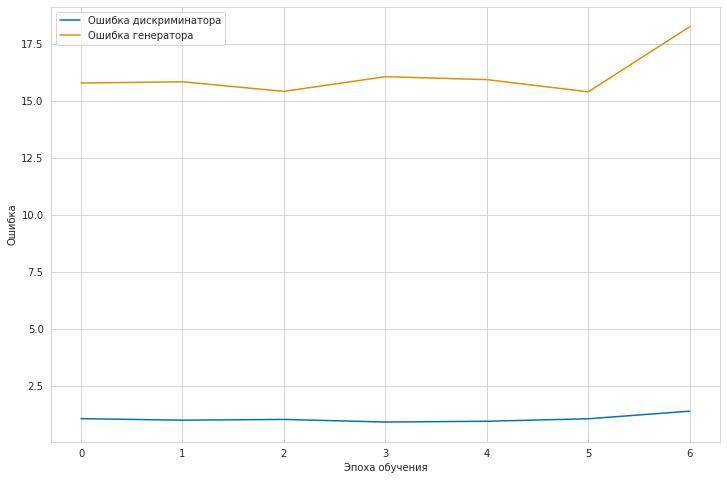

	...epoch 97/300	batch 0/7	D loss: 1.401389	G loss: 15.717896
	...epoch 97/300	batch 1/7	D loss: 0.877653	G loss: 15.589800
	...epoch 97/300	batch 2/7	D loss: 1.112874	G loss: 17.110329
	...epoch 97/300	batch 3/7	D loss: 1.534031	G loss: 14.771376
	...epoch 97/300	batch 4/7	D loss: 1.027516	G loss: 16.193687
	...epoch 97/300	batch 5/7	D loss: 0.874854	G loss: 15.300446
	...epoch 97/300	batch 6/7	D loss: 1.122212	G loss: 13.912420


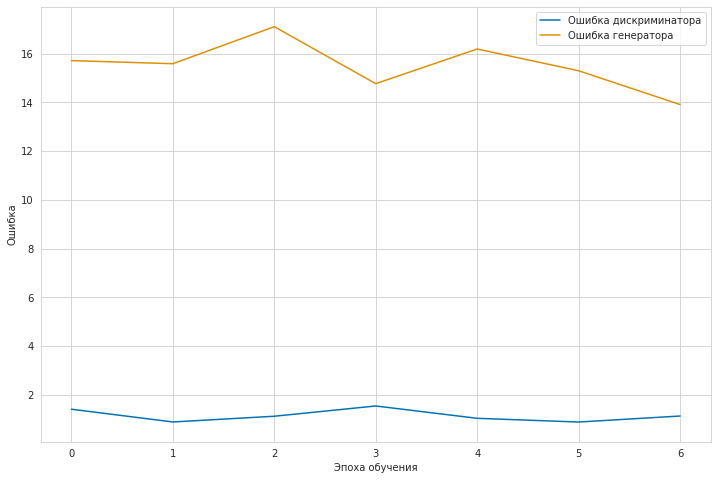

	...epoch 98/300	batch 0/7	D loss: 1.241927	G loss: 16.185181
	...epoch 98/300	batch 1/7	D loss: 0.846542	G loss: 16.031754
	...epoch 98/300	batch 2/7	D loss: 0.866408	G loss: 15.164536
	...epoch 98/300	batch 3/7	D loss: 1.190512	G loss: 16.596586
	...epoch 98/300	batch 4/7	D loss: 1.887673	G loss: 16.079918
	...epoch 98/300	batch 5/7	D loss: 1.725786	G loss: 17.480946
	...epoch 98/300	batch 6/7	D loss: 8.846731	G loss: 17.792576


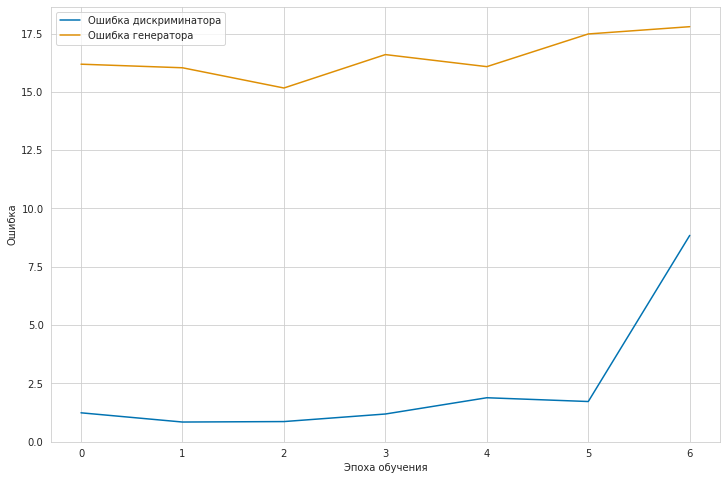

	...epoch 99/300	batch 0/7	D loss: 2.141635	G loss: 16.678526
	...epoch 99/300	batch 1/7	D loss: 1.966684	G loss: 15.513757
	...epoch 99/300	batch 2/7	D loss: 1.652604	G loss: 16.369907
	...epoch 99/300	batch 3/7	D loss: 0.883555	G loss: 15.493361
	...epoch 99/300	batch 4/7	D loss: 0.919750	G loss: 15.131711
	...epoch 99/300	batch 5/7	D loss: 0.895954	G loss: 15.104420
	...epoch 99/300	batch 6/7	D loss: 1.007089	G loss: 14.463107


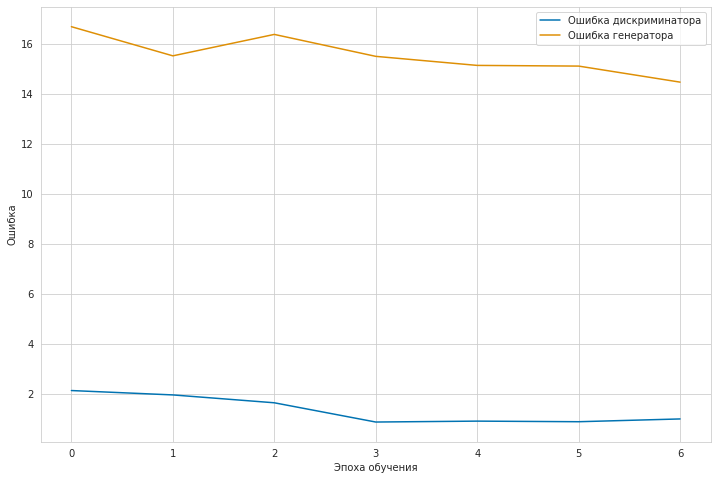

	...epoch 100/300	batch 0/7	D loss: 0.942032	G loss: 16.455051
	...epoch 100/300	batch 1/7	D loss: 0.888509	G loss: 15.681970
	...epoch 100/300	batch 2/7	D loss: 0.959278	G loss: 14.949056
	...epoch 100/300	batch 3/7	D loss: 0.861808	G loss: 14.845710
	...epoch 100/300	batch 4/7	D loss: 0.941376	G loss: 14.784694
	...epoch 100/300	batch 5/7	D loss: 0.860540	G loss: 15.343208
	...epoch 100/300	batch 6/7	D loss: 0.936191	G loss: 15.294201


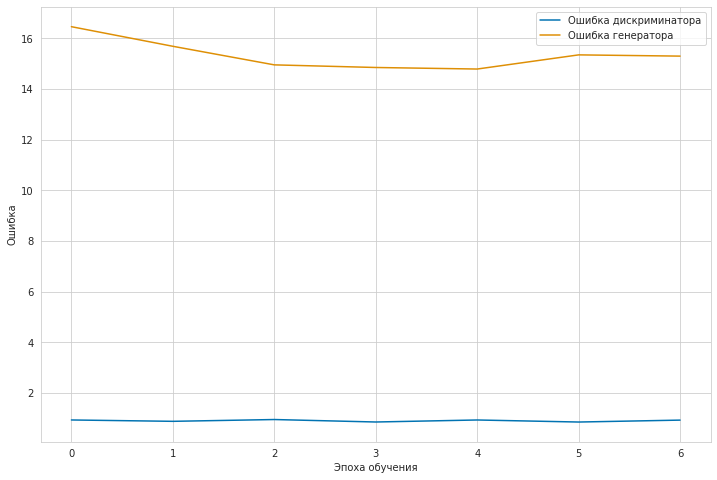

	...epoch 101/300	batch 0/7	D loss: 1.057439	G loss: 16.528244
	...epoch 101/300	batch 1/7	D loss: 1.037835	G loss: 15.256850
	...epoch 101/300	batch 2/7	D loss: 0.900927	G loss: 15.371508
	...epoch 101/300	batch 3/7	D loss: 0.970821	G loss: 15.046797
	...epoch 101/300	batch 4/7	D loss: 1.006947	G loss: 14.791589
	...epoch 101/300	batch 5/7	D loss: 0.838506	G loss: 15.896006
	...epoch 101/300	batch 6/7	D loss: 1.001058	G loss: 15.480823


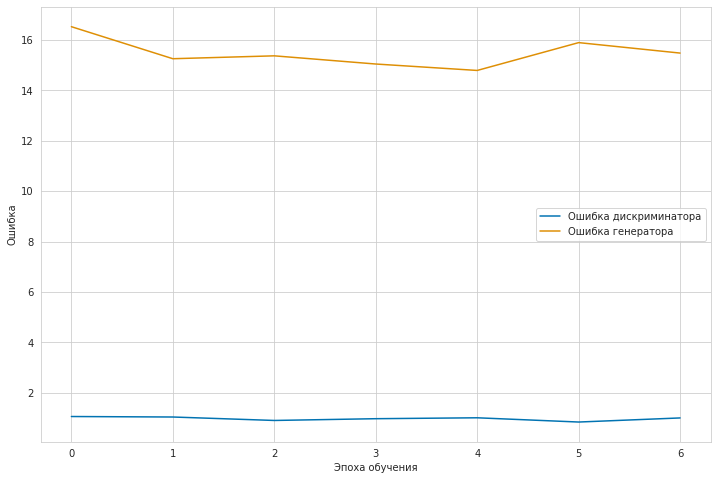

	...epoch 102/300	batch 0/7	D loss: 0.989401	G loss: 15.379039
	...epoch 102/300	batch 1/7	D loss: 1.169485	G loss: 15.130042
	...epoch 102/300	batch 2/7	D loss: 1.003870	G loss: 16.105925
	...epoch 102/300	batch 3/7	D loss: 1.122409	G loss: 16.199646
	...epoch 102/300	batch 4/7	D loss: 1.255901	G loss: 14.620524
	...epoch 102/300	batch 5/7	D loss: 0.808767	G loss: 15.205881
	...epoch 102/300	batch 6/7	D loss: 0.748437	G loss: 16.098171


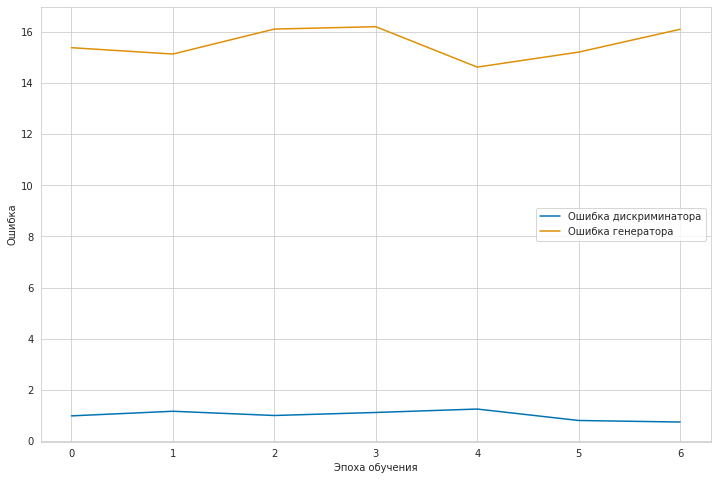

	...epoch 103/300	batch 0/7	D loss: 1.278704	G loss: 15.260626
	...epoch 103/300	batch 1/7	D loss: 1.023164	G loss: 15.744232
	...epoch 103/300	batch 2/7	D loss: 0.923961	G loss: 15.859015
	...epoch 103/300	batch 3/7	D loss: 1.258721	G loss: 16.005638
	...epoch 103/300	batch 4/7	D loss: 1.129518	G loss: 15.673645
	...epoch 103/300	batch 5/7	D loss: 1.205787	G loss: 14.826049
	...epoch 103/300	batch 6/7	D loss: 0.993030	G loss: 15.728913


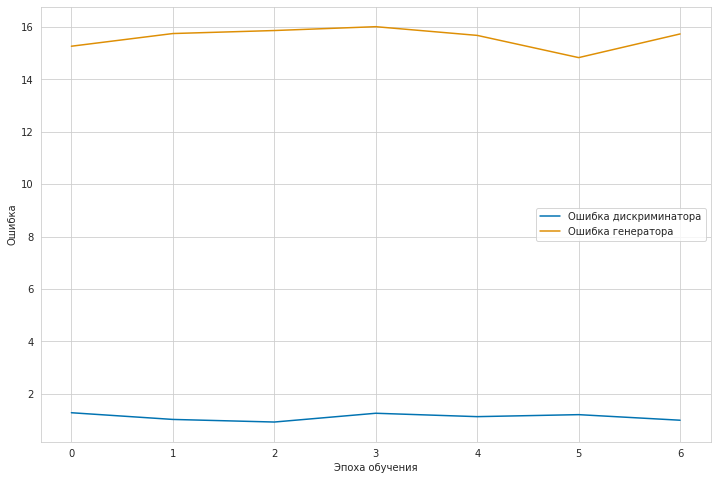

	...epoch 104/300	batch 0/7	D loss: 0.990860	G loss: 15.269714
	...epoch 104/300	batch 1/7	D loss: 1.213589	G loss: 14.865172
	...epoch 104/300	batch 2/7	D loss: 0.986396	G loss: 15.841600
	...epoch 104/300	batch 3/7	D loss: 0.894230	G loss: 14.911537
	...epoch 104/300	batch 4/7	D loss: 1.138143	G loss: 15.933190
	...epoch 104/300	batch 5/7	D loss: 1.257558	G loss: 14.946194
	...epoch 104/300	batch 6/7	D loss: 1.125774	G loss: 17.147387


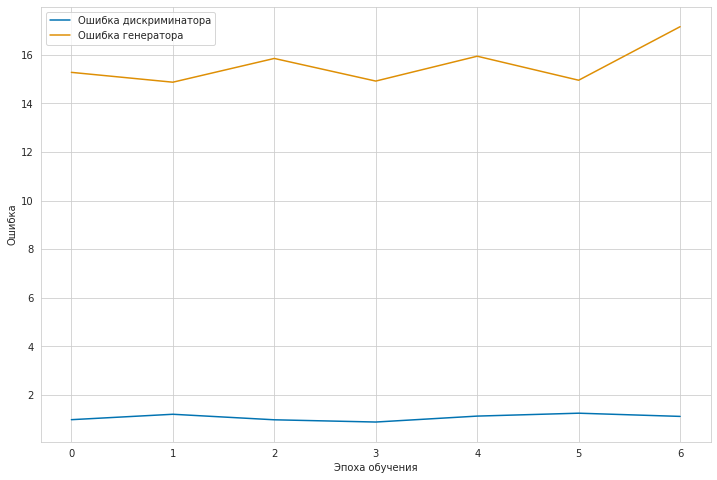

	...epoch 105/300	batch 0/7	D loss: 1.108389	G loss: 16.269333
	...epoch 105/300	batch 1/7	D loss: 1.209559	G loss: 15.363167
	...epoch 105/300	batch 2/7	D loss: 0.986878	G loss: 15.857533
	...epoch 105/300	batch 3/7	D loss: 1.015360	G loss: 14.990870
	...epoch 105/300	batch 4/7	D loss: 1.056894	G loss: 15.088264
	...epoch 105/300	batch 5/7	D loss: 1.108148	G loss: 14.592031
	...epoch 105/300	batch 6/7	D loss: 1.379234	G loss: 18.496939


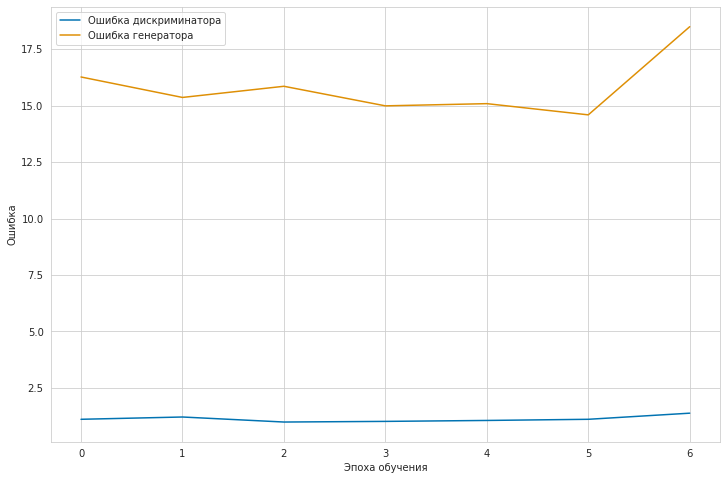

	...epoch 106/300	batch 0/7	D loss: 1.887615	G loss: 15.865049
	...epoch 106/300	batch 1/7	D loss: 0.951638	G loss: 15.238043
	...epoch 106/300	batch 2/7	D loss: 1.153770	G loss: 15.138610
	...epoch 106/300	batch 3/7	D loss: 1.105160	G loss: 14.213794
	...epoch 106/300	batch 4/7	D loss: 0.900420	G loss: 14.353928
	...epoch 106/300	batch 5/7	D loss: 0.991129	G loss: 15.436826
	...epoch 106/300	batch 6/7	D loss: 0.675983	G loss: 15.487356


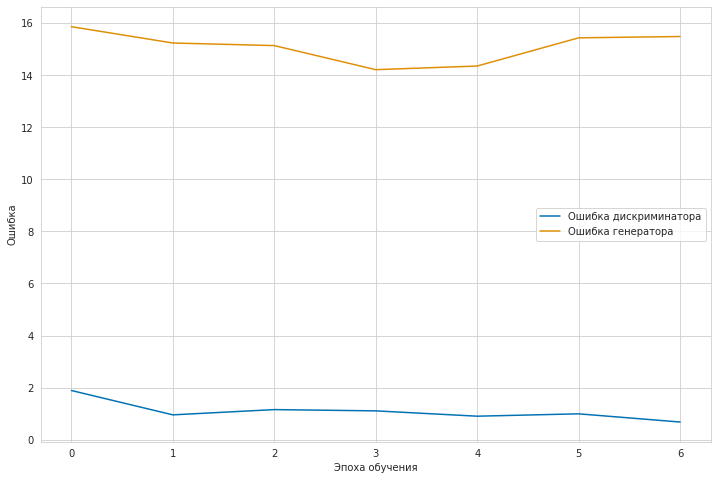

	...epoch 107/300	batch 0/7	D loss: 1.080168	G loss: 15.753092
	...epoch 107/300	batch 1/7	D loss: 1.091955	G loss: 16.162348
	...epoch 107/300	batch 2/7	D loss: 1.098842	G loss: 14.102289
	...epoch 107/300	batch 3/7	D loss: 1.298799	G loss: 15.498802
	...epoch 107/300	batch 4/7	D loss: 0.982445	G loss: 14.925227
	...epoch 107/300	batch 5/7	D loss: 1.021286	G loss: 15.549541
	...epoch 107/300	batch 6/7	D loss: 0.978110	G loss: 15.888869


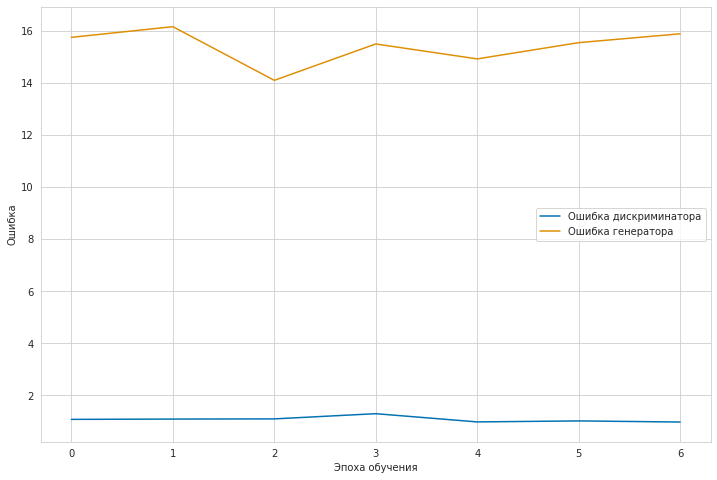

	...epoch 108/300	batch 0/7	D loss: 0.828648	G loss: 15.651243
	...epoch 108/300	batch 1/7	D loss: 1.033206	G loss: 16.910172
	...epoch 108/300	batch 2/7	D loss: 1.141315	G loss: 15.665758
	...epoch 108/300	batch 3/7	D loss: 1.330070	G loss: 14.533039
	...epoch 108/300	batch 4/7	D loss: 1.069095	G loss: 15.610757
	...epoch 108/300	batch 5/7	D loss: 1.207676	G loss: 14.174595
	...epoch 108/300	batch 6/7	D loss: 1.285260	G loss: 16.937382


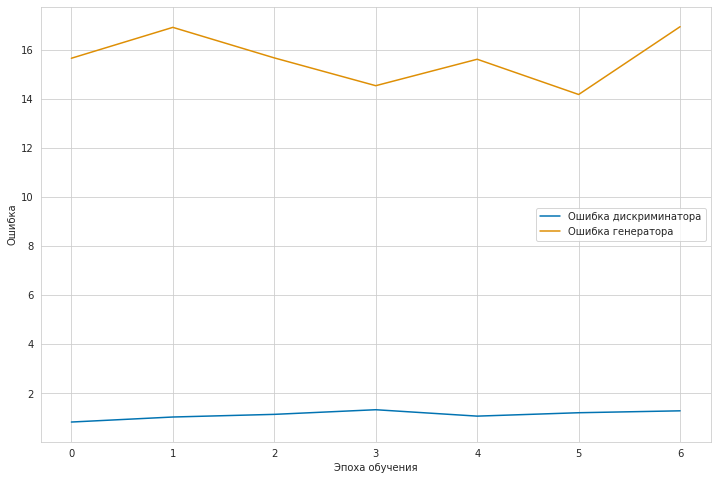

	...epoch 109/300	batch 0/7	D loss: 1.408423	G loss: 14.889241
	...epoch 109/300	batch 1/7	D loss: 1.150448	G loss: 14.964505
	...epoch 109/300	batch 2/7	D loss: 0.971702	G loss: 14.712624
	...epoch 109/300	batch 3/7	D loss: 0.885616	G loss: 14.821771
	...epoch 109/300	batch 4/7	D loss: 1.018147	G loss: 14.448586
	...epoch 109/300	batch 5/7	D loss: 0.944286	G loss: 15.201368
	...epoch 109/300	batch 6/7	D loss: 0.905474	G loss: 15.132929


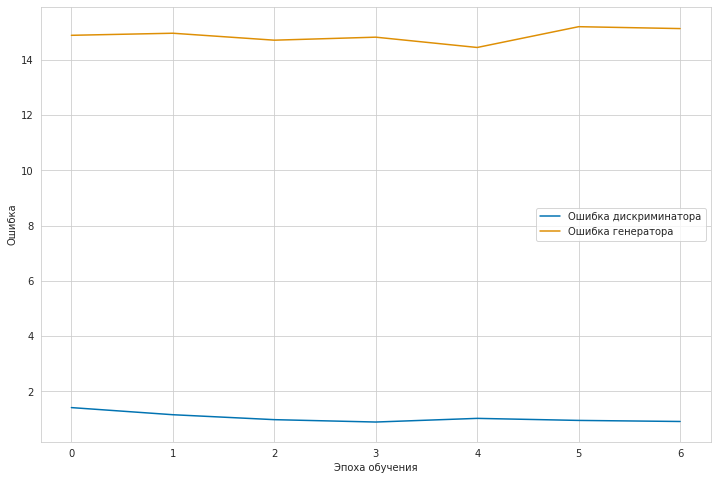

	...epoch 110/300	batch 0/7	D loss: 1.074012	G loss: 14.992294
	...epoch 110/300	batch 1/7	D loss: 0.975826	G loss: 16.119036
	...epoch 110/300	batch 2/7	D loss: 1.069642	G loss: 14.673442
	...epoch 110/300	batch 3/7	D loss: 0.972421	G loss: 13.921429
	...epoch 110/300	batch 4/7	D loss: 1.365751	G loss: 15.864672
	...epoch 110/300	batch 5/7	D loss: 1.523159	G loss: 14.252358
	...epoch 110/300	batch 6/7	D loss: 1.165872	G loss: 13.658278


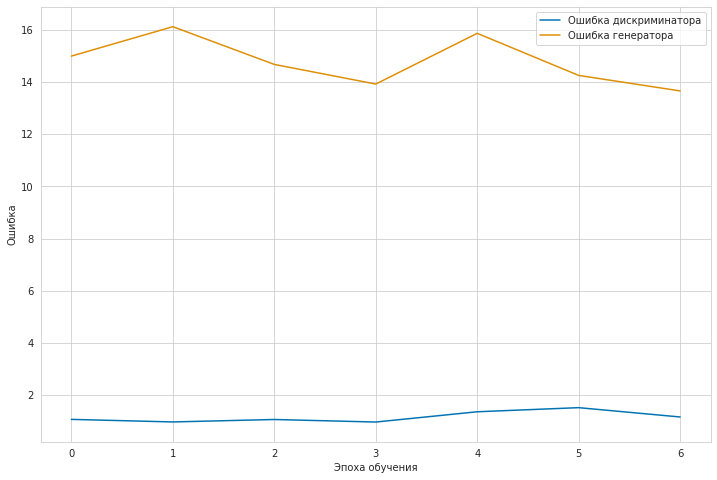

	...epoch 111/300	batch 0/7	D loss: 0.902391	G loss: 15.882116
	...epoch 111/300	batch 1/7	D loss: 0.888692	G loss: 14.938120
	...epoch 111/300	batch 2/7	D loss: 0.931874	G loss: 14.794733
	...epoch 111/300	batch 3/7	D loss: 0.905954	G loss: 14.093286
	...epoch 111/300	batch 4/7	D loss: 0.916439	G loss: 14.819999
	...epoch 111/300	batch 5/7	D loss: 1.133504	G loss: 14.487310
	...epoch 111/300	batch 6/7	D loss: 1.415091	G loss: 15.185533


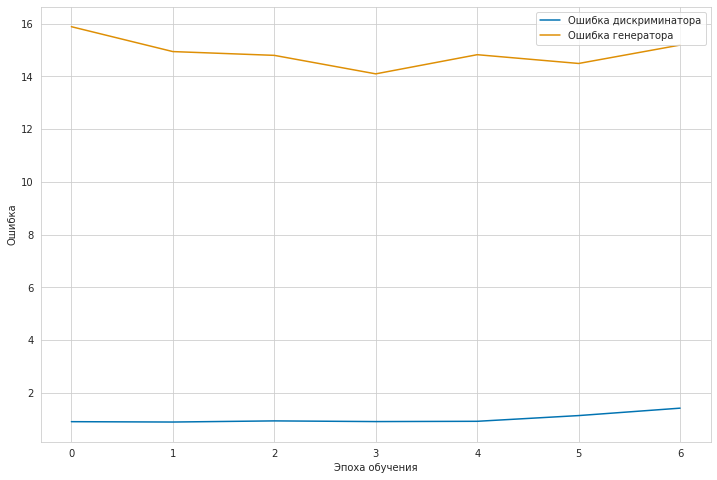

	...epoch 112/300	batch 0/7	D loss: 1.025953	G loss: 15.020935
	...epoch 112/300	batch 1/7	D loss: 0.927832	G loss: 15.431099
	...epoch 112/300	batch 2/7	D loss: 1.163138	G loss: 14.618077
	...epoch 112/300	batch 3/7	D loss: 1.003692	G loss: 15.921914
	...epoch 112/300	batch 4/7	D loss: 1.065069	G loss: 15.445419
	...epoch 112/300	batch 5/7	D loss: 0.894609	G loss: 14.356545
	...epoch 112/300	batch 6/7	D loss: 1.430564	G loss: 18.433079


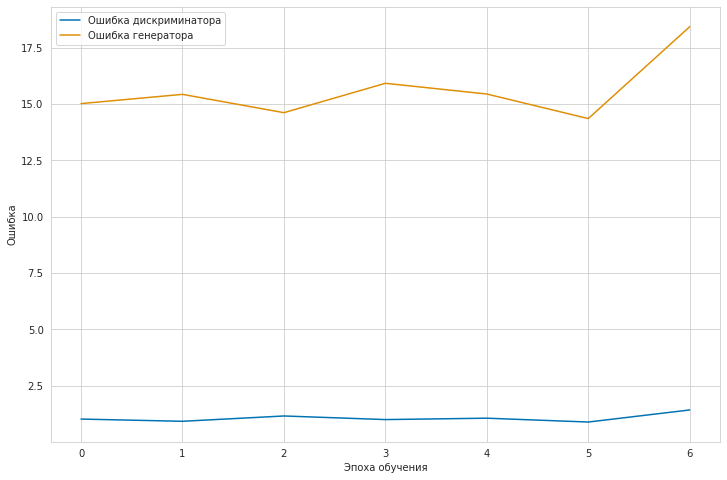

	...epoch 113/300	batch 0/7	D loss: 1.362686	G loss: 15.546580
	...epoch 113/300	batch 1/7	D loss: 1.015617	G loss: 15.581274
	...epoch 113/300	batch 2/7	D loss: 0.904050	G loss: 15.885676
	...epoch 113/300	batch 3/7	D loss: 0.990666	G loss: 15.413949
	...epoch 113/300	batch 4/7	D loss: 1.305309	G loss: 14.940902
	...epoch 113/300	batch 5/7	D loss: 0.889109	G loss: 15.186407
	...epoch 113/300	batch 6/7	D loss: 1.332739	G loss: 15.445554


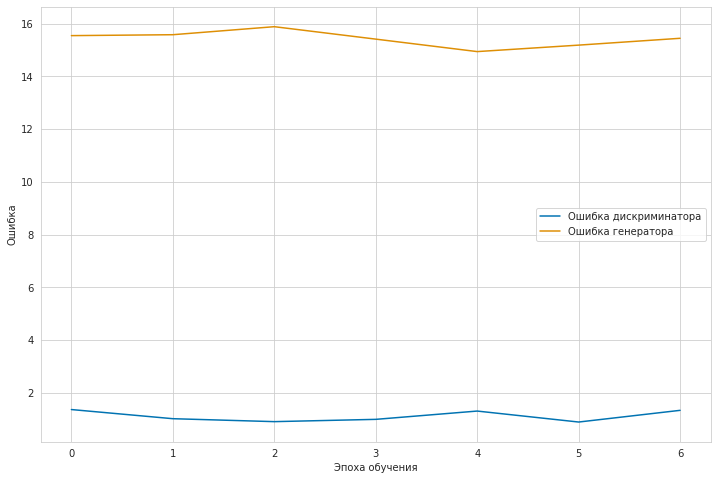

	...epoch 114/300	batch 0/7	D loss: 1.260346	G loss: 14.522132
	...epoch 114/300	batch 1/7	D loss: 1.053440	G loss: 14.096437
	...epoch 114/300	batch 2/7	D loss: 0.966840	G loss: 15.036313
	...epoch 114/300	batch 3/7	D loss: 0.958873	G loss: 14.890632
	...epoch 114/300	batch 4/7	D loss: 0.939909	G loss: 13.938416
	...epoch 114/300	batch 5/7	D loss: 1.063537	G loss: 14.761884
	...epoch 114/300	batch 6/7	D loss: 1.057135	G loss: 14.116572


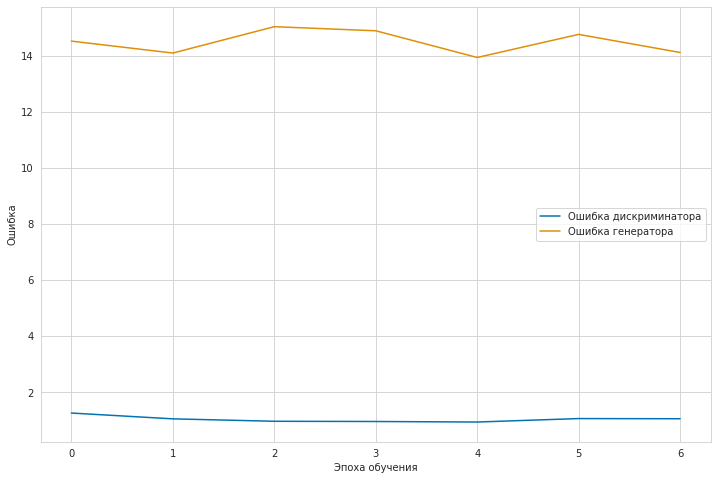

	...epoch 115/300	batch 0/7	D loss: 1.254867	G loss: 15.378647
	...epoch 115/300	batch 1/7	D loss: 0.995266	G loss: 14.855970
	...epoch 115/300	batch 2/7	D loss: 1.007173	G loss: 14.013988
	...epoch 115/300	batch 3/7	D loss: 1.124209	G loss: 15.264597
	...epoch 115/300	batch 4/7	D loss: 1.069934	G loss: 14.194360
	...epoch 115/300	batch 5/7	D loss: 1.085061	G loss: 14.464662
	...epoch 115/300	batch 6/7	D loss: 1.174047	G loss: 14.450851


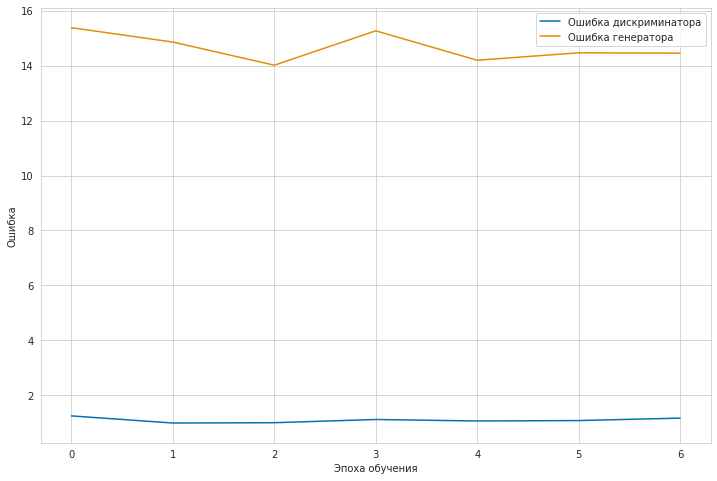

	...epoch 116/300	batch 0/7	D loss: 1.035543	G loss: 14.792405
	...epoch 116/300	batch 1/7	D loss: 0.894613	G loss: 15.131669
	...epoch 116/300	batch 2/7	D loss: 1.191252	G loss: 14.532327
	...epoch 116/300	batch 3/7	D loss: 0.930007	G loss: 15.010794
	...epoch 116/300	batch 4/7	D loss: 1.045396	G loss: 14.629096
	...epoch 116/300	batch 5/7	D loss: 0.968446	G loss: 14.086858
	...epoch 116/300	batch 6/7	D loss: 1.276690	G loss: 15.394286


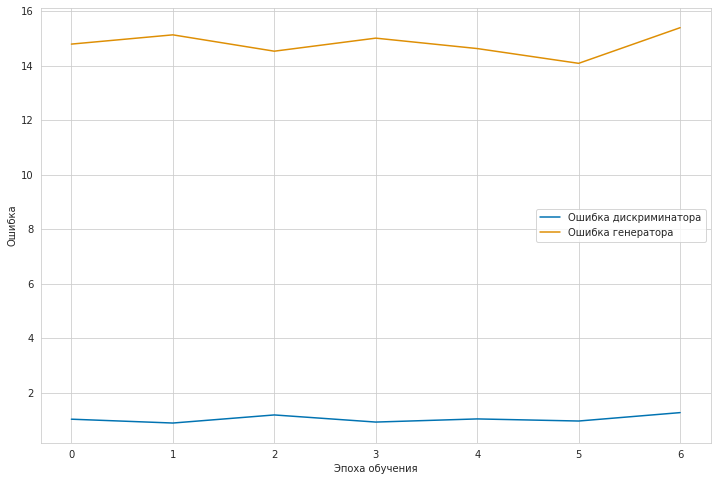

	...epoch 117/300	batch 0/7	D loss: 1.241902	G loss: 15.040654
	...epoch 117/300	batch 1/7	D loss: 0.963604	G loss: 13.726418
	...epoch 117/300	batch 2/7	D loss: 1.023631	G loss: 14.738127
	...epoch 117/300	batch 3/7	D loss: 1.230138	G loss: 14.135604
	...epoch 117/300	batch 4/7	D loss: 1.021356	G loss: 15.043941
	...epoch 117/300	batch 5/7	D loss: 1.334500	G loss: 13.870764
	...epoch 117/300	batch 6/7	D loss: 1.198172	G loss: 13.760729


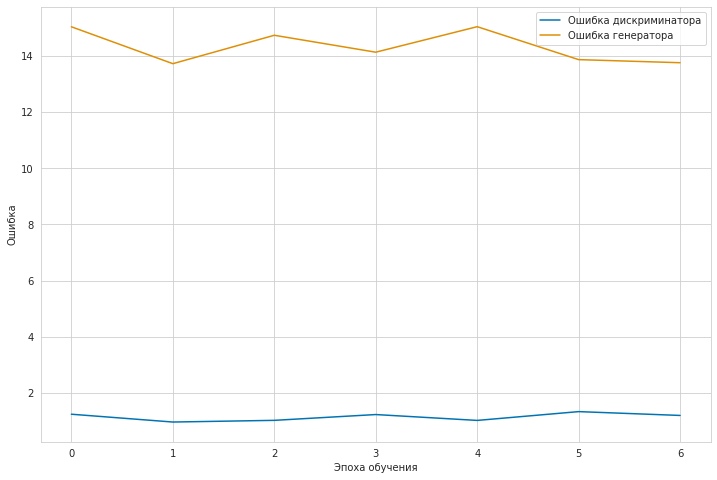

	...epoch 118/300	batch 0/7	D loss: 1.047543	G loss: 15.909773
	...epoch 118/300	batch 1/7	D loss: 1.098986	G loss: 14.043800
	...epoch 118/300	batch 2/7	D loss: 1.015698	G loss: 14.815543
	...epoch 118/300	batch 3/7	D loss: 1.084784	G loss: 13.885181
	...epoch 118/300	batch 4/7	D loss: 1.021951	G loss: 14.301448
	...epoch 118/300	batch 5/7	D loss: 1.056730	G loss: 13.933973
	...epoch 118/300	batch 6/7	D loss: 1.117601	G loss: 14.822418


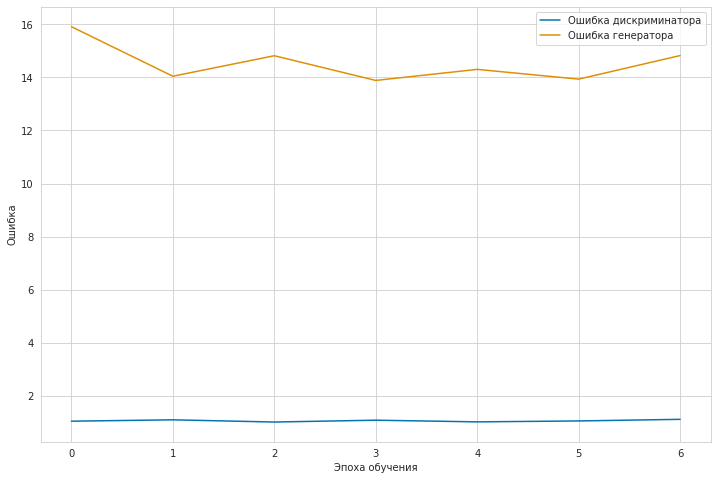

	...epoch 119/300	batch 0/7	D loss: 1.252387	G loss: 15.768751
	...epoch 119/300	batch 1/7	D loss: 1.127646	G loss: 13.911365
	...epoch 119/300	batch 2/7	D loss: 1.086892	G loss: 14.572708
	...epoch 119/300	batch 3/7	D loss: 1.046284	G loss: 14.495493
	...epoch 119/300	batch 4/7	D loss: 1.025477	G loss: 14.553478
	...epoch 119/300	batch 5/7	D loss: 0.969638	G loss: 14.583055
	...epoch 119/300	batch 6/7	D loss: 1.322287	G loss: 13.992455


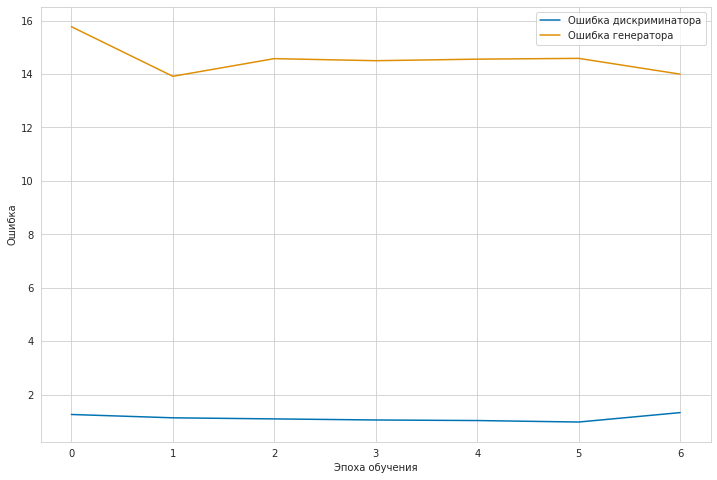

	...epoch 120/300	batch 0/7	D loss: 1.214288	G loss: 15.915548
	...epoch 120/300	batch 1/7	D loss: 1.421902	G loss: 14.112275
	...epoch 120/300	batch 2/7	D loss: 1.020546	G loss: 14.323508
	...epoch 120/300	batch 3/7	D loss: 0.871964	G loss: 14.773108
	...epoch 120/300	batch 4/7	D loss: 1.000256	G loss: 13.666375
	...epoch 120/300	batch 5/7	D loss: 1.147754	G loss: 14.381895
	...epoch 120/300	batch 6/7	D loss: 1.492141	G loss: 15.996301


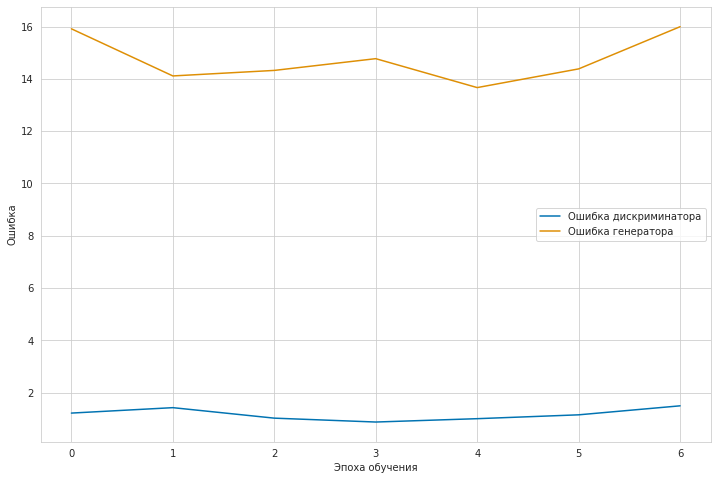

	...epoch 121/300	batch 0/7	D loss: 1.260701	G loss: 14.357515
	...epoch 121/300	batch 1/7	D loss: 1.157106	G loss: 14.105201
	...epoch 121/300	batch 2/7	D loss: 1.153126	G loss: 15.078151
	...epoch 121/300	batch 3/7	D loss: 0.940141	G loss: 14.247706
	...epoch 121/300	batch 4/7	D loss: 0.950670	G loss: 14.375328
	...epoch 121/300	batch 5/7	D loss: 0.988755	G loss: 14.318012
	...epoch 121/300	batch 6/7	D loss: 1.094328	G loss: 14.659671


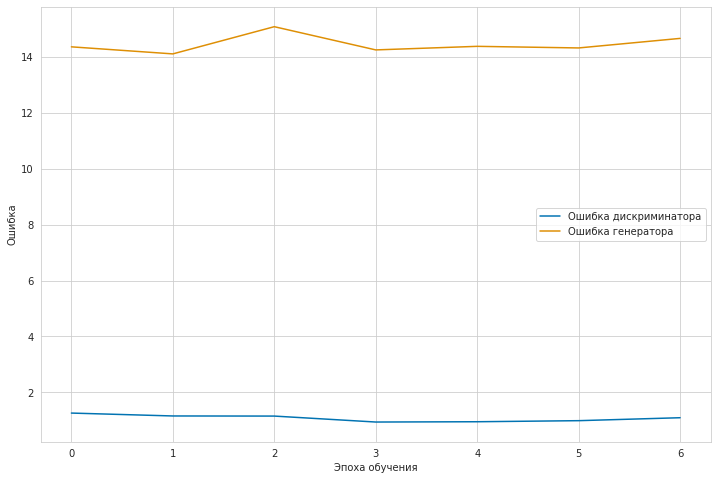

	...epoch 122/300	batch 0/7	D loss: 0.929027	G loss: 14.557747
	...epoch 122/300	batch 1/7	D loss: 0.931520	G loss: 15.223007
	...epoch 122/300	batch 2/7	D loss: 1.399519	G loss: 14.484468
	...epoch 122/300	batch 3/7	D loss: 0.967516	G loss: 13.668243
	...epoch 122/300	batch 4/7	D loss: 0.976199	G loss: 13.906188
	...epoch 122/300	batch 5/7	D loss: 0.976546	G loss: 14.798166
	...epoch 122/300	batch 6/7	D loss: 1.274195	G loss: 15.076163


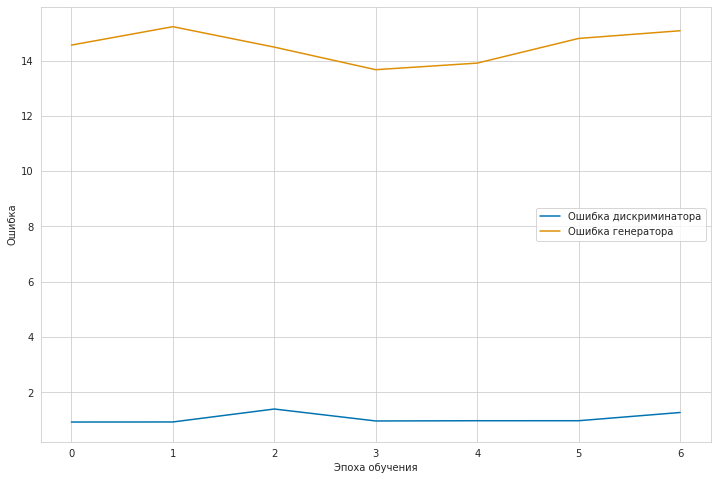

	...epoch 123/300	batch 0/7	D loss: 0.991147	G loss: 14.179790
	...epoch 123/300	batch 1/7	D loss: 1.015957	G loss: 14.883882
	...epoch 123/300	batch 2/7	D loss: 0.948320	G loss: 14.449184
	...epoch 123/300	batch 3/7	D loss: 1.186953	G loss: 14.541378
	...epoch 123/300	batch 4/7	D loss: 1.096790	G loss: 14.216144
	...epoch 123/300	batch 5/7	D loss: 0.972234	G loss: 13.981038
	...epoch 123/300	batch 6/7	D loss: 1.088610	G loss: 15.297801


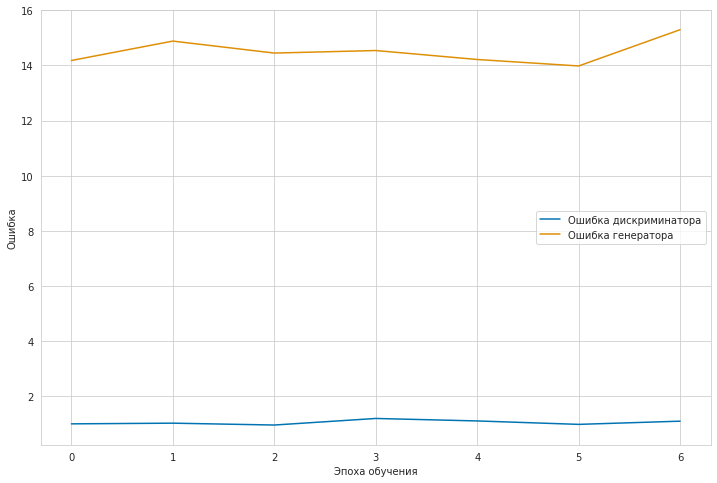

	...epoch 124/300	batch 0/7	D loss: 0.969282	G loss: 15.034840
	...epoch 124/300	batch 1/7	D loss: 1.297975	G loss: 14.663729
	...epoch 124/300	batch 2/7	D loss: 1.380602	G loss: 14.753656
	...epoch 124/300	batch 3/7	D loss: 0.917042	G loss: 14.436497
	...epoch 124/300	batch 4/7	D loss: 1.093901	G loss: 14.180952
	...epoch 124/300	batch 5/7	D loss: 0.959504	G loss: 15.024036
	...epoch 124/300	batch 6/7	D loss: 1.306480	G loss: 16.723171


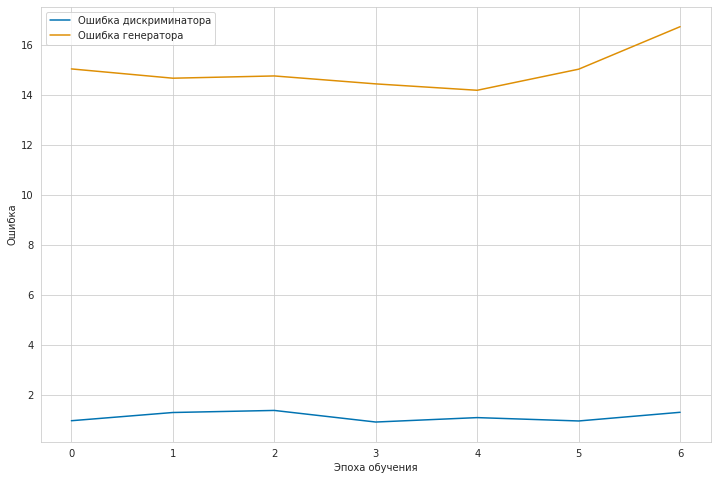

	...epoch 125/300	batch 0/7	D loss: 1.188398	G loss: 15.986533
	...epoch 125/300	batch 1/7	D loss: 1.150873	G loss: 15.354333
	...epoch 125/300	batch 2/7	D loss: 1.039557	G loss: 15.189865
	...epoch 125/300	batch 3/7	D loss: 1.175544	G loss: 14.054046
	...epoch 125/300	batch 4/7	D loss: 1.359185	G loss: 15.032011
	...epoch 125/300	batch 5/7	D loss: 1.321473	G loss: 14.156155
	...epoch 125/300	batch 6/7	D loss: 1.067302	G loss: 16.078577


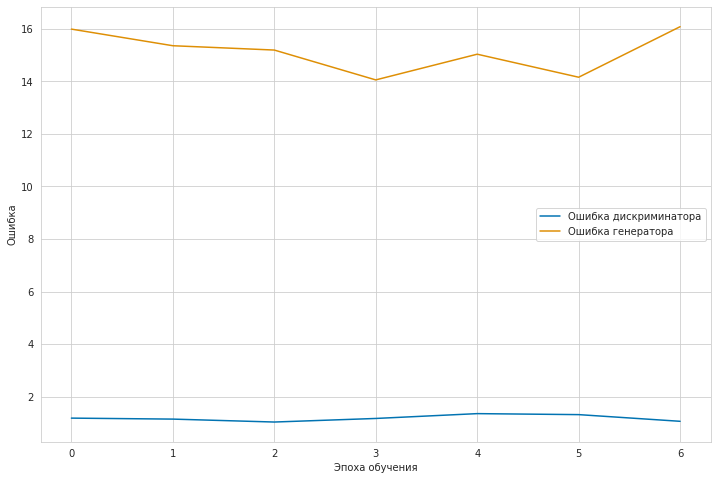

	...epoch 126/300	batch 0/7	D loss: 1.126129	G loss: 14.641150
	...epoch 126/300	batch 1/7	D loss: 1.241513	G loss: 14.674244
	...epoch 126/300	batch 2/7	D loss: 1.152448	G loss: 14.665545
	...epoch 126/300	batch 3/7	D loss: 0.988330	G loss: 14.292240
	...epoch 126/300	batch 4/7	D loss: 1.131144	G loss: 13.743956
	...epoch 126/300	batch 5/7	D loss: 0.929401	G loss: 14.550126
	...epoch 126/300	batch 6/7	D loss: 1.304200	G loss: 14.768468


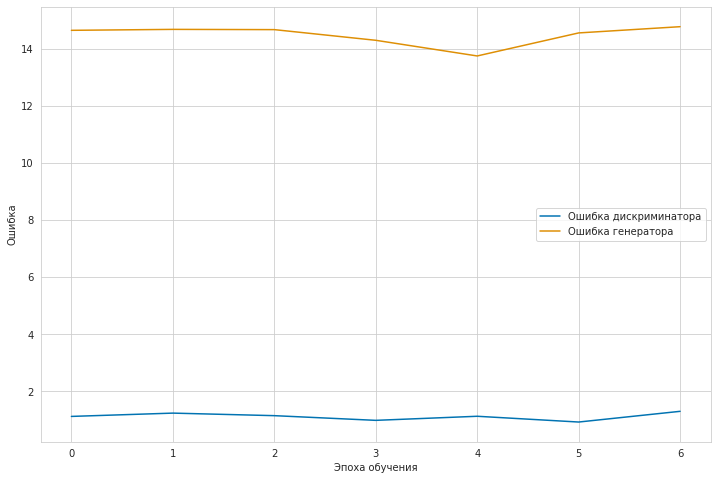

	...epoch 127/300	batch 0/7	D loss: 0.933553	G loss: 15.324869
	...epoch 127/300	batch 1/7	D loss: 1.005000	G loss: 14.697330
	...epoch 127/300	batch 2/7	D loss: 1.202306	G loss: 14.384076
	...epoch 127/300	batch 3/7	D loss: 0.909389	G loss: 13.584129
	...epoch 127/300	batch 4/7	D loss: 1.172117	G loss: 14.440906
	...epoch 127/300	batch 5/7	D loss: 1.441353	G loss: 13.341916
	...epoch 127/300	batch 6/7	D loss: 0.939306	G loss: 14.667356


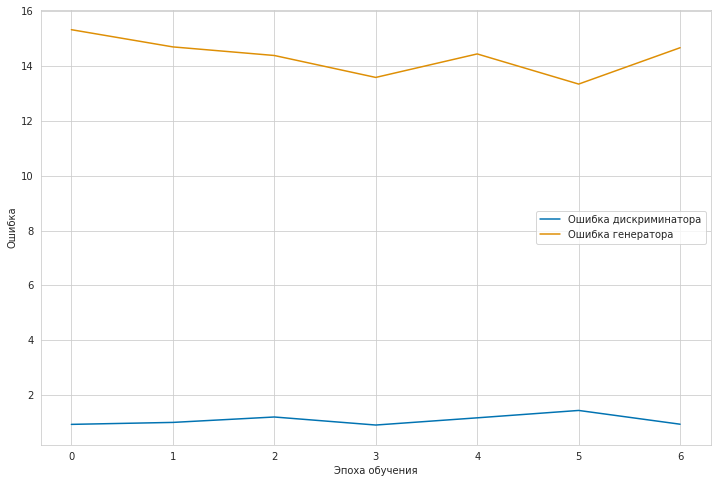

	...epoch 128/300	batch 0/7	D loss: 1.041502	G loss: 15.155550
	...epoch 128/300	batch 1/7	D loss: 1.281304	G loss: 14.182819
	...epoch 128/300	batch 2/7	D loss: 1.125935	G loss: 14.268231
	...epoch 128/300	batch 3/7	D loss: 1.113614	G loss: 13.510703
	...epoch 128/300	batch 4/7	D loss: 1.262049	G loss: 14.809940
	...epoch 128/300	batch 5/7	D loss: 1.270356	G loss: 14.147985
	...epoch 128/300	batch 6/7	D loss: 0.740145	G loss: 15.590882


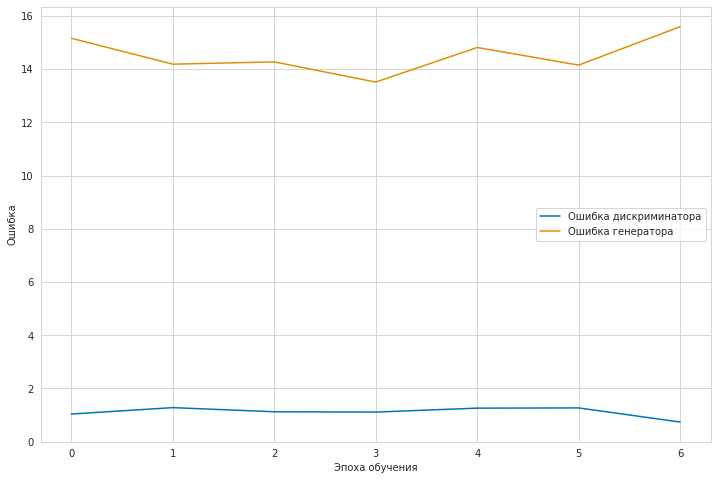

	...epoch 129/300	batch 0/7	D loss: 1.181447	G loss: 14.337318
	...epoch 129/300	batch 1/7	D loss: 1.432805	G loss: 14.030218
	...epoch 129/300	batch 2/7	D loss: 0.965838	G loss: 15.033627
	...epoch 129/300	batch 3/7	D loss: 0.935074	G loss: 14.143343
	...epoch 129/300	batch 4/7	D loss: 0.967567	G loss: 13.556648
	...epoch 129/300	batch 5/7	D loss: 1.011723	G loss: 14.041280
	...epoch 129/300	batch 6/7	D loss: 1.416326	G loss: 15.511409


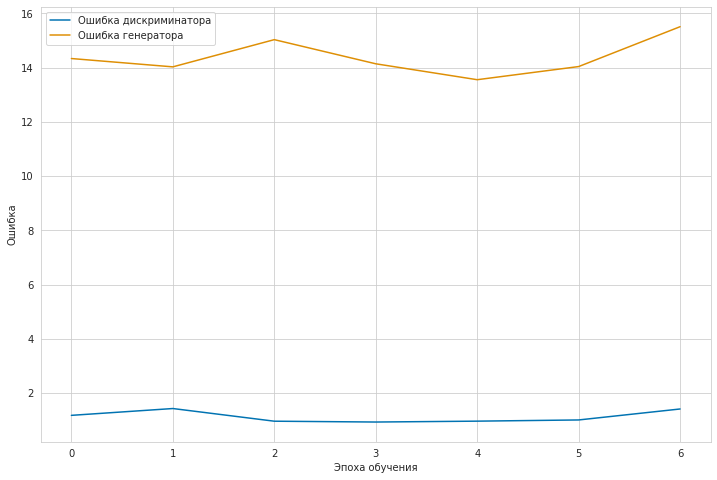

	...epoch 130/300	batch 0/7	D loss: 0.982480	G loss: 13.946203
	...epoch 130/300	batch 1/7	D loss: 1.087683	G loss: 15.572870
	...epoch 130/300	batch 2/7	D loss: 1.141274	G loss: 13.685804
	...epoch 130/300	batch 3/7	D loss: 0.912247	G loss: 13.701382
	...epoch 130/300	batch 4/7	D loss: 1.214033	G loss: 14.509541
	...epoch 130/300	batch 5/7	D loss: 1.151474	G loss: 13.377597
	...epoch 130/300	batch 6/7	D loss: 1.098240	G loss: 13.693241


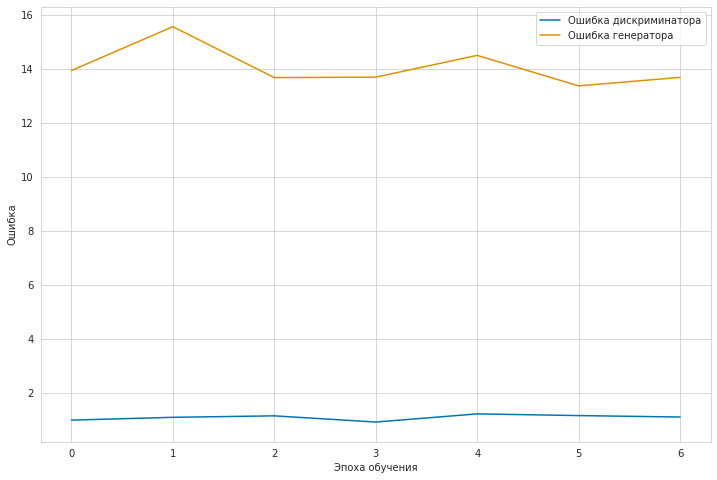

	...epoch 131/300	batch 0/7	D loss: 1.020940	G loss: 14.012322
	...epoch 131/300	batch 1/7	D loss: 1.111592	G loss: 14.719215
	...epoch 131/300	batch 2/7	D loss: 1.101612	G loss: 12.924212
	...epoch 131/300	batch 3/7	D loss: 1.178593	G loss: 14.646116
	...epoch 131/300	batch 4/7	D loss: 1.409589	G loss: 13.007019
	...epoch 131/300	batch 5/7	D loss: 1.049439	G loss: 12.974819
	...epoch 131/300	batch 6/7	D loss: 0.920147	G loss: 17.016424


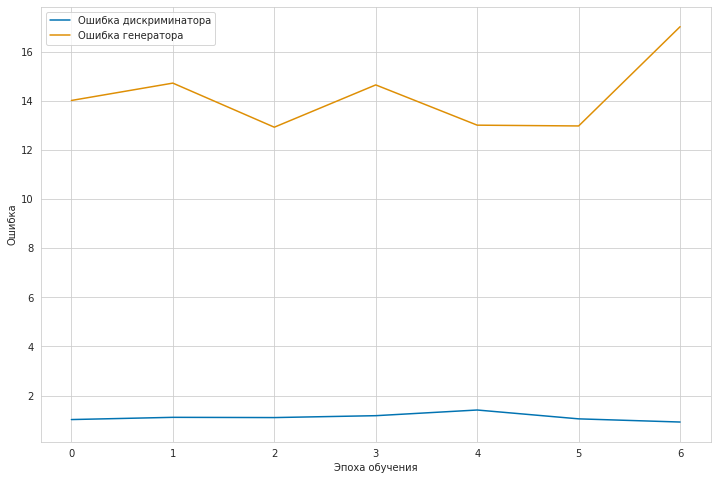

	...epoch 132/300	batch 0/7	D loss: 0.982671	G loss: 16.054432
	...epoch 132/300	batch 1/7	D loss: 1.074721	G loss: 14.781303
	...epoch 132/300	batch 2/7	D loss: 1.104582	G loss: 15.009999
	...epoch 132/300	batch 3/7	D loss: 0.989768	G loss: 14.189808
	...epoch 132/300	batch 4/7	D loss: 1.115268	G loss: 13.893328
	...epoch 132/300	batch 5/7	D loss: 1.066712	G loss: 14.197576
	...epoch 132/300	batch 6/7	D loss: 1.060164	G loss: 14.780151


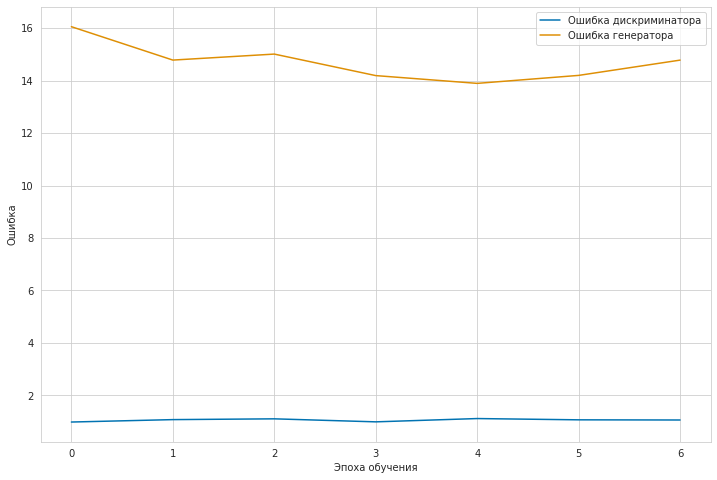

	...epoch 133/300	batch 0/7	D loss: 1.071730	G loss: 14.363770
	...epoch 133/300	batch 1/7	D loss: 1.161028	G loss: 14.951878
	...epoch 133/300	batch 2/7	D loss: 1.203966	G loss: 13.458614
	...epoch 133/300	batch 3/7	D loss: 1.133854	G loss: 14.769112
	...epoch 133/300	batch 4/7	D loss: 1.174412	G loss: 13.462834
	...epoch 133/300	batch 5/7	D loss: 1.097183	G loss: 13.951006
	...epoch 133/300	batch 6/7	D loss: 0.915170	G loss: 15.228648


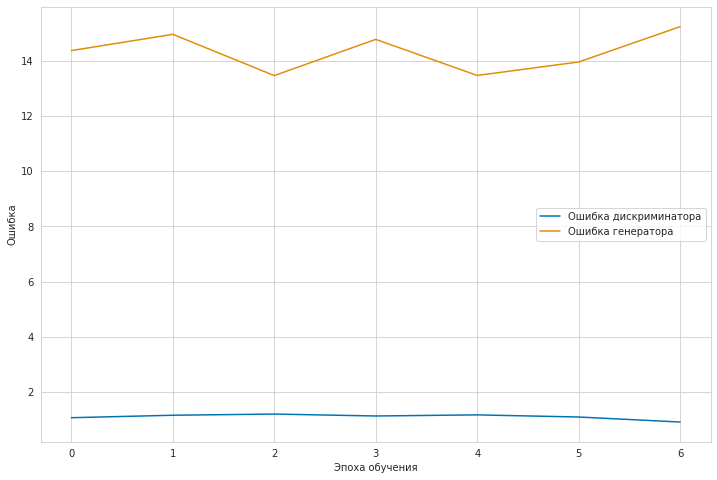

	...epoch 134/300	batch 0/7	D loss: 1.116186	G loss: 14.467347
	...epoch 134/300	batch 1/7	D loss: 0.967790	G loss: 13.876151
	...epoch 134/300	batch 2/7	D loss: 0.990559	G loss: 13.385048
	...epoch 134/300	batch 3/7	D loss: 1.189813	G loss: 13.565716
	...epoch 134/300	batch 4/7	D loss: 1.083987	G loss: 13.958111
	...epoch 134/300	batch 5/7	D loss: 1.114950	G loss: 13.540830
	...epoch 134/300	batch 6/7	D loss: 1.096671	G loss: 15.066822


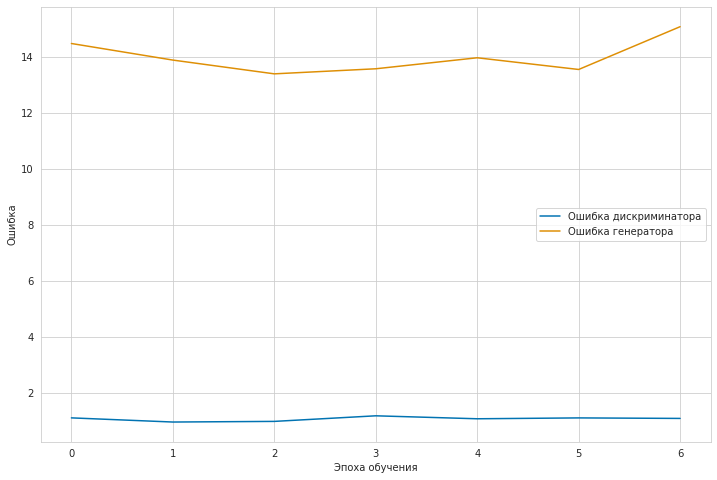

	...epoch 135/300	batch 0/7	D loss: 0.909214	G loss: 13.670570
	...epoch 135/300	batch 1/7	D loss: 1.187206	G loss: 14.678885
	...epoch 135/300	batch 2/7	D loss: 1.647735	G loss: 13.577262
	...epoch 135/300	batch 3/7	D loss: 1.091366	G loss: 13.295063
	...epoch 135/300	batch 4/7	D loss: 0.924883	G loss: 13.242834
	...epoch 135/300	batch 5/7	D loss: 1.185640	G loss: 13.905035
	...epoch 135/300	batch 6/7	D loss: 1.212699	G loss: 13.024765


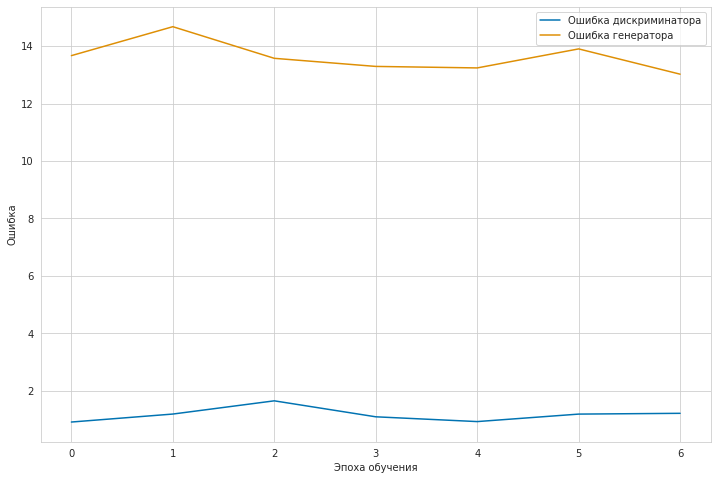

	...epoch 136/300	batch 0/7	D loss: 1.235876	G loss: 15.465694
	...epoch 136/300	batch 1/7	D loss: 1.095576	G loss: 13.344936
	...epoch 136/300	batch 2/7	D loss: 1.026869	G loss: 12.995079
	...epoch 136/300	batch 3/7	D loss: 0.960232	G loss: 13.881722
	...epoch 136/300	batch 4/7	D loss: 0.935541	G loss: 12.909308
	...epoch 136/300	batch 5/7	D loss: 1.113021	G loss: 14.063040
	...epoch 136/300	batch 6/7	D loss: 1.206409	G loss: 14.636612


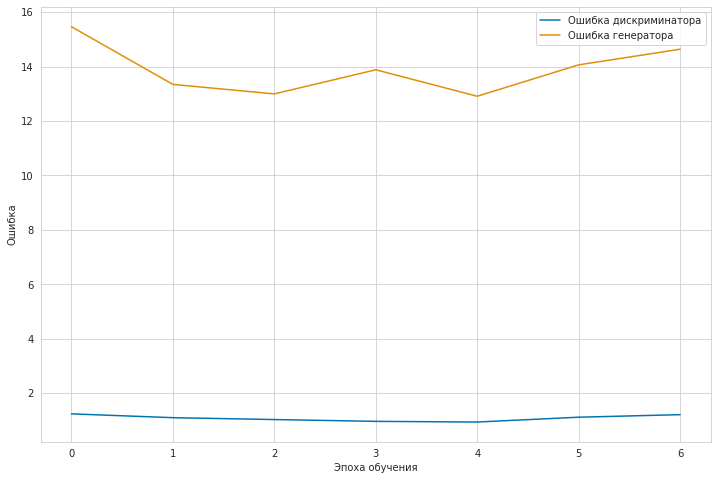

	...epoch 137/300	batch 0/7	D loss: 0.976054	G loss: 14.229465
	...epoch 137/300	batch 1/7	D loss: 1.064253	G loss: 13.716796
	...epoch 137/300	batch 2/7	D loss: 1.069041	G loss: 12.799049
	...epoch 137/300	batch 3/7	D loss: 1.092354	G loss: 13.538651
	...epoch 137/300	batch 4/7	D loss: 1.260643	G loss: 12.772994
	...epoch 137/300	batch 5/7	D loss: 1.013849	G loss: 13.830807
	...epoch 137/300	batch 6/7	D loss: 0.951203	G loss: 13.654077


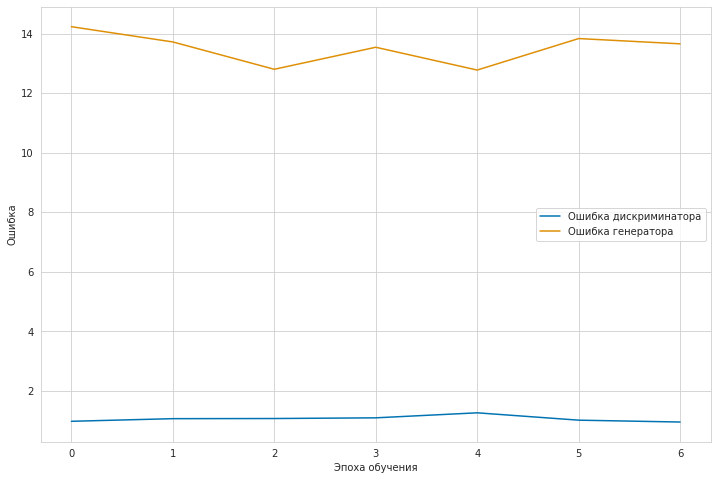

	...epoch 138/300	batch 0/7	D loss: 1.211513	G loss: 12.907455
	...epoch 138/300	batch 1/7	D loss: 0.970932	G loss: 14.350248
	...epoch 138/300	batch 2/7	D loss: 1.132644	G loss: 12.953691
	...epoch 138/300	batch 3/7	D loss: 1.006031	G loss: 13.507250
	...epoch 138/300	batch 4/7	D loss: 1.009054	G loss: 13.602001
	...epoch 138/300	batch 5/7	D loss: 0.808769	G loss: 13.035631
	...epoch 138/300	batch 6/7	D loss: 1.153810	G loss: 14.039699


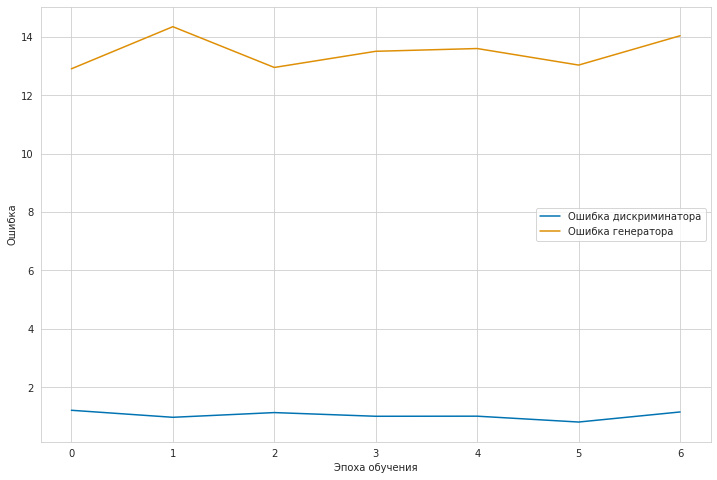

	...epoch 139/300	batch 0/7	D loss: 1.071565	G loss: 13.271767
	...epoch 139/300	batch 1/7	D loss: 1.010071	G loss: 13.524471
	...epoch 139/300	batch 2/7	D loss: 1.129647	G loss: 13.187294
	...epoch 139/300	batch 3/7	D loss: 0.900501	G loss: 14.071194
	...epoch 139/300	batch 4/7	D loss: 1.223929	G loss: 13.197229
	...epoch 139/300	batch 5/7	D loss: 0.993165	G loss: 13.362324
	...epoch 139/300	batch 6/7	D loss: 1.069534	G loss: 14.708523


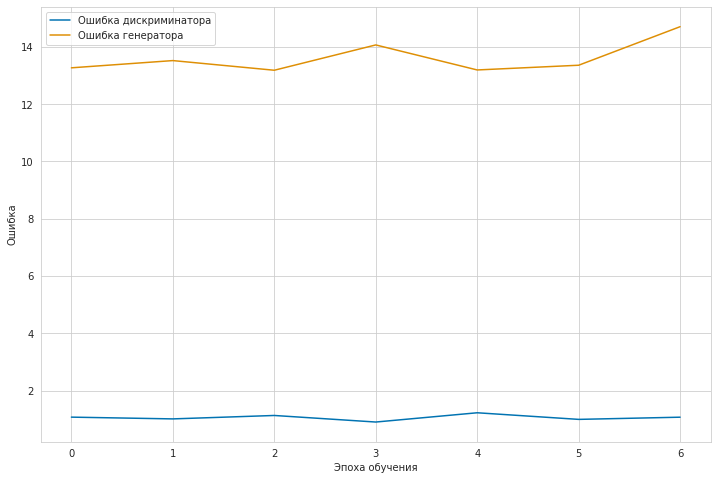

	...epoch 140/300	batch 0/7	D loss: 1.148833	G loss: 13.611286
	...epoch 140/300	batch 1/7	D loss: 0.978214	G loss: 13.015487
	...epoch 140/300	batch 2/7	D loss: 1.185152	G loss: 14.582521
	...epoch 140/300	batch 3/7	D loss: 1.688226	G loss: 12.865949
	...epoch 140/300	batch 4/7	D loss: 1.181010	G loss: 14.081016
	...epoch 140/300	batch 5/7	D loss: 1.089519	G loss: 13.212474
	...epoch 140/300	batch 6/7	D loss: 1.162555	G loss: 12.990122


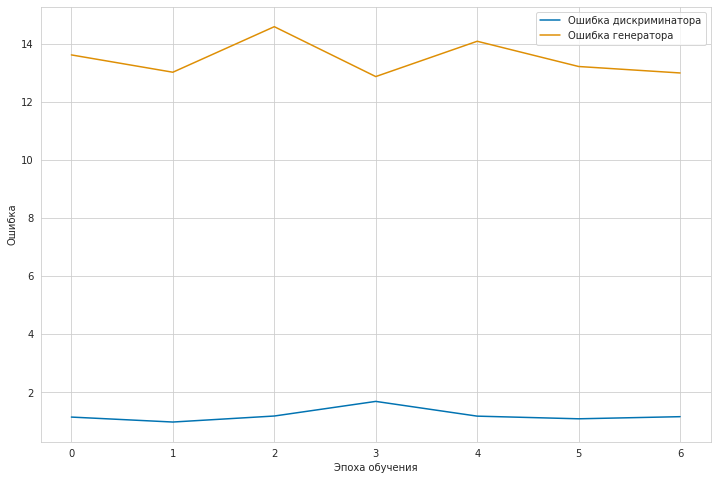

	...epoch 141/300	batch 0/7	D loss: 0.972711	G loss: 13.486522
	...epoch 141/300	batch 1/7	D loss: 1.081957	G loss: 13.464106
	...epoch 141/300	batch 2/7	D loss: 1.018095	G loss: 12.870135
	...epoch 141/300	batch 3/7	D loss: 0.968453	G loss: 14.007007
	...epoch 141/300	batch 4/7	D loss: 1.238971	G loss: 12.754808
	...epoch 141/300	batch 5/7	D loss: 0.987271	G loss: 13.420756
	...epoch 141/300	batch 6/7	D loss: 1.005190	G loss: 14.655735


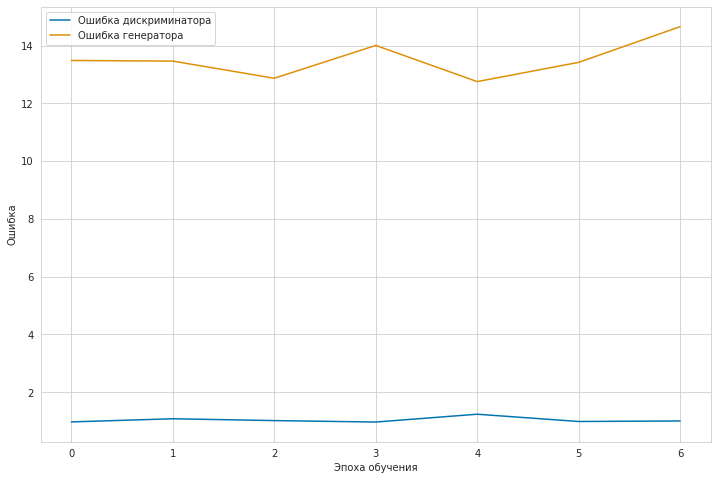

	...epoch 142/300	batch 0/7	D loss: 1.195505	G loss: 12.907410
	...epoch 142/300	batch 1/7	D loss: 1.017731	G loss: 12.799867
	...epoch 142/300	batch 2/7	D loss: 1.177180	G loss: 14.612715
	...epoch 142/300	batch 3/7	D loss: 1.396382	G loss: 13.629976
	...epoch 142/300	batch 4/7	D loss: 1.055022	G loss: 12.724838
	...epoch 142/300	batch 5/7	D loss: 0.895175	G loss: 13.055380
	...epoch 142/300	batch 6/7	D loss: 1.022381	G loss: 13.417856


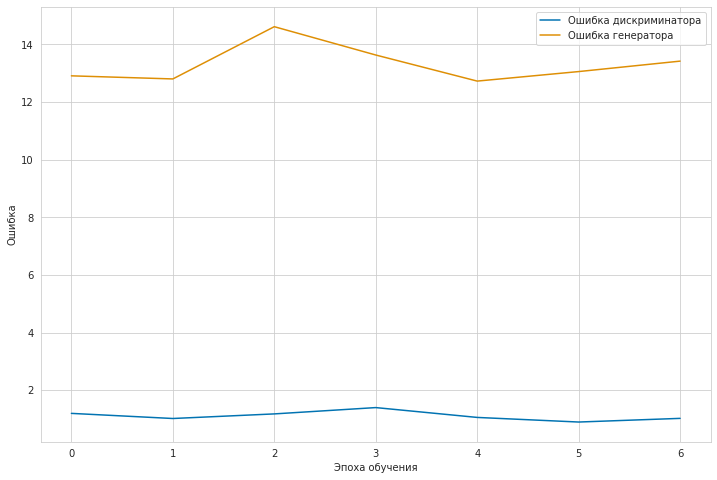

	...epoch 143/300	batch 0/7	D loss: 1.266577	G loss: 12.775486
	...epoch 143/300	batch 1/7	D loss: 0.950788	G loss: 12.971244
	...epoch 143/300	batch 2/7	D loss: 0.942727	G loss: 12.847438
	...epoch 143/300	batch 3/7	D loss: 1.007237	G loss: 13.829504
	...epoch 143/300	batch 4/7	D loss: 1.192013	G loss: 12.739438
	...epoch 143/300	batch 5/7	D loss: 1.275900	G loss: 13.748309
	...epoch 143/300	batch 6/7	D loss: 1.203745	G loss: 13.302201


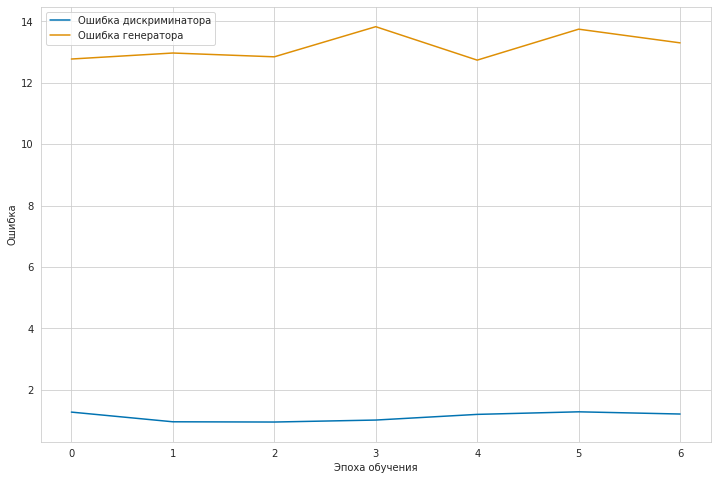

	...epoch 144/300	batch 0/7	D loss: 0.877544	G loss: 14.141213
	...epoch 144/300	batch 1/7	D loss: 1.079495	G loss: 14.500189
	...epoch 144/300	batch 2/7	D loss: 1.083834	G loss: 13.127401
	...epoch 144/300	batch 3/7	D loss: 1.103466	G loss: 12.646004
	...epoch 144/300	batch 4/7	D loss: 1.108222	G loss: 13.326777
	...epoch 144/300	batch 5/7	D loss: 1.098102	G loss: 13.659241
	...epoch 144/300	batch 6/7	D loss: 1.499834	G loss: 13.189028


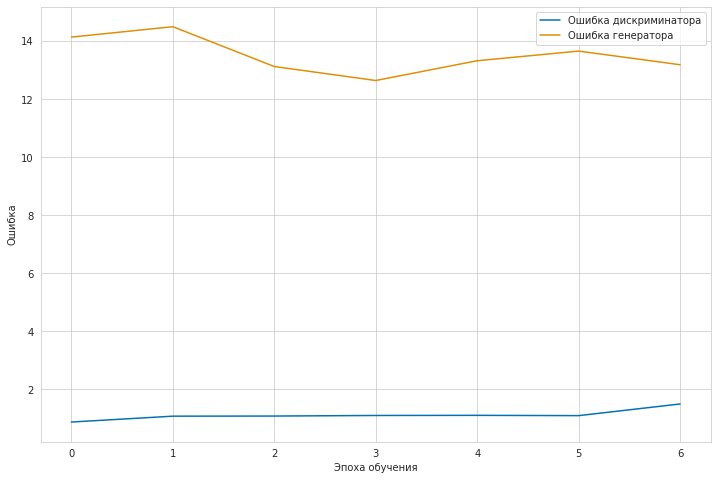

	...epoch 145/300	batch 0/7	D loss: 1.310182	G loss: 14.240170
	...epoch 145/300	batch 1/7	D loss: 1.855119	G loss: 14.074481
	...epoch 145/300	batch 2/7	D loss: 2.765364	G loss: 15.428777
	...epoch 145/300	batch 3/7	D loss: 12.600870	G loss: 15.487247
	...epoch 145/300	batch 4/7	D loss: 11.634809	G loss: 13.862674
	...epoch 145/300	batch 5/7	D loss: 2.082302	G loss: 12.727313
	...epoch 145/300	batch 6/7	D loss: 6.933296	G loss: 13.409836


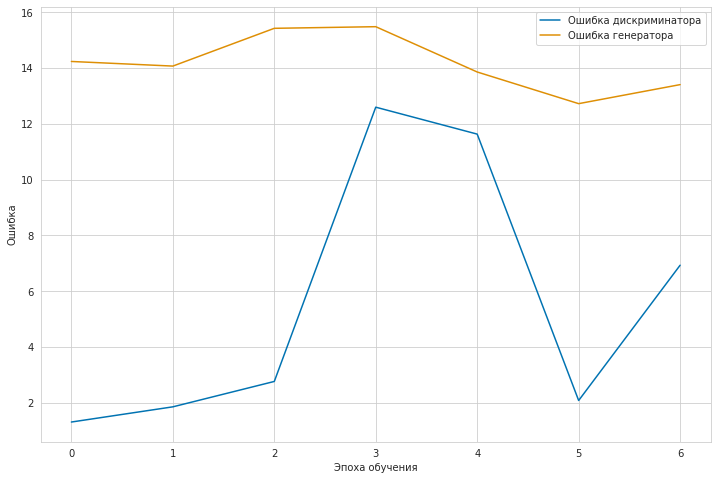

	...epoch 146/300	batch 0/7	D loss: 1.966616	G loss: 12.400845
	...epoch 146/300	batch 1/7	D loss: 1.863123	G loss: 12.762095
	...epoch 146/300	batch 2/7	D loss: 1.822815	G loss: 12.483454
	...epoch 146/300	batch 3/7	D loss: 1.221502	G loss: 11.674540
	...epoch 146/300	batch 4/7	D loss: 1.220371	G loss: 11.791256
	...epoch 146/300	batch 5/7	D loss: 1.229006	G loss: 12.383266
	...epoch 146/300	batch 6/7	D loss: 1.255941	G loss: 12.813670


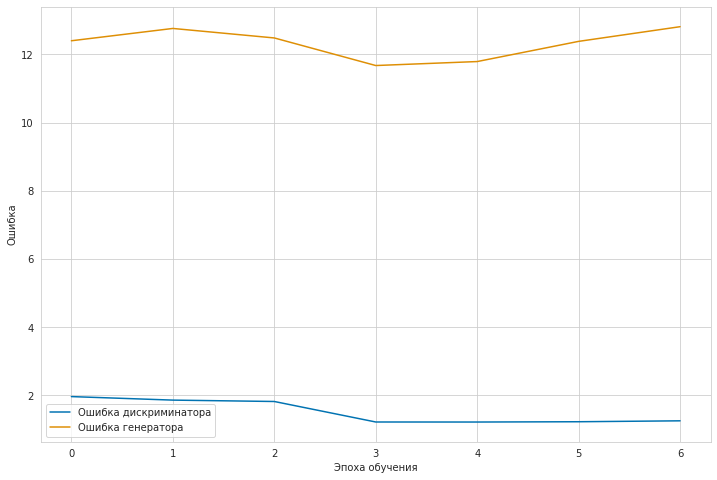

	...epoch 147/300	batch 0/7	D loss: 1.022966	G loss: 12.860866
	...epoch 147/300	batch 1/7	D loss: 1.060108	G loss: 12.349384
	...epoch 147/300	batch 2/7	D loss: 1.116520	G loss: 11.860768
	...epoch 147/300	batch 3/7	D loss: 1.118009	G loss: 11.436574
	...epoch 147/300	batch 4/7	D loss: 1.016165	G loss: 12.430940
	...epoch 147/300	batch 5/7	D loss: 1.024083	G loss: 12.294052
	...epoch 147/300	batch 6/7	D loss: 1.388877	G loss: 12.695415


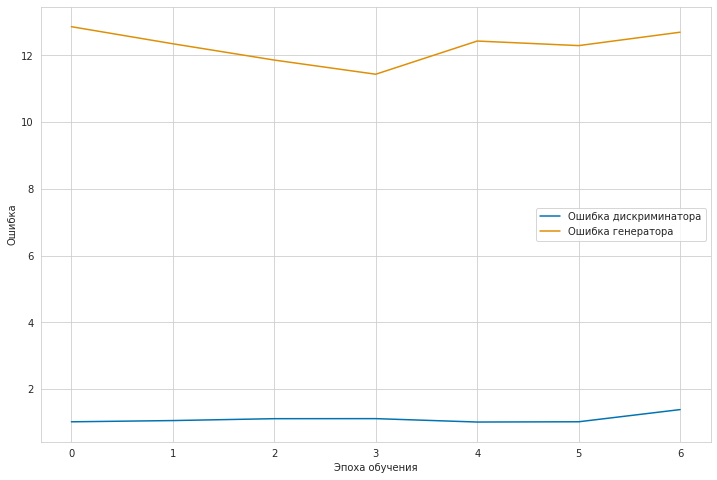

	...epoch 148/300	batch 0/7	D loss: 1.118945	G loss: 11.968966
	...epoch 148/300	batch 1/7	D loss: 1.185183	G loss: 12.334284
	...epoch 148/300	batch 2/7	D loss: 1.102385	G loss: 12.697405
	...epoch 148/300	batch 3/7	D loss: 1.021900	G loss: 12.103932
	...epoch 148/300	batch 4/7	D loss: 0.947260	G loss: 11.700995
	...epoch 148/300	batch 5/7	D loss: 1.054213	G loss: 12.670762
	...epoch 148/300	batch 6/7	D loss: 1.036755	G loss: 12.983071


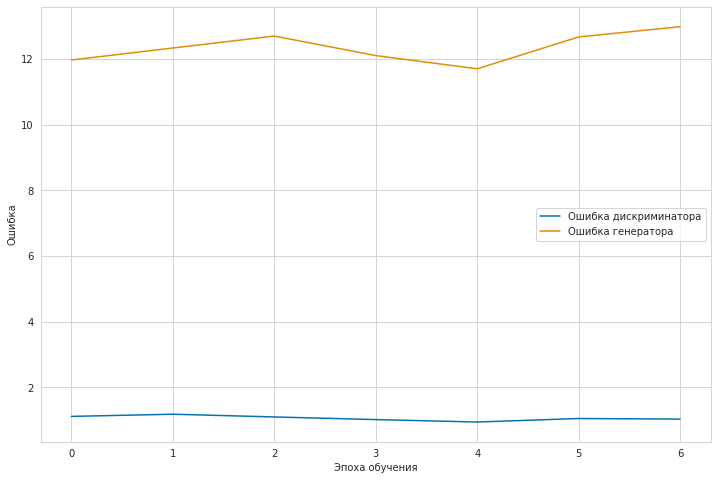

	...epoch 149/300	batch 0/7	D loss: 0.950720	G loss: 12.614021
	...epoch 149/300	batch 1/7	D loss: 1.153507	G loss: 13.097544
	...epoch 149/300	batch 2/7	D loss: 1.274563	G loss: 12.714914
	...epoch 149/300	batch 3/7	D loss: 1.265862	G loss: 12.464127
	...epoch 149/300	batch 4/7	D loss: 0.974264	G loss: 12.233407
	...epoch 149/300	batch 5/7	D loss: 0.882740	G loss: 12.301256
	...epoch 149/300	batch 6/7	D loss: 0.990596	G loss: 13.362298


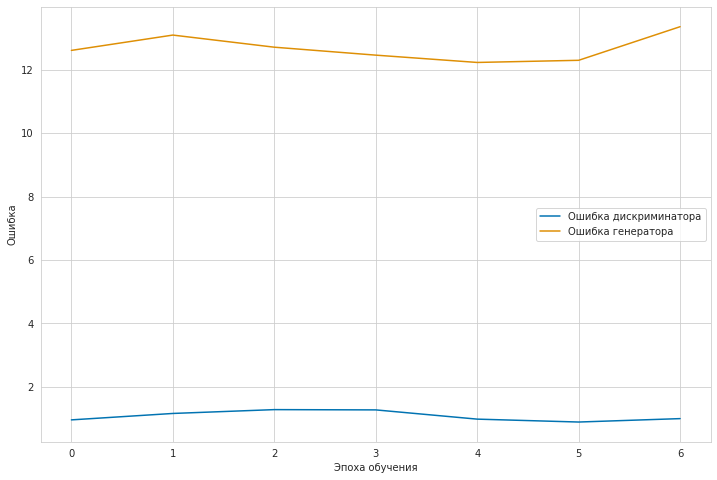

	...epoch 150/300	batch 0/7	D loss: 1.032909	G loss: 12.541705
	...epoch 150/300	batch 1/7	D loss: 0.986362	G loss: 12.322475
	...epoch 150/300	batch 2/7	D loss: 0.972322	G loss: 12.759895
	...epoch 150/300	batch 3/7	D loss: 0.966159	G loss: 12.122376
	...epoch 150/300	batch 4/7	D loss: 1.100252	G loss: 13.096799
	...epoch 150/300	batch 5/7	D loss: 1.065002	G loss: 12.504043
	...epoch 150/300	batch 6/7	D loss: 0.795358	G loss: 13.320260


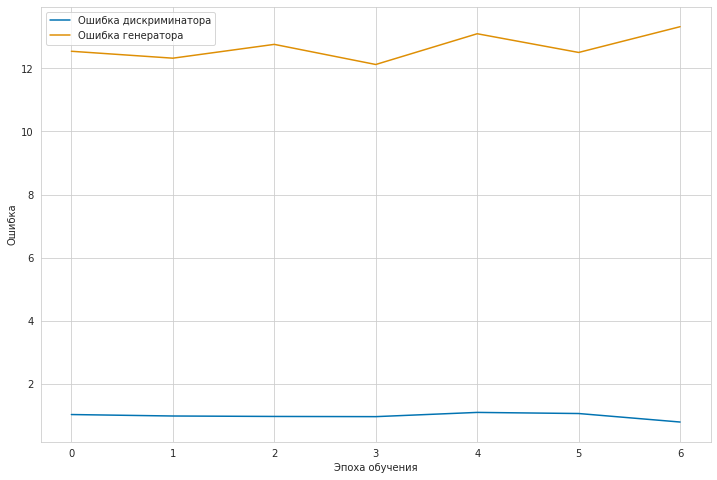

	...epoch 151/300	batch 0/7	D loss: 1.143881	G loss: 13.440332
	...epoch 151/300	batch 1/7	D loss: 1.062603	G loss: 12.566826
	...epoch 151/300	batch 2/7	D loss: 1.123523	G loss: 12.720078
	...epoch 151/300	batch 3/7	D loss: 0.955046	G loss: 13.688032
	...epoch 151/300	batch 4/7	D loss: 1.424679	G loss: 11.893053
	...epoch 151/300	batch 5/7	D loss: 1.331118	G loss: 13.452607
	...epoch 151/300	batch 6/7	D loss: 1.036666	G loss: 13.614437


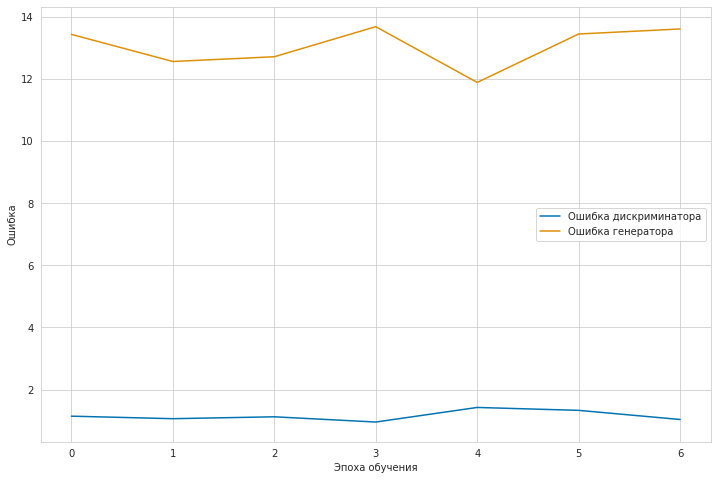

	...epoch 152/300	batch 0/7	D loss: 1.245418	G loss: 13.231987
	...epoch 152/300	batch 1/7	D loss: 1.099431	G loss: 13.074018
	...epoch 152/300	batch 2/7	D loss: 1.056361	G loss: 12.673277
	...epoch 152/300	batch 3/7	D loss: 1.091568	G loss: 13.291945
	...epoch 152/300	batch 4/7	D loss: 1.254774	G loss: 13.308659
	...epoch 152/300	batch 5/7	D loss: 1.082344	G loss: 13.237542
	...epoch 152/300	batch 6/7	D loss: 1.157736	G loss: 13.194236


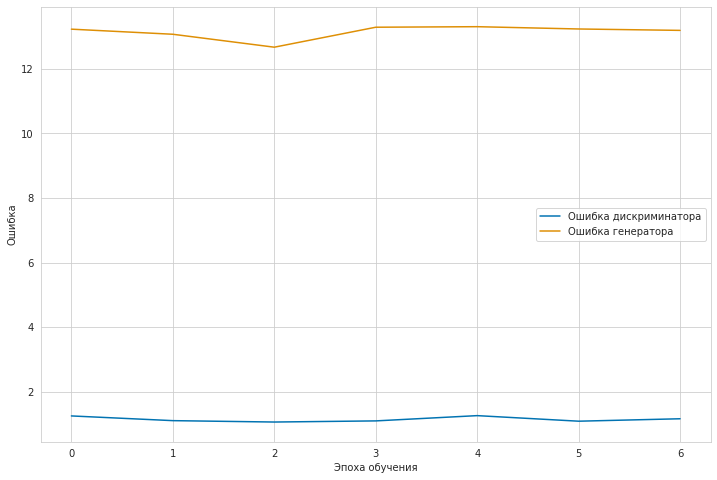

	...epoch 153/300	batch 0/7	D loss: 1.042371	G loss: 12.770088
	...epoch 153/300	batch 1/7	D loss: 1.140091	G loss: 13.050713
	...epoch 153/300	batch 2/7	D loss: 1.073246	G loss: 12.909496
	...epoch 153/300	batch 3/7	D loss: 1.206811	G loss: 13.834023
	...epoch 153/300	batch 4/7	D loss: 1.174627	G loss: 12.936666
	...epoch 153/300	batch 5/7	D loss: 1.262043	G loss: 12.146497
	...epoch 153/300	batch 6/7	D loss: 1.463123	G loss: 14.003945


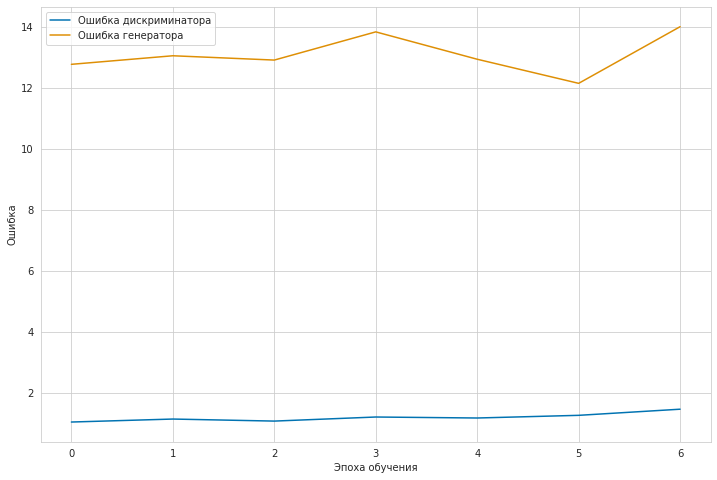

	...epoch 154/300	batch 0/7	D loss: 1.683689	G loss: 12.820463
	...epoch 154/300	batch 1/7	D loss: 1.091984	G loss: 12.657394
	...epoch 154/300	batch 2/7	D loss: 1.154324	G loss: 12.948635
	...epoch 154/300	batch 3/7	D loss: 1.163929	G loss: 12.275327
	...epoch 154/300	batch 4/7	D loss: 1.210639	G loss: 12.884481
	...epoch 154/300	batch 5/7	D loss: 1.032408	G loss: 12.658914
	...epoch 154/300	batch 6/7	D loss: 1.148437	G loss: 11.797831


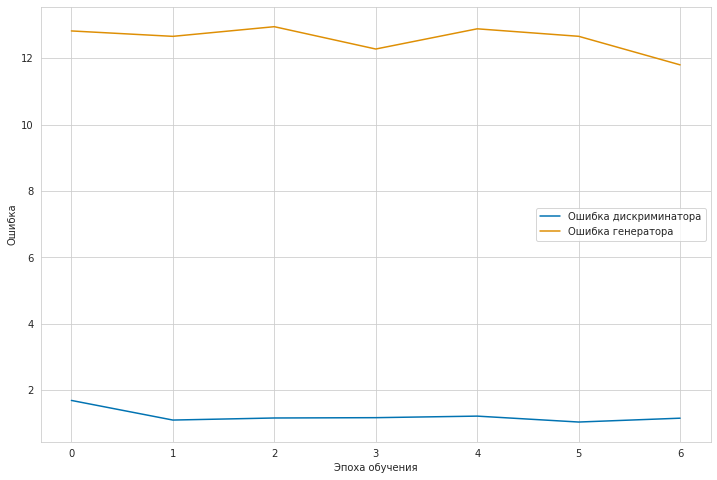

	...epoch 155/300	batch 0/7	D loss: 1.318100	G loss: 14.171303
	...epoch 155/300	batch 1/7	D loss: 1.618015	G loss: 12.560096
	...epoch 155/300	batch 2/7	D loss: 1.038210	G loss: 12.500660
	...epoch 155/300	batch 3/7	D loss: 1.102422	G loss: 12.418736
	...epoch 155/300	batch 4/7	D loss: 1.060142	G loss: 12.022033
	...epoch 155/300	batch 5/7	D loss: 1.209884	G loss: 13.011076
	...epoch 155/300	batch 6/7	D loss: 1.259901	G loss: 12.844765


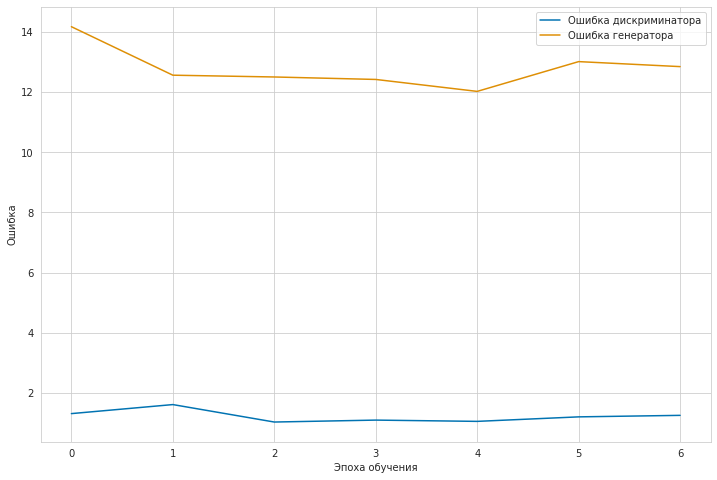

	...epoch 156/300	batch 0/7	D loss: 1.117004	G loss: 12.396723
	...epoch 156/300	batch 1/7	D loss: 1.011876	G loss: 13.420209
	...epoch 156/300	batch 2/7	D loss: 1.187568	G loss: 12.736897
	...epoch 156/300	batch 3/7	D loss: 1.091975	G loss: 12.433197
	...epoch 156/300	batch 4/7	D loss: 1.053940	G loss: 12.623560
	...epoch 156/300	batch 5/7	D loss: 1.142094	G loss: 11.800555
	...epoch 156/300	batch 6/7	D loss: 1.227605	G loss: 12.491584


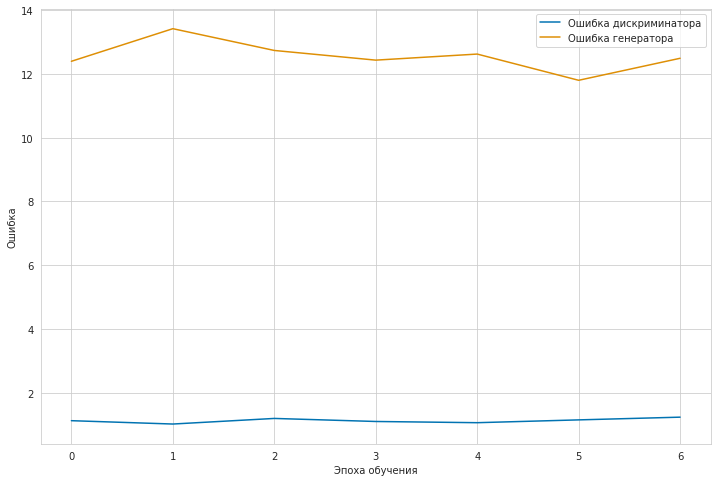

	...epoch 157/300	batch 0/7	D loss: 1.065021	G loss: 12.683509
	...epoch 157/300	batch 1/7	D loss: 1.053535	G loss: 12.050524
	...epoch 157/300	batch 2/7	D loss: 1.097854	G loss: 12.674869
	...epoch 157/300	batch 3/7	D loss: 1.189737	G loss: 11.702794
	...epoch 157/300	batch 4/7	D loss: 0.986719	G loss: 12.243516
	...epoch 157/300	batch 5/7	D loss: 0.969255	G loss: 13.215321
	...epoch 157/300	batch 6/7	D loss: 1.105866	G loss: 13.070509


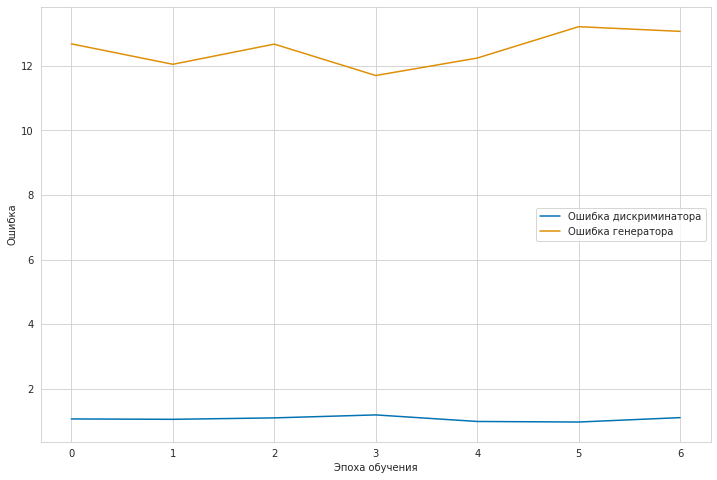

	...epoch 158/300	batch 0/7	D loss: 1.044940	G loss: 13.405843
	...epoch 158/300	batch 1/7	D loss: 1.137784	G loss: 12.286098
	...epoch 158/300	batch 2/7	D loss: 1.030676	G loss: 12.181377
	...epoch 158/300	batch 3/7	D loss: 0.942673	G loss: 12.975406
	...epoch 158/300	batch 4/7	D loss: 1.226202	G loss: 12.702466
	...epoch 158/300	batch 5/7	D loss: 1.170264	G loss: 11.789120
	...epoch 158/300	batch 6/7	D loss: 1.114117	G loss: 13.379934


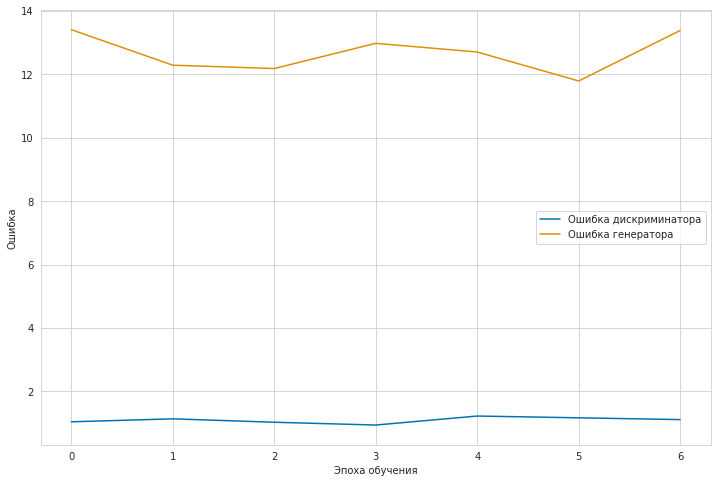

	...epoch 159/300	batch 0/7	D loss: 1.004086	G loss: 12.501517
	...epoch 159/300	batch 1/7	D loss: 1.181688	G loss: 12.993536
	...epoch 159/300	batch 2/7	D loss: 1.091907	G loss: 12.136280
	...epoch 159/300	batch 3/7	D loss: 1.241385	G loss: 12.339972
	...epoch 159/300	batch 4/7	D loss: 0.997509	G loss: 12.231211
	...epoch 159/300	batch 5/7	D loss: 1.169801	G loss: 12.442533
	...epoch 159/300	batch 6/7	D loss: 1.114297	G loss: 12.306151


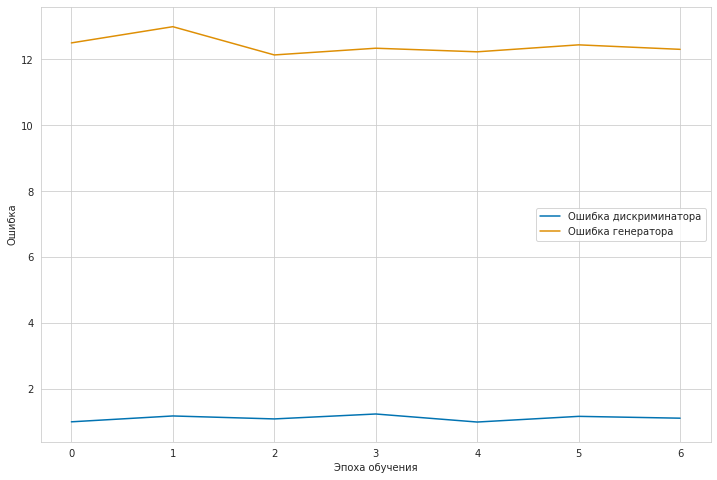

	...epoch 160/300	batch 0/7	D loss: 1.069002	G loss: 12.656507
	...epoch 160/300	batch 1/7	D loss: 1.094320	G loss: 12.666141
	...epoch 160/300	batch 2/7	D loss: 1.054931	G loss: 12.362690
	...epoch 160/300	batch 3/7	D loss: 1.208635	G loss: 11.932903
	...epoch 160/300	batch 4/7	D loss: 1.062848	G loss: 12.448490
	...epoch 160/300	batch 5/7	D loss: 1.254182	G loss: 11.626559
	...epoch 160/300	batch 6/7	D loss: 1.197252	G loss: 13.284989


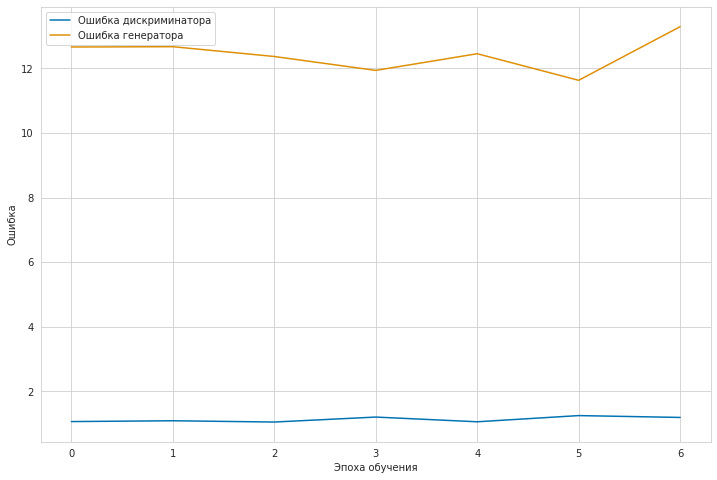

	...epoch 161/300	batch 0/7	D loss: 1.351764	G loss: 12.658824
	...epoch 161/300	batch 1/7	D loss: 1.155883	G loss: 13.197876
	...epoch 161/300	batch 2/7	D loss: 1.332834	G loss: 12.398519
	...epoch 161/300	batch 3/7	D loss: 0.933976	G loss: 12.925697
	...epoch 161/300	batch 4/7	D loss: 1.073550	G loss: 12.790491
	...epoch 161/300	batch 5/7	D loss: 1.212555	G loss: 11.908758
	...epoch 161/300	batch 6/7	D loss: 1.260436	G loss: 13.545205


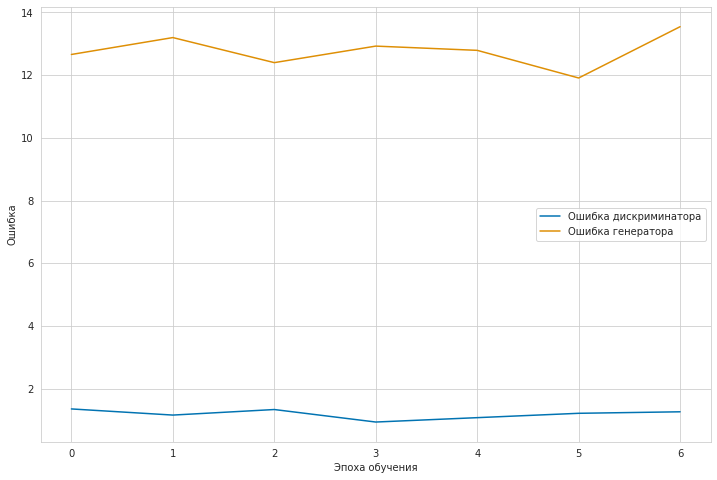

	...epoch 162/300	batch 0/7	D loss: 0.964778	G loss: 13.357360
	...epoch 162/300	batch 1/7	D loss: 1.048563	G loss: 12.826982
	...epoch 162/300	batch 2/7	D loss: 1.268583	G loss: 12.629125
	...epoch 162/300	batch 3/7	D loss: 1.006985	G loss: 12.310933
	...epoch 162/300	batch 4/7	D loss: 1.210321	G loss: 13.461444
	...epoch 162/300	batch 5/7	D loss: 1.307571	G loss: 12.019283
	...epoch 162/300	batch 6/7	D loss: 1.221928	G loss: 13.173717


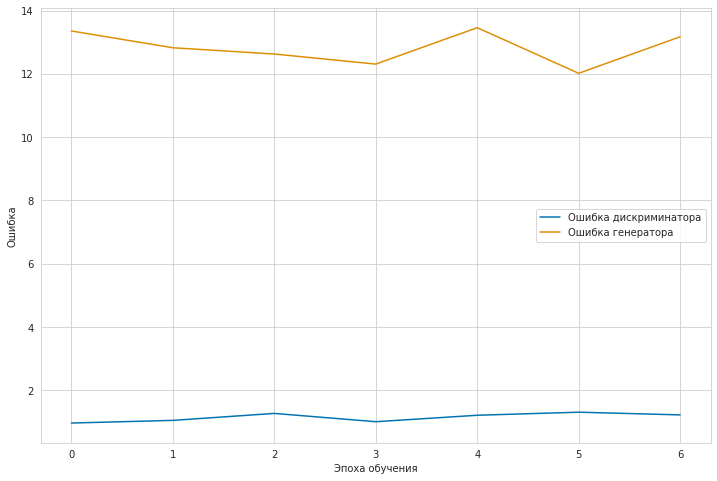

	...epoch 163/300	batch 0/7	D loss: 1.394966	G loss: 12.904584
	...epoch 163/300	batch 1/7	D loss: 1.179121	G loss: 11.964431
	...epoch 163/300	batch 2/7	D loss: 0.980534	G loss: 12.906247
	...epoch 163/300	batch 3/7	D loss: 1.124258	G loss: 12.260940
	...epoch 163/300	batch 4/7	D loss: 1.044707	G loss: 12.546508
	...epoch 163/300	batch 5/7	D loss: 0.823649	G loss: 12.850493
	...epoch 163/300	batch 6/7	D loss: 1.010774	G loss: 14.784144


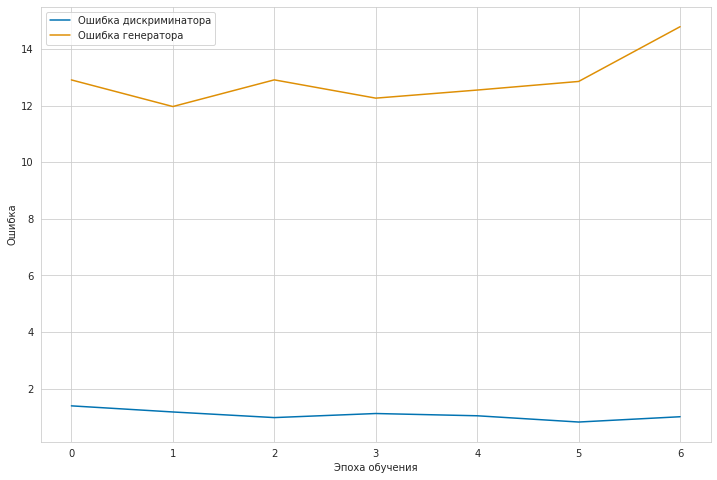

	...epoch 164/300	batch 0/7	D loss: 1.567923	G loss: 12.307388
	...epoch 164/300	batch 1/7	D loss: 1.325791	G loss: 13.619877
	...epoch 164/300	batch 2/7	D loss: 1.288313	G loss: 12.786849
	...epoch 164/300	batch 3/7	D loss: 1.034024	G loss: 12.750090
	...epoch 164/300	batch 4/7	D loss: 1.136971	G loss: 12.386813
	...epoch 164/300	batch 5/7	D loss: 1.065299	G loss: 12.612586
	...epoch 164/300	batch 6/7	D loss: 1.315663	G loss: 12.556466


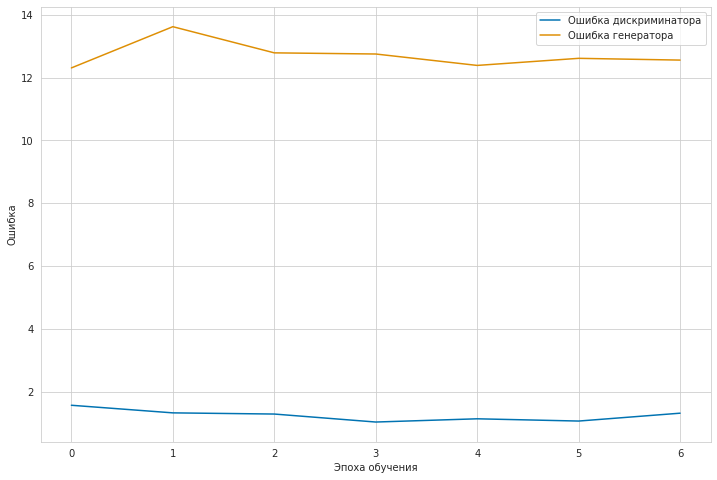

	...epoch 165/300	batch 0/7	D loss: 0.937247	G loss: 12.791830
	...epoch 165/300	batch 1/7	D loss: 1.023158	G loss: 12.412782
	...epoch 165/300	batch 2/7	D loss: 1.135814	G loss: 12.711751
	...epoch 165/300	batch 3/7	D loss: 1.038565	G loss: 13.038591
	...epoch 165/300	batch 4/7	D loss: 1.219388	G loss: 12.622950
	...epoch 165/300	batch 5/7	D loss: 1.104073	G loss: 11.867965
	...epoch 165/300	batch 6/7	D loss: 1.099412	G loss: 12.038534


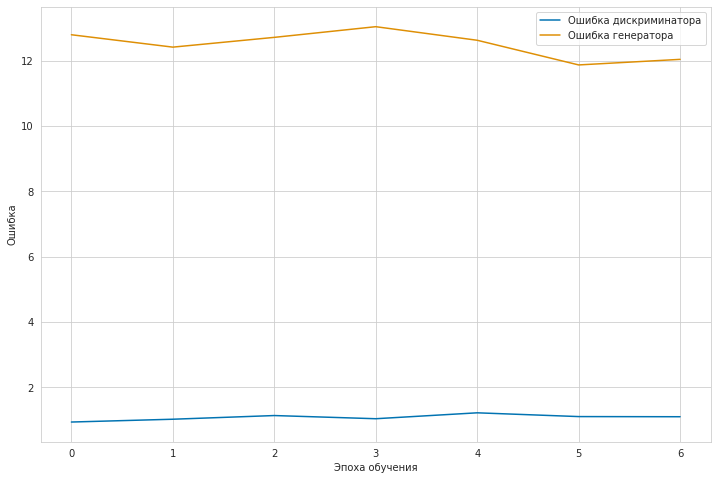

	...epoch 166/300	batch 0/7	D loss: 1.080804	G loss: 12.881138
	...epoch 166/300	batch 1/7	D loss: 1.242526	G loss: 12.003423
	...epoch 166/300	batch 2/7	D loss: 1.058934	G loss: 11.858395
	...epoch 166/300	batch 3/7	D loss: 0.890170	G loss: 12.040478
	...epoch 166/300	batch 4/7	D loss: 1.090552	G loss: 12.349986
	...epoch 166/300	batch 5/7	D loss: 1.202194	G loss: 12.171147
	...epoch 166/300	batch 6/7	D loss: 0.883678	G loss: 13.621278


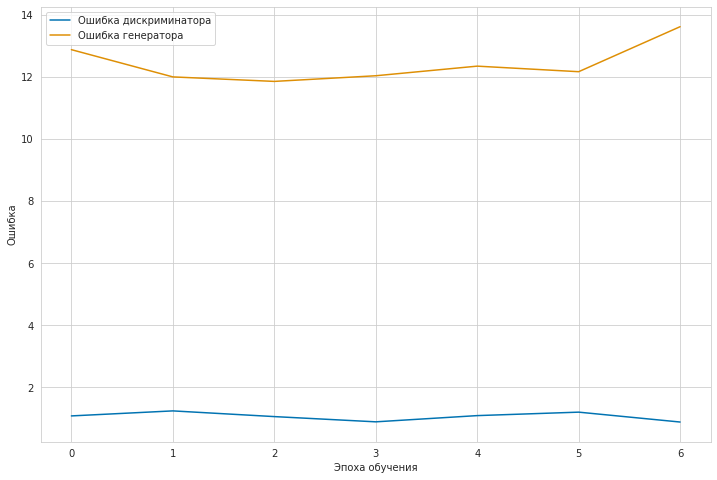

	...epoch 167/300	batch 0/7	D loss: 1.216207	G loss: 11.983213
	...epoch 167/300	batch 1/7	D loss: 1.277659	G loss: 12.377767
	...epoch 167/300	batch 2/7	D loss: 0.976883	G loss: 12.671468
	...epoch 167/300	batch 3/7	D loss: 0.981822	G loss: 12.211296
	...epoch 167/300	batch 4/7	D loss: 1.083844	G loss: 12.323055
	...epoch 167/300	batch 5/7	D loss: 1.200649	G loss: 12.226840
	...epoch 167/300	batch 6/7	D loss: 0.968418	G loss: 13.282778


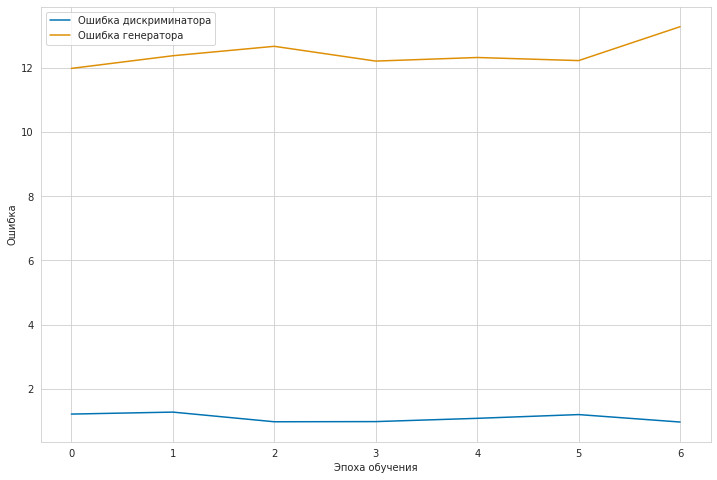

	...epoch 168/300	batch 0/7	D loss: 0.855150	G loss: 13.354058
	...epoch 168/300	batch 1/7	D loss: 1.290054	G loss: 11.499389
	...epoch 168/300	batch 2/7	D loss: 1.317248	G loss: 12.691956
	...epoch 168/300	batch 3/7	D loss: 1.124018	G loss: 11.628451
	...epoch 168/300	batch 4/7	D loss: 1.073588	G loss: 11.765510
	...epoch 168/300	batch 5/7	D loss: 1.065723	G loss: 11.998462
	...epoch 168/300	batch 6/7	D loss: 1.158239	G loss: 11.686392


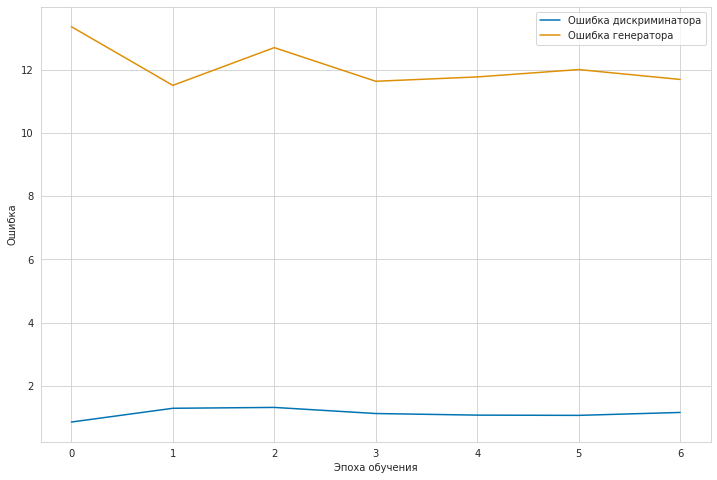

	...epoch 169/300	batch 0/7	D loss: 1.204641	G loss: 12.780929
	...epoch 169/300	batch 1/7	D loss: 1.536915	G loss: 12.101391
	...epoch 169/300	batch 2/7	D loss: 1.050934	G loss: 12.459104
	...epoch 169/300	batch 3/7	D loss: 1.135323	G loss: 12.621411
	...epoch 169/300	batch 4/7	D loss: 1.034557	G loss: 11.805676
	...epoch 169/300	batch 5/7	D loss: 1.010991	G loss: 12.326060
	...epoch 169/300	batch 6/7	D loss: 1.096850	G loss: 12.264045


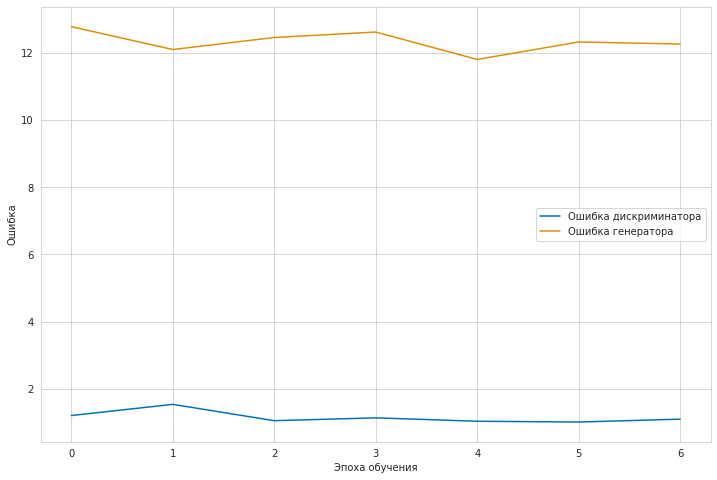

	...epoch 170/300	batch 0/7	D loss: 1.278087	G loss: 13.578341
	...epoch 170/300	batch 1/7	D loss: 1.245069	G loss: 13.877676
	...epoch 170/300	batch 2/7	D loss: 1.044097	G loss: 12.580822
	...epoch 170/300	batch 3/7	D loss: 1.074937	G loss: 13.110108
	...epoch 170/300	batch 4/7	D loss: 1.244000	G loss: 11.526810
	...epoch 170/300	batch 5/7	D loss: 1.118032	G loss: 12.161284
	...epoch 170/300	batch 6/7	D loss: 1.125925	G loss: 12.447603


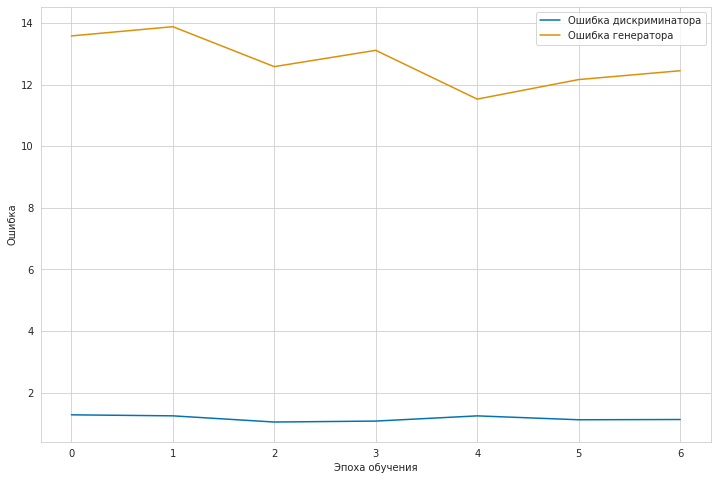

	...epoch 171/300	batch 0/7	D loss: 0.943872	G loss: 12.507055
	...epoch 171/300	batch 1/7	D loss: 1.013963	G loss: 13.602351
	...epoch 171/300	batch 2/7	D loss: 1.258674	G loss: 12.436527
	...epoch 171/300	batch 3/7	D loss: 0.948084	G loss: 11.593436
	...epoch 171/300	batch 4/7	D loss: 1.108280	G loss: 12.978428
	...epoch 171/300	batch 5/7	D loss: 1.168716	G loss: 12.233611
	...epoch 171/300	batch 6/7	D loss: 1.235202	G loss: 13.239100


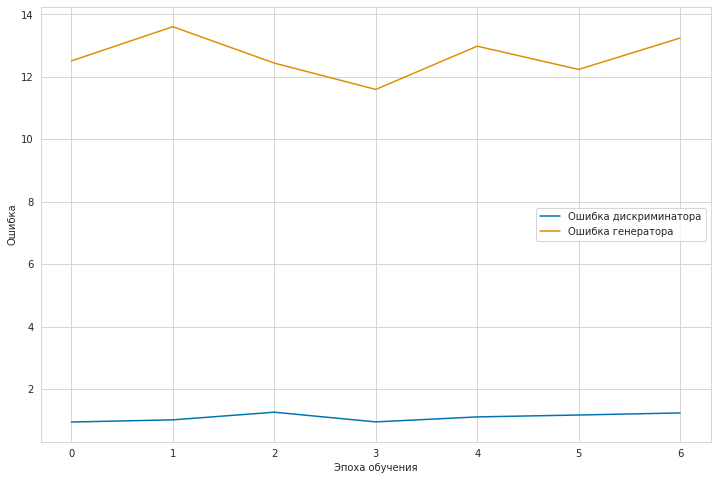

	...epoch 172/300	batch 0/7	D loss: 1.406933	G loss: 12.224483
	...epoch 172/300	batch 1/7	D loss: 1.100506	G loss: 11.752538
	...epoch 172/300	batch 2/7	D loss: 1.113481	G loss: 12.527701
	...epoch 172/300	batch 3/7	D loss: 1.102260	G loss: 11.674459
	...epoch 172/300	batch 4/7	D loss: 1.104701	G loss: 11.747426
	...epoch 172/300	batch 5/7	D loss: 0.963451	G loss: 12.146420
	...epoch 172/300	batch 6/7	D loss: 1.082040	G loss: 13.638391


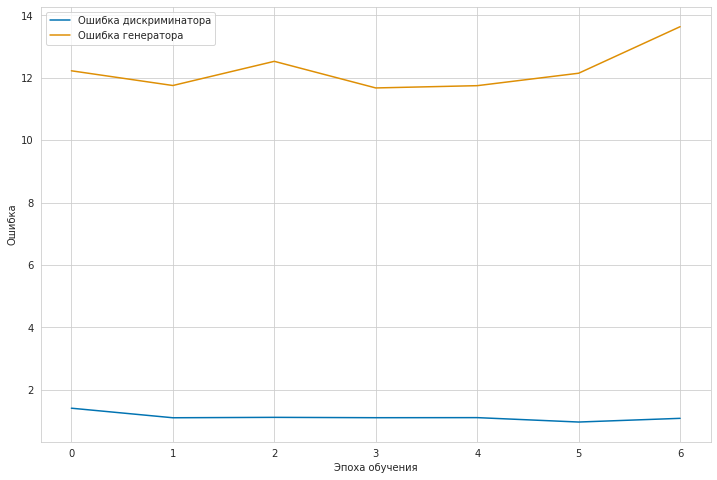

	...epoch 173/300	batch 0/7	D loss: 1.333160	G loss: 12.271954
	...epoch 173/300	batch 1/7	D loss: 1.142667	G loss: 11.981221
	...epoch 173/300	batch 2/7	D loss: 0.963159	G loss: 12.555129
	...epoch 173/300	batch 3/7	D loss: 1.113824	G loss: 11.921181
	...epoch 173/300	batch 4/7	D loss: 1.110758	G loss: 11.827877
	...epoch 173/300	batch 5/7	D loss: 1.063003	G loss: 12.758385
	...epoch 173/300	batch 6/7	D loss: 1.813297	G loss: 11.202710


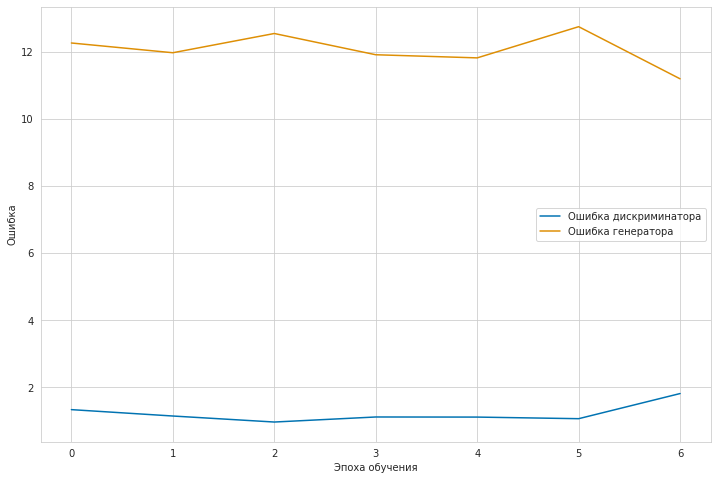

	...epoch 174/300	batch 0/7	D loss: 1.178607	G loss: 12.543438
	...epoch 174/300	batch 1/7	D loss: 1.176593	G loss: 11.959241
	...epoch 174/300	batch 2/7	D loss: 1.071291	G loss: 12.694147
	...epoch 174/300	batch 3/7	D loss: 1.165318	G loss: 12.004714
	...epoch 174/300	batch 4/7	D loss: 1.008134	G loss: 11.555758
	...epoch 174/300	batch 5/7	D loss: 0.994337	G loss: 12.023871
	...epoch 174/300	batch 6/7	D loss: 1.079931	G loss: 14.663909


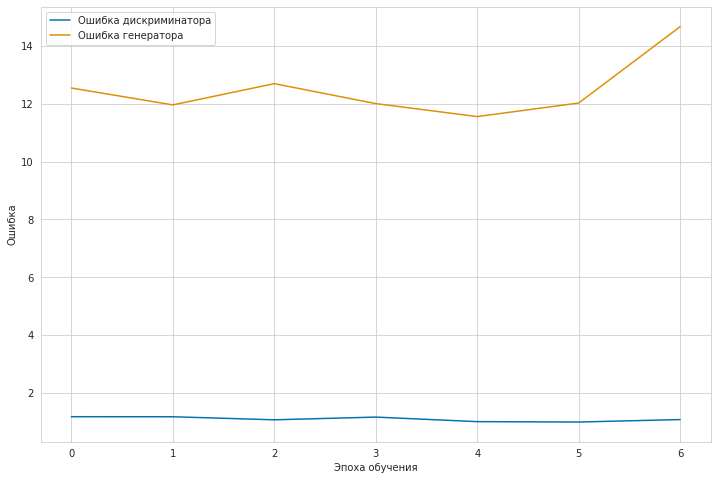

	...epoch 175/300	batch 0/7	D loss: 1.231241	G loss: 12.123199
	...epoch 175/300	batch 1/7	D loss: 1.258787	G loss: 12.654664
	...epoch 175/300	batch 2/7	D loss: 1.231742	G loss: 11.969201
	...epoch 175/300	batch 3/7	D loss: 1.059786	G loss: 12.287129
	...epoch 175/300	batch 4/7	D loss: 1.051850	G loss: 11.925495
	...epoch 175/300	batch 5/7	D loss: 0.885871	G loss: 11.909376
	...epoch 175/300	batch 6/7	D loss: 1.084657	G loss: 13.485101


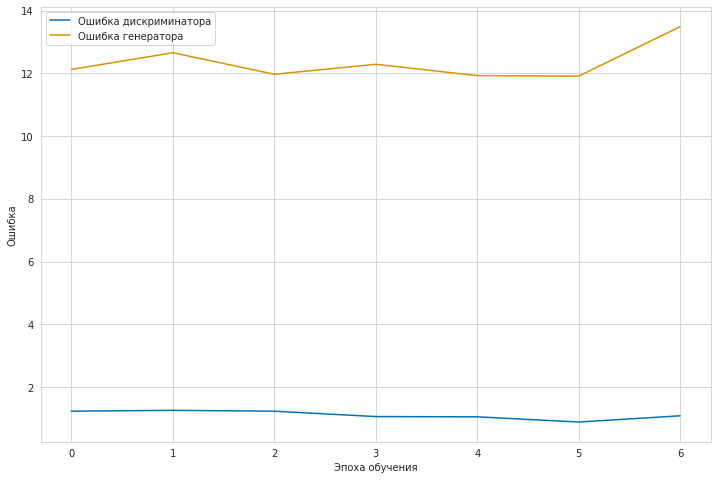

	...epoch 176/300	batch 0/7	D loss: 1.627489	G loss: 13.387681
	...epoch 176/300	batch 1/7	D loss: 1.047904	G loss: 11.998212
	...epoch 176/300	batch 2/7	D loss: 0.971882	G loss: 12.901257
	...epoch 176/300	batch 3/7	D loss: 1.196803	G loss: 11.849439
	...epoch 176/300	batch 4/7	D loss: 1.162123	G loss: 11.288024
	...epoch 176/300	batch 5/7	D loss: 0.940306	G loss: 12.362983
	...epoch 176/300	batch 6/7	D loss: 1.227165	G loss: 12.063812


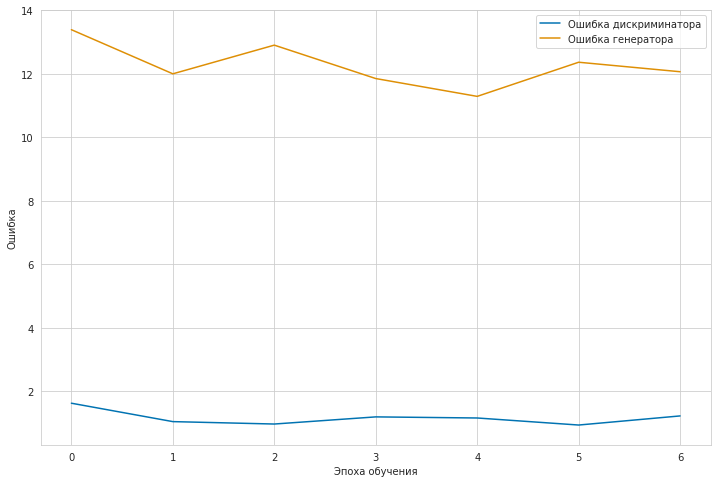

	...epoch 177/300	batch 0/7	D loss: 0.967742	G loss: 12.365026
	...epoch 177/300	batch 1/7	D loss: 0.934184	G loss: 12.539640
	...epoch 177/300	batch 2/7	D loss: 1.117480	G loss: 11.302146
	...epoch 177/300	batch 3/7	D loss: 1.257105	G loss: 12.952135
	...epoch 177/300	batch 4/7	D loss: 1.276328	G loss: 12.039765
	...epoch 177/300	batch 5/7	D loss: 1.120225	G loss: 11.223304
	...epoch 177/300	batch 6/7	D loss: 1.461964	G loss: 13.464794


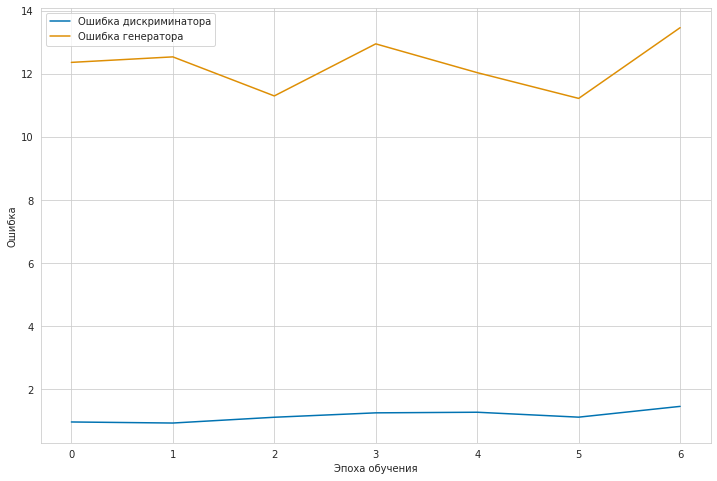

	...epoch 178/300	batch 0/7	D loss: 1.379441	G loss: 12.349807
	...epoch 178/300	batch 1/7	D loss: 1.154526	G loss: 11.300292
	...epoch 178/300	batch 2/7	D loss: 1.177411	G loss: 12.442297
	...epoch 178/300	batch 3/7	D loss: 1.087673	G loss: 11.783198
	...epoch 178/300	batch 4/7	D loss: 1.126560	G loss: 11.775564
	...epoch 178/300	batch 5/7	D loss: 1.074190	G loss: 12.361393
	...epoch 178/300	batch 6/7	D loss: 0.984649	G loss: 12.140159


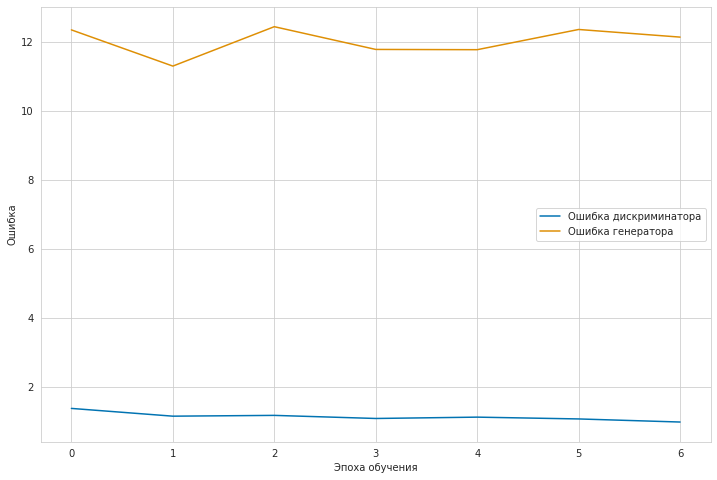

	...epoch 179/300	batch 0/7	D loss: 1.147467	G loss: 11.772272
	...epoch 179/300	batch 1/7	D loss: 1.041129	G loss: 12.284262
	...epoch 179/300	batch 2/7	D loss: 0.953739	G loss: 12.457219
	...epoch 179/300	batch 3/7	D loss: 1.097538	G loss: 11.386218
	...epoch 179/300	batch 4/7	D loss: 0.945622	G loss: 11.670845
	...epoch 179/300	batch 5/7	D loss: 0.995079	G loss: 12.347165
	...epoch 179/300	batch 6/7	D loss: 1.218770	G loss: 10.991564


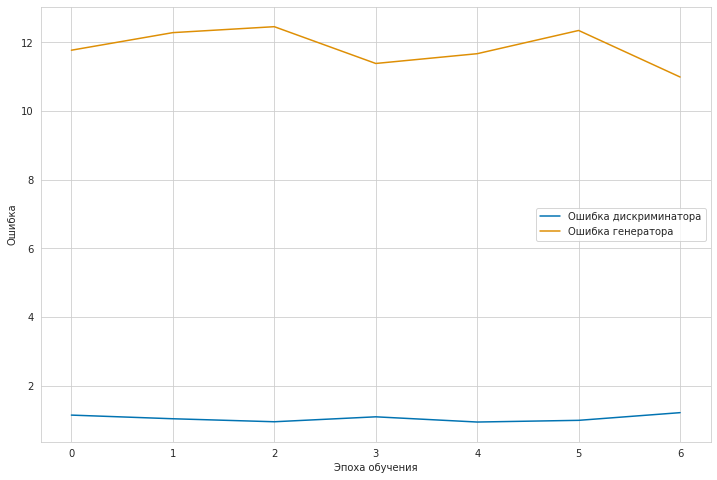

	...epoch 180/300	batch 0/7	D loss: 1.176074	G loss: 12.747400
	...epoch 180/300	batch 1/7	D loss: 1.064341	G loss: 11.844280
	...epoch 180/300	batch 2/7	D loss: 1.062162	G loss: 11.127668
	...epoch 180/300	batch 3/7	D loss: 1.211455	G loss: 12.424572
	...epoch 180/300	batch 4/7	D loss: 0.978940	G loss: 11.825694
	...epoch 180/300	batch 5/7	D loss: 1.122761	G loss: 11.120570
	...epoch 180/300	batch 6/7	D loss: 1.389520	G loss: 12.781372


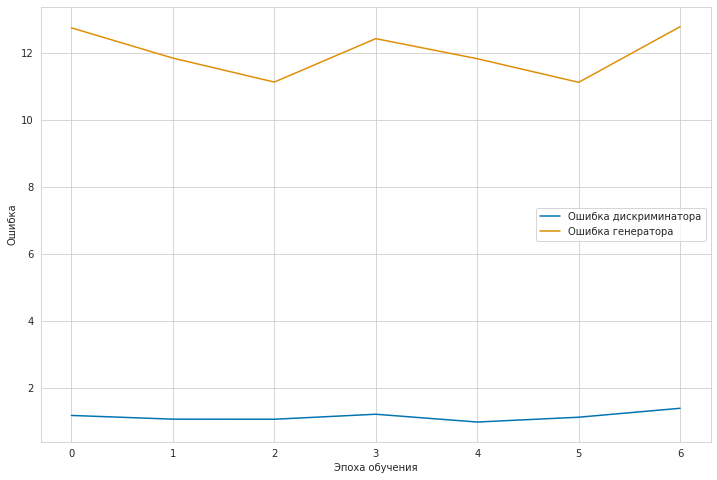

	...epoch 181/300	batch 0/7	D loss: 0.981969	G loss: 12.305564
	...epoch 181/300	batch 1/7	D loss: 1.073211	G loss: 11.960861
	...epoch 181/300	batch 2/7	D loss: 0.940002	G loss: 11.827805
	...epoch 181/300	batch 3/7	D loss: 1.069252	G loss: 11.864899
	...epoch 181/300	batch 4/7	D loss: 1.020637	G loss: 11.977281
	...epoch 181/300	batch 5/7	D loss: 0.995160	G loss: 11.610397
	...epoch 181/300	batch 6/7	D loss: 0.980415	G loss: 12.320998


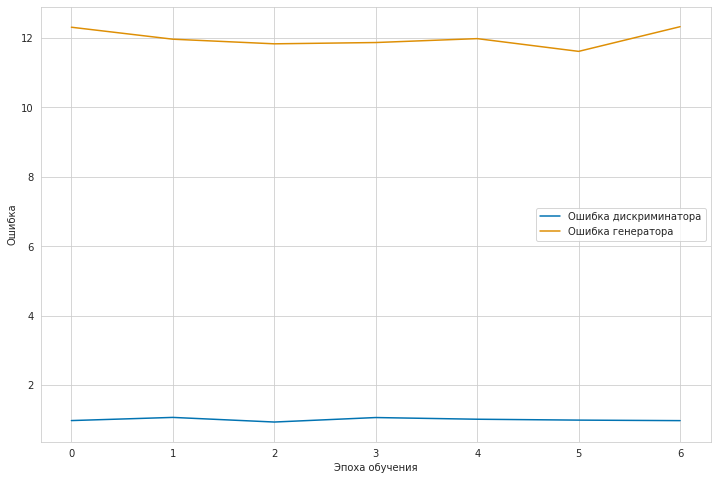

	...epoch 182/300	batch 0/7	D loss: 1.153194	G loss: 12.127149
	...epoch 182/300	batch 1/7	D loss: 1.035029	G loss: 12.293407
	...epoch 182/300	batch 2/7	D loss: 0.942962	G loss: 11.700647
	...epoch 182/300	batch 3/7	D loss: 1.109046	G loss: 12.030943
	...epoch 182/300	batch 4/7	D loss: 1.219000	G loss: 11.531034
	...epoch 182/300	batch 5/7	D loss: 1.066883	G loss: 12.214471
	...epoch 182/300	batch 6/7	D loss: 0.971070	G loss: 12.426569


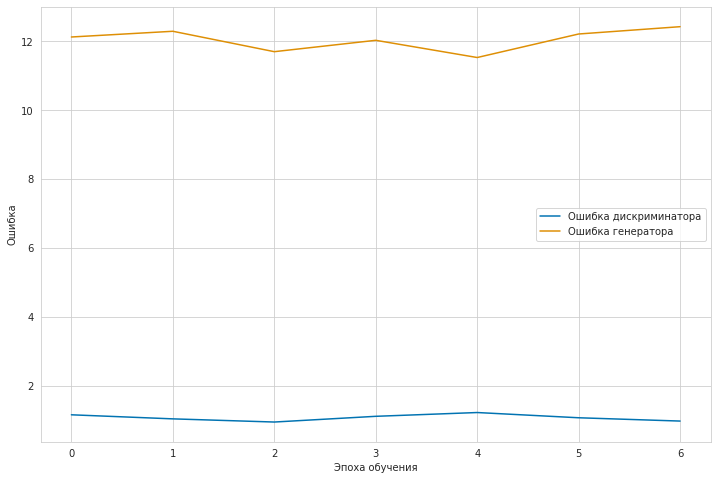

	...epoch 183/300	batch 0/7	D loss: 1.054551	G loss: 11.408495
	...epoch 183/300	batch 1/7	D loss: 1.211090	G loss: 13.187717
	...epoch 183/300	batch 2/7	D loss: 1.542318	G loss: 11.646029
	...epoch 183/300	batch 3/7	D loss: 1.260781	G loss: 11.536279
	...epoch 183/300	batch 4/7	D loss: 1.056282	G loss: 11.714015
	...epoch 183/300	batch 5/7	D loss: 1.030914	G loss: 11.920662
	...epoch 183/300	batch 6/7	D loss: 1.162404	G loss: 11.875728


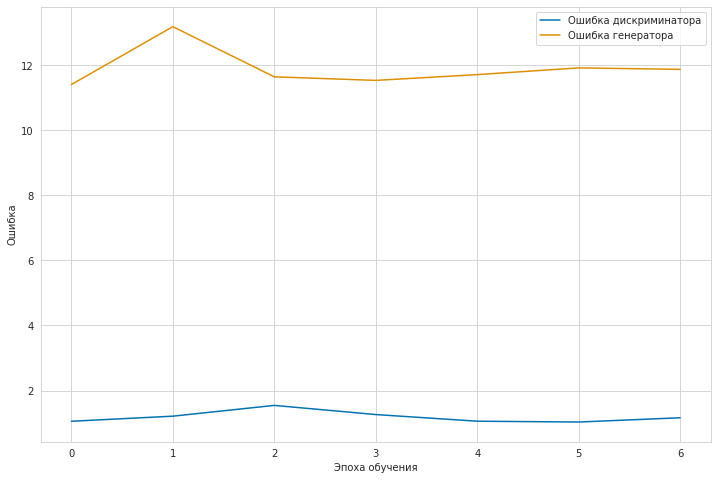

	...epoch 184/300	batch 0/7	D loss: 1.246737	G loss: 12.593950
	...epoch 184/300	batch 1/7	D loss: 1.438708	G loss: 11.654647
	...epoch 184/300	batch 2/7	D loss: 1.098799	G loss: 11.705406
	...epoch 184/300	batch 3/7	D loss: 1.006490	G loss: 11.867267
	...epoch 184/300	batch 4/7	D loss: 1.115739	G loss: 11.405252
	...epoch 184/300	batch 5/7	D loss: 1.159516	G loss: 11.681509
	...epoch 184/300	batch 6/7	D loss: 1.389746	G loss: 13.656660


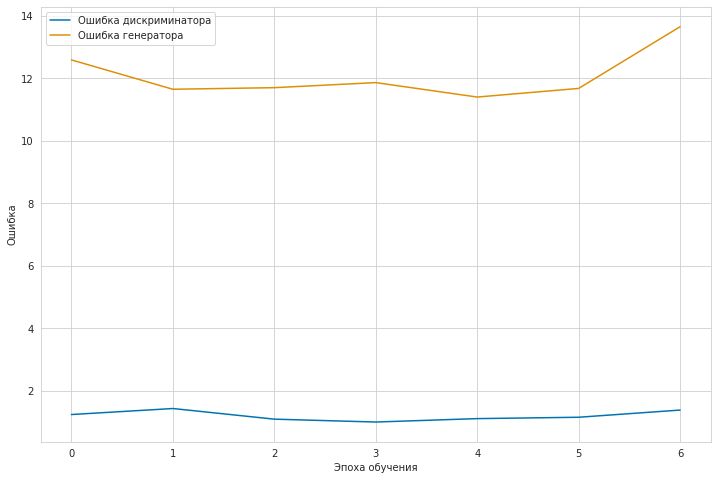

	...epoch 185/300	batch 0/7	D loss: 1.283804	G loss: 11.960248
	...epoch 185/300	batch 1/7	D loss: 1.081921	G loss: 11.789806
	...epoch 185/300	batch 2/7	D loss: 1.019412	G loss: 12.067955
	...epoch 185/300	batch 3/7	D loss: 1.269522	G loss: 11.179592
	...epoch 185/300	batch 4/7	D loss: 1.298731	G loss: 11.813949
	...epoch 185/300	batch 5/7	D loss: 1.279343	G loss: 11.532785
	...epoch 185/300	batch 6/7	D loss: 0.961183	G loss: 12.308484


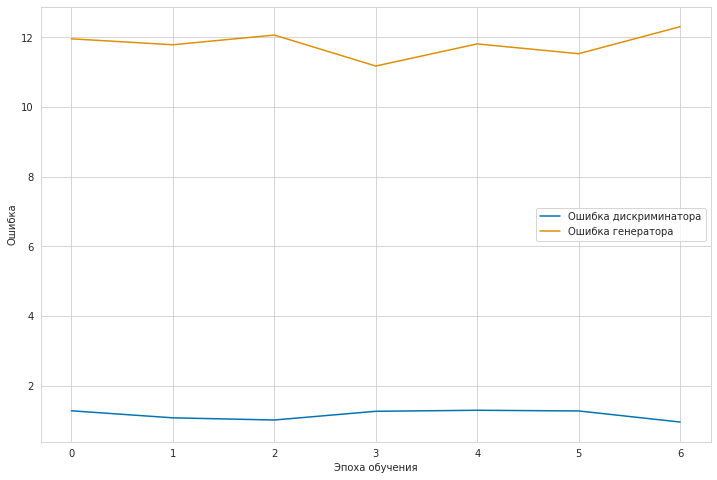

	...epoch 186/300	batch 0/7	D loss: 1.161976	G loss: 12.506158
	...epoch 186/300	batch 1/7	D loss: 1.162218	G loss: 11.672136
	...epoch 186/300	batch 2/7	D loss: 0.925789	G loss: 11.918994
	...epoch 186/300	batch 3/7	D loss: 1.064612	G loss: 11.051476
	...epoch 186/300	batch 4/7	D loss: 1.051730	G loss: 12.084774
	...epoch 186/300	batch 5/7	D loss: 1.233371	G loss: 11.117388
	...epoch 186/300	batch 6/7	D loss: 1.076170	G loss: 11.640740


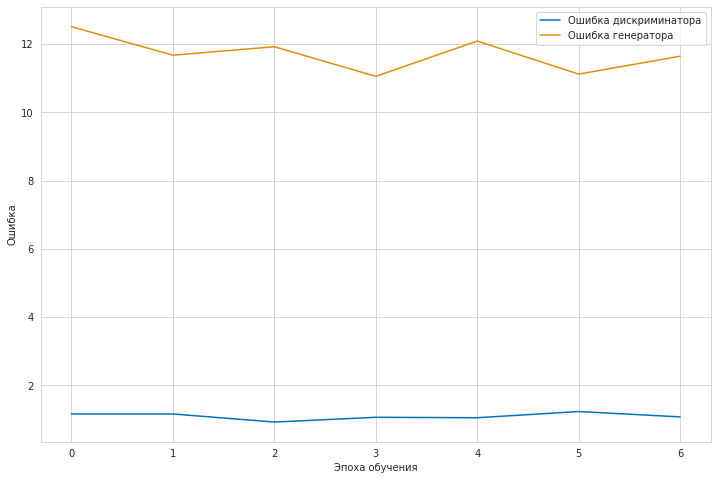

	...epoch 187/300	batch 0/7	D loss: 0.934903	G loss: 11.767276
	...epoch 187/300	batch 1/7	D loss: 1.005737	G loss: 11.606171
	...epoch 187/300	batch 2/7	D loss: 1.035946	G loss: 12.004356
	...epoch 187/300	batch 3/7	D loss: 1.050197	G loss: 11.629539
	...epoch 187/300	batch 4/7	D loss: 0.985304	G loss: 11.547503
	...epoch 187/300	batch 5/7	D loss: 0.989629	G loss: 12.081450
	...epoch 187/300	batch 6/7	D loss: 0.950933	G loss: 12.460441


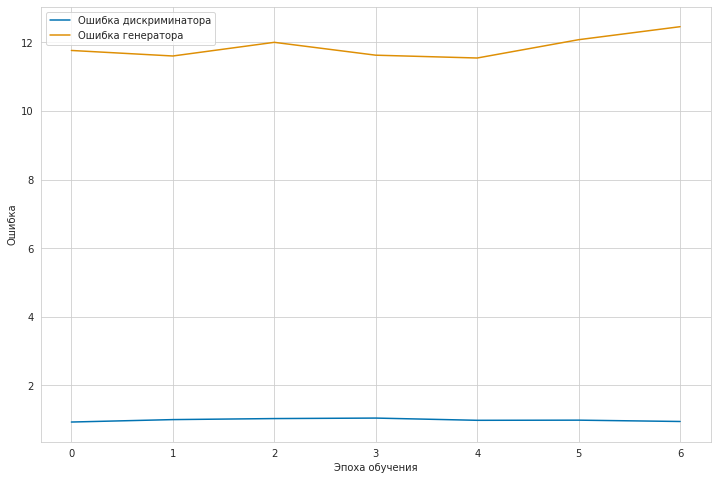

	...epoch 188/300	batch 0/7	D loss: 1.305006	G loss: 11.971718
	...epoch 188/300	batch 1/7	D loss: 1.093801	G loss: 12.289668
	...epoch 188/300	batch 2/7	D loss: 1.094652	G loss: 11.967549
	...epoch 188/300	batch 3/7	D loss: 1.012102	G loss: 11.251161
	...epoch 188/300	batch 4/7	D loss: 1.074740	G loss: 11.618876
	...epoch 188/300	batch 5/7	D loss: 1.065521	G loss: 12.184799
	...epoch 188/300	batch 6/7	D loss: 1.264326	G loss: 11.149801


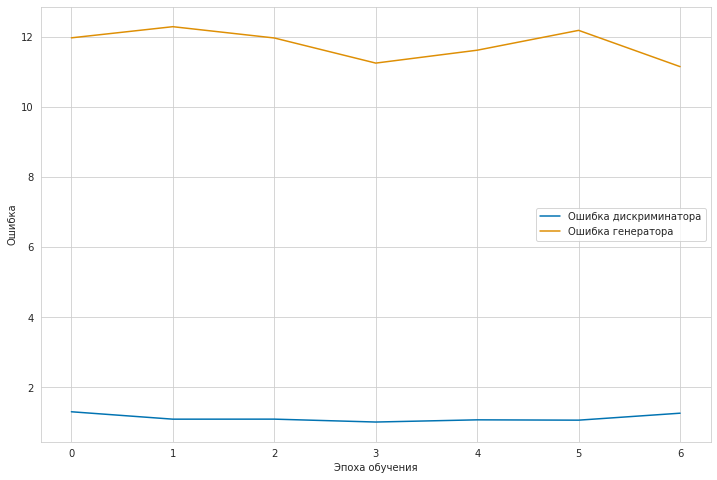

	...epoch 189/300	batch 0/7	D loss: 1.191240	G loss: 11.811703
	...epoch 189/300	batch 1/7	D loss: 0.989835	G loss: 12.551742
	...epoch 189/300	batch 2/7	D loss: 1.135758	G loss: 11.758801
	...epoch 189/300	batch 3/7	D loss: 1.113673	G loss: 11.969316
	...epoch 189/300	batch 4/7	D loss: 1.133928	G loss: 12.016144
	...epoch 189/300	batch 5/7	D loss: 1.040666	G loss: 11.839440
	...epoch 189/300	batch 6/7	D loss: 1.252501	G loss: 11.939519


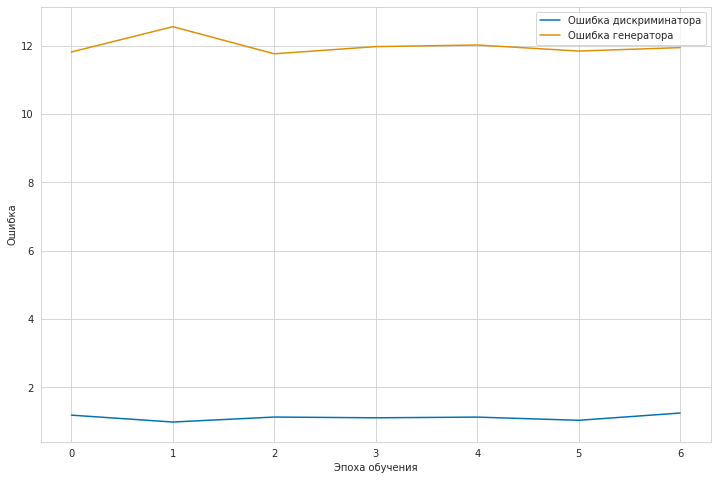

	...epoch 190/300	batch 0/7	D loss: 1.444324	G loss: 13.217883
	...epoch 190/300	batch 1/7	D loss: 1.465176	G loss: 12.028231
	...epoch 190/300	batch 2/7	D loss: 1.266040	G loss: 11.715255
	...epoch 190/300	batch 3/7	D loss: 1.359464	G loss: 11.971459
	...epoch 190/300	batch 4/7	D loss: 1.453401	G loss: 11.906387
	...epoch 190/300	batch 5/7	D loss: 1.649955	G loss: 11.563238
	...epoch 190/300	batch 6/7	D loss: 1.722028	G loss: 13.085489


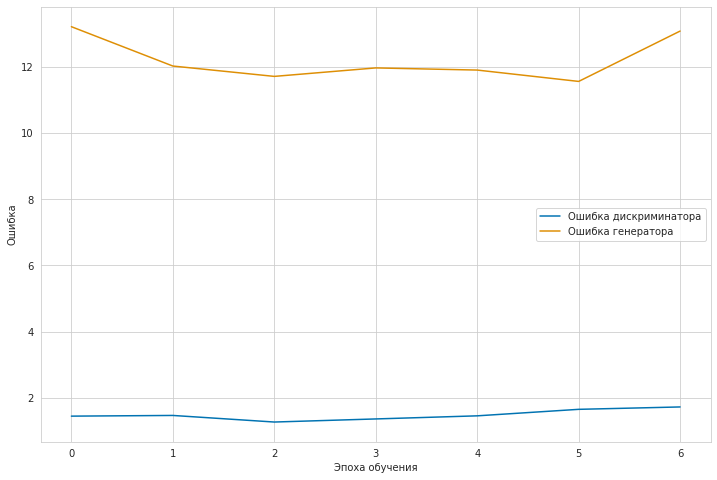

	...epoch 191/300	batch 0/7	D loss: 4.186855	G loss: 13.437496
	...epoch 191/300	batch 1/7	D loss: 5.056465	G loss: 14.271915
	...epoch 191/300	batch 2/7	D loss: 13.246570	G loss: 13.316427
	...epoch 191/300	batch 3/7	D loss: 10.136622	G loss: 11.203689
	...epoch 191/300	batch 4/7	D loss: 2.007357	G loss: 10.820889
	...epoch 191/300	batch 5/7	D loss: 1.703422	G loss: 11.085201
	...epoch 191/300	batch 6/7	D loss: 2.142688	G loss: 11.443283


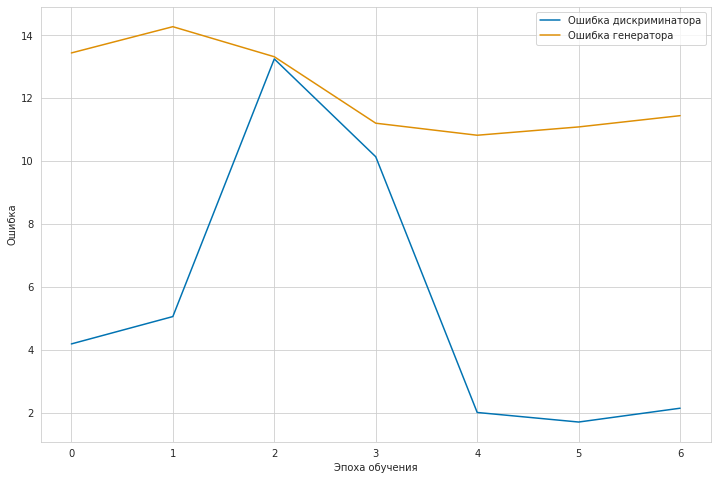

	...epoch 192/300	batch 0/7	D loss: 1.256338	G loss: 12.315103
	...epoch 192/300	batch 1/7	D loss: 1.558263	G loss: 11.674187
	...epoch 192/300	batch 2/7	D loss: 1.796252	G loss: 11.230951
	...epoch 192/300	batch 3/7	D loss: 1.326699	G loss: 10.625293
	...epoch 192/300	batch 4/7	D loss: 1.262839	G loss: 10.474851
	...epoch 192/300	batch 5/7	D loss: 1.238093	G loss: 10.556031
	...epoch 192/300	batch 6/7	D loss: 1.188585	G loss: 10.633356


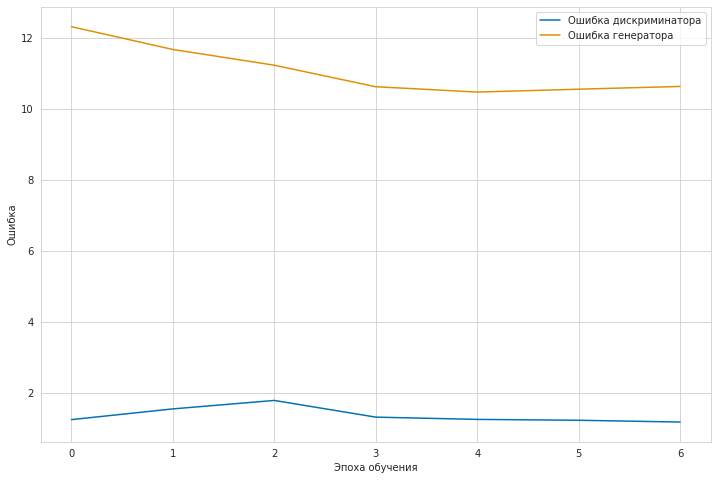

	...epoch 193/300	batch 0/7	D loss: 1.184980	G loss: 10.892714
	...epoch 193/300	batch 1/7	D loss: 1.236656	G loss: 11.009261
	...epoch 193/300	batch 2/7	D loss: 1.178005	G loss: 10.934835
	...epoch 193/300	batch 3/7	D loss: 1.209428	G loss: 10.964804
	...epoch 193/300	batch 4/7	D loss: 1.269572	G loss: 11.393398
	...epoch 193/300	batch 5/7	D loss: 1.290116	G loss: 10.609861
	...epoch 193/300	batch 6/7	D loss: 1.160831	G loss: 12.205333


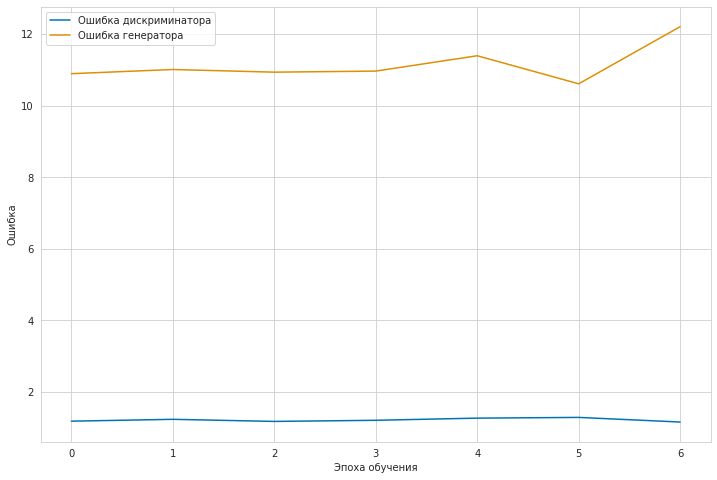

	...epoch 194/300	batch 0/7	D loss: 1.166757	G loss: 10.821853
	...epoch 194/300	batch 1/7	D loss: 1.147625	G loss: 11.116262
	...epoch 194/300	batch 2/7	D loss: 1.133112	G loss: 10.635613
	...epoch 194/300	batch 3/7	D loss: 1.191518	G loss: 11.043569
	...epoch 194/300	batch 4/7	D loss: 1.028113	G loss: 11.006540
	...epoch 194/300	batch 5/7	D loss: 1.187935	G loss: 10.599936
	...epoch 194/300	batch 6/7	D loss: 1.097631	G loss: 11.189491


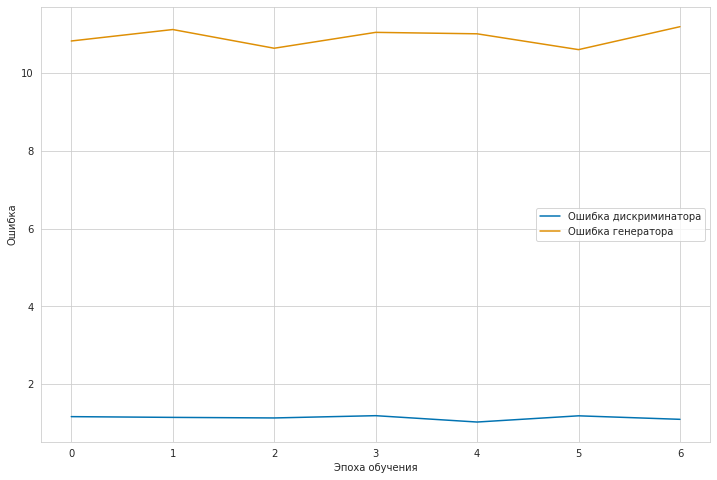

	...epoch 195/300	batch 0/7	D loss: 1.218755	G loss: 10.586897
	...epoch 195/300	batch 1/7	D loss: 1.117542	G loss: 10.971572
	...epoch 195/300	batch 2/7	D loss: 1.076033	G loss: 11.242509
	...epoch 195/300	batch 3/7	D loss: 1.048056	G loss: 11.185667
	...epoch 195/300	batch 4/7	D loss: 1.103099	G loss: 11.104701
	...epoch 195/300	batch 5/7	D loss: 1.093479	G loss: 10.619910
	...epoch 195/300	batch 6/7	D loss: 1.081630	G loss: 11.196651


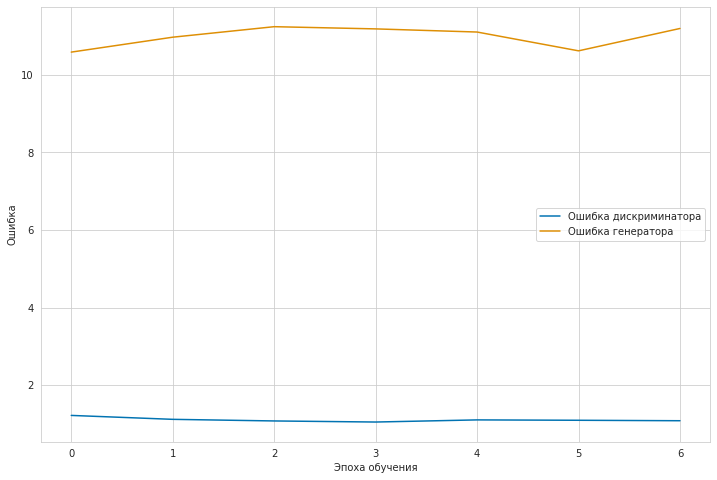

	...epoch 196/300	batch 0/7	D loss: 1.095852	G loss: 11.774071
	...epoch 196/300	batch 1/7	D loss: 1.005841	G loss: 11.380201
	...epoch 196/300	batch 2/7	D loss: 1.071390	G loss: 10.212600
	...epoch 196/300	batch 3/7	D loss: 1.107249	G loss: 11.315160
	...epoch 196/300	batch 4/7	D loss: 0.981125	G loss: 11.183052
	...epoch 196/300	batch 5/7	D loss: 1.085517	G loss: 10.616435
	...epoch 196/300	batch 6/7	D loss: 1.154537	G loss: 13.494938


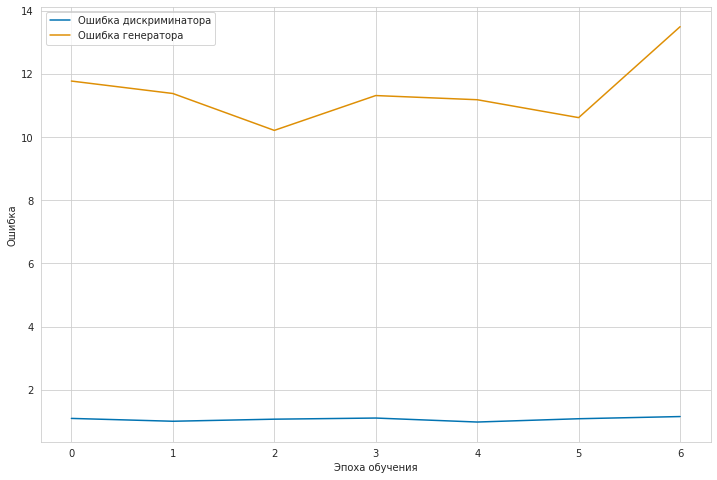

	...epoch 197/300	batch 0/7	D loss: 1.165399	G loss: 12.415946
	...epoch 197/300	batch 1/7	D loss: 1.195391	G loss: 11.549737
	...epoch 197/300	batch 2/7	D loss: 0.927364	G loss: 11.914608
	...epoch 197/300	batch 3/7	D loss: 1.146804	G loss: 11.046251
	...epoch 197/300	batch 4/7	D loss: 1.163315	G loss: 10.721722
	...epoch 197/300	batch 5/7	D loss: 1.118762	G loss: 11.215045
	...epoch 197/300	batch 6/7	D loss: 1.226416	G loss: 9.850872


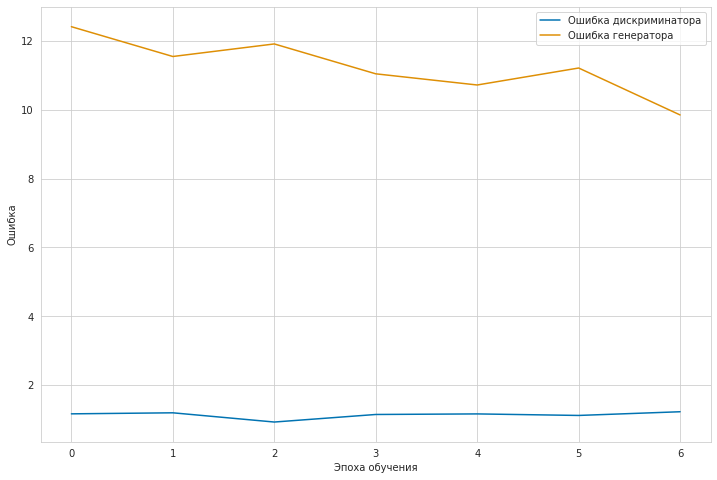

	...epoch 198/300	batch 0/7	D loss: 1.411759	G loss: 12.118206
	...epoch 198/300	batch 1/7	D loss: 1.207288	G loss: 11.255809
	...epoch 198/300	batch 2/7	D loss: 1.210428	G loss: 10.716706
	...epoch 198/300	batch 3/7	D loss: 1.212913	G loss: 11.097363
	...epoch 198/300	batch 4/7	D loss: 1.123848	G loss: 10.572959
	...epoch 198/300	batch 5/7	D loss: 1.090740	G loss: 10.480651
	...epoch 198/300	batch 6/7	D loss: 1.144399	G loss: 11.037874


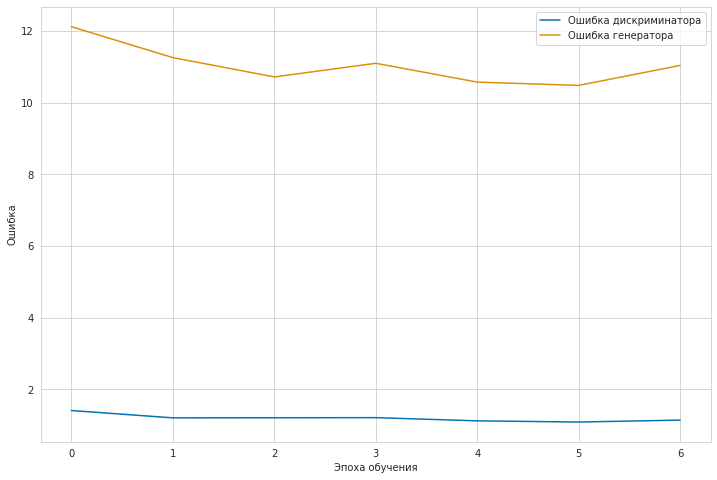

	...epoch 199/300	batch 0/7	D loss: 0.831249	G loss: 11.354901
	...epoch 199/300	batch 1/7	D loss: 1.026522	G loss: 10.995571
	...epoch 199/300	batch 2/7	D loss: 0.995888	G loss: 12.199859
	...epoch 199/300	batch 3/7	D loss: 1.109237	G loss: 11.646177
	...epoch 199/300	batch 4/7	D loss: 1.079320	G loss: 11.550956
	...epoch 199/300	batch 5/7	D loss: 1.213524	G loss: 10.828612
	...epoch 199/300	batch 6/7	D loss: 0.984632	G loss: 11.831788


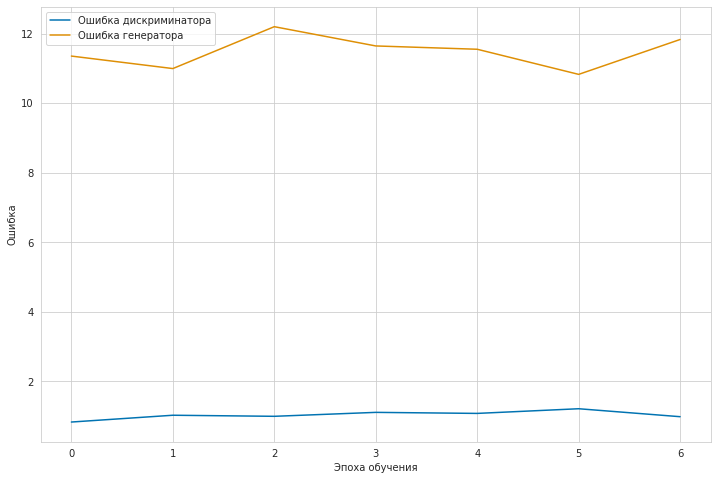

	...epoch 200/300	batch 0/7	D loss: 1.175426	G loss: 12.193431
	...epoch 200/300	batch 1/7	D loss: 1.087287	G loss: 11.868526
	...epoch 200/300	batch 2/7	D loss: 1.216057	G loss: 10.619308
	...epoch 200/300	batch 3/7	D loss: 1.177513	G loss: 11.004322
	...epoch 200/300	batch 4/7	D loss: 1.032703	G loss: 10.823492
	...epoch 200/300	batch 5/7	D loss: 0.947859	G loss: 11.524917
	...epoch 200/300	batch 6/7	D loss: 0.956512	G loss: 12.230756


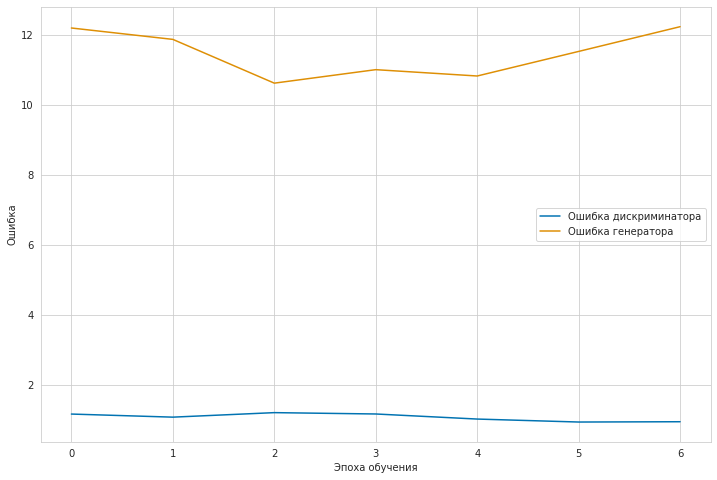

	...epoch 201/300	batch 0/7	D loss: 1.095819	G loss: 11.797387
	...epoch 201/300	batch 1/7	D loss: 1.119366	G loss: 11.626555
	...epoch 201/300	batch 2/7	D loss: 1.112267	G loss: 11.563554
	...epoch 201/300	batch 3/7	D loss: 1.033094	G loss: 10.781265
	...epoch 201/300	batch 4/7	D loss: 1.087344	G loss: 12.027450
	...epoch 201/300	batch 5/7	D loss: 1.450120	G loss: 11.267405
	...epoch 201/300	batch 6/7	D loss: 1.054602	G loss: 11.472634


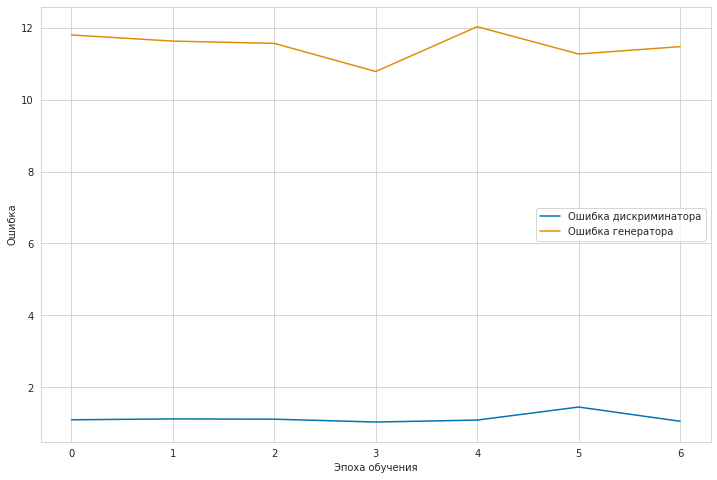

	...epoch 202/300	batch 0/7	D loss: 1.178774	G loss: 11.708712
	...epoch 202/300	batch 1/7	D loss: 1.203189	G loss: 10.910367
	...epoch 202/300	batch 2/7	D loss: 1.164516	G loss: 11.029689
	...epoch 202/300	batch 3/7	D loss: 1.040617	G loss: 10.703891
	...epoch 202/300	batch 4/7	D loss: 1.152761	G loss: 11.992158
	...epoch 202/300	batch 5/7	D loss: 1.213630	G loss: 11.419744
	...epoch 202/300	batch 6/7	D loss: 1.120315	G loss: 10.936117


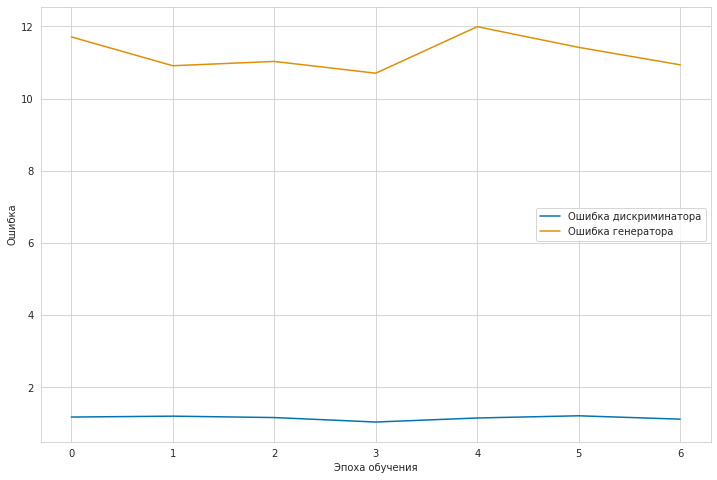

	...epoch 203/300	batch 0/7	D loss: 1.322350	G loss: 12.659719
	...epoch 203/300	batch 1/7	D loss: 1.140002	G loss: 11.411615
	...epoch 203/300	batch 2/7	D loss: 1.137676	G loss: 10.543326
	...epoch 203/300	batch 3/7	D loss: 1.007318	G loss: 11.642597
	...epoch 203/300	batch 4/7	D loss: 1.166124	G loss: 11.012599
	...epoch 203/300	batch 5/7	D loss: 1.098255	G loss: 11.078548
	...epoch 203/300	batch 6/7	D loss: 1.251421	G loss: 13.990942


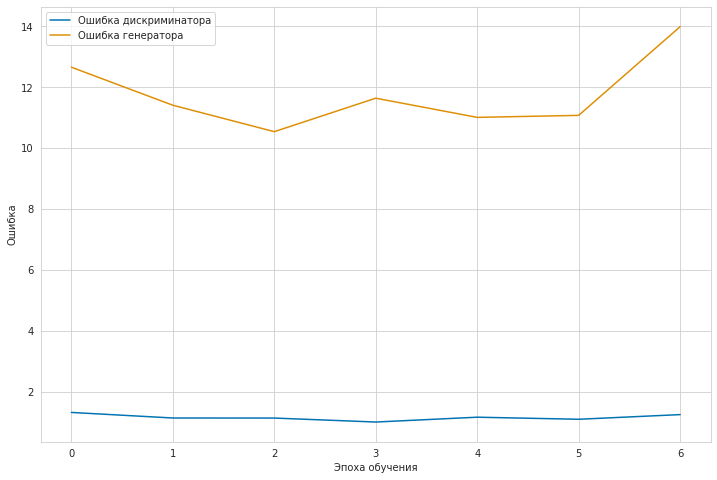

	...epoch 204/300	batch 0/7	D loss: 1.541479	G loss: 11.358402
	...epoch 204/300	batch 1/7	D loss: 1.058465	G loss: 11.493179
	...epoch 204/300	batch 2/7	D loss: 1.190922	G loss: 11.225809
	...epoch 204/300	batch 3/7	D loss: 1.095821	G loss: 10.918088
	...epoch 204/300	batch 4/7	D loss: 1.055828	G loss: 11.002998
	...epoch 204/300	batch 5/7	D loss: 1.043627	G loss: 10.979016
	...epoch 204/300	batch 6/7	D loss: 0.977572	G loss: 10.505919


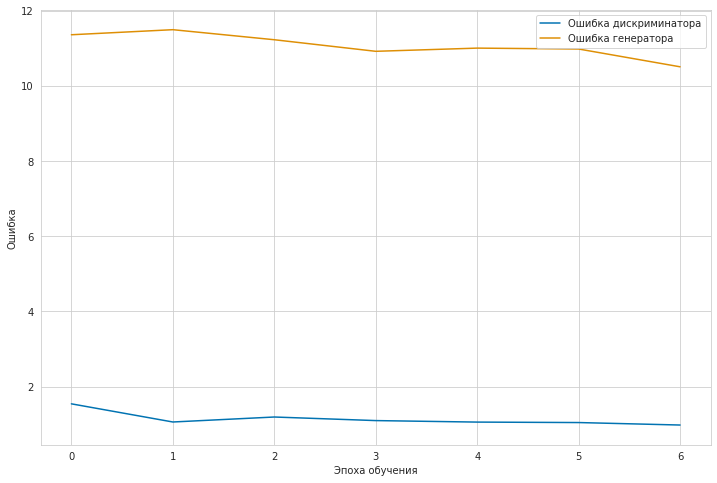

	...epoch 205/300	batch 0/7	D loss: 1.158939	G loss: 11.867658
	...epoch 205/300	batch 1/7	D loss: 1.221397	G loss: 11.373856
	...epoch 205/300	batch 2/7	D loss: 1.101329	G loss: 10.976959
	...epoch 205/300	batch 3/7	D loss: 1.302375	G loss: 11.798835
	...epoch 205/300	batch 4/7	D loss: 1.186659	G loss: 11.191002
	...epoch 205/300	batch 5/7	D loss: 1.109871	G loss: 10.278352
	...epoch 205/300	batch 6/7	D loss: 1.406330	G loss: 11.472089


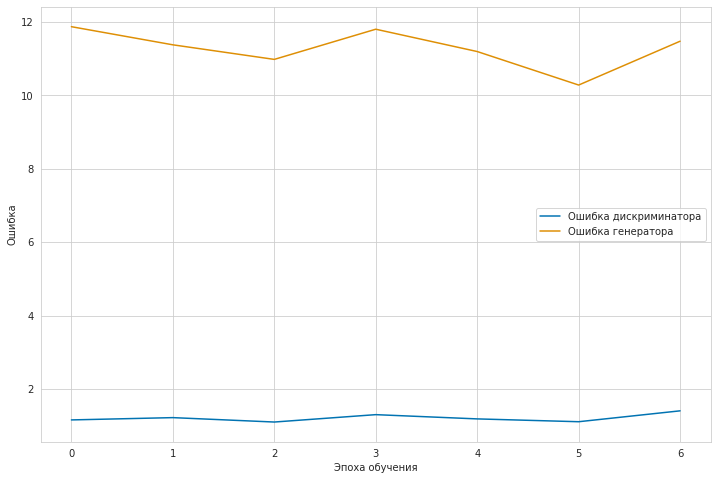

	...epoch 206/300	batch 0/7	D loss: 1.152848	G loss: 11.829009
	...epoch 206/300	batch 1/7	D loss: 1.029493	G loss: 10.627772
	...epoch 206/300	batch 2/7	D loss: 1.059736	G loss: 11.283689
	...epoch 206/300	batch 3/7	D loss: 1.129487	G loss: 11.013906
	...epoch 206/300	batch 4/7	D loss: 1.039688	G loss: 10.591272
	...epoch 206/300	batch 5/7	D loss: 1.253928	G loss: 11.856046
	...epoch 206/300	batch 6/7	D loss: 1.364403	G loss: 11.077333


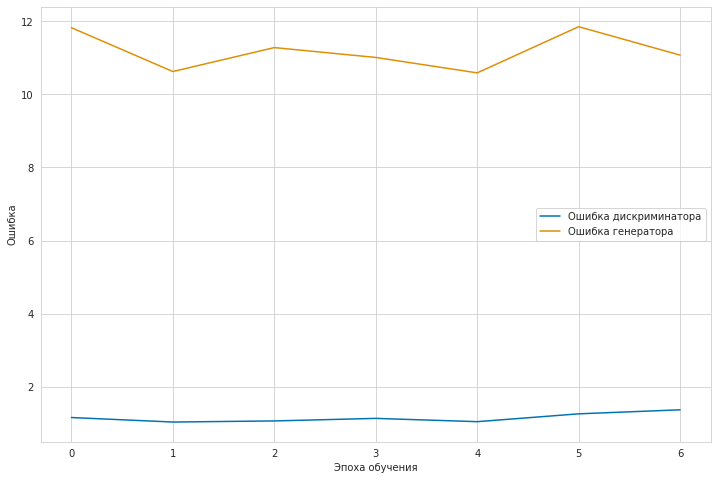

	...epoch 207/300	batch 0/7	D loss: 1.082006	G loss: 10.639764
	...epoch 207/300	batch 1/7	D loss: 1.154890	G loss: 11.175335
	...epoch 207/300	batch 2/7	D loss: 1.061683	G loss: 11.401210
	...epoch 207/300	batch 3/7	D loss: 1.040075	G loss: 11.500256
	...epoch 207/300	batch 4/7	D loss: 0.999076	G loss: 11.146365
	...epoch 207/300	batch 5/7	D loss: 1.160858	G loss: 11.105397
	...epoch 207/300	batch 6/7	D loss: 0.927200	G loss: 12.066487


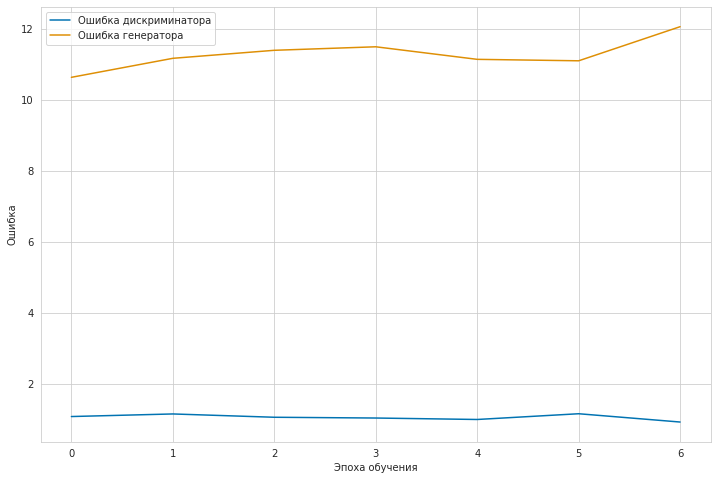

	...epoch 208/300	batch 0/7	D loss: 1.313030	G loss: 11.413973
	...epoch 208/300	batch 1/7	D loss: 1.140799	G loss: 11.113603
	...epoch 208/300	batch 2/7	D loss: 1.083692	G loss: 11.246431
	...epoch 208/300	batch 3/7	D loss: 0.976076	G loss: 11.370919
	...epoch 208/300	batch 4/7	D loss: 1.120138	G loss: 10.728056
	...epoch 208/300	batch 5/7	D loss: 1.198073	G loss: 11.611301
	...epoch 208/300	batch 6/7	D loss: 1.413279	G loss: 10.820142


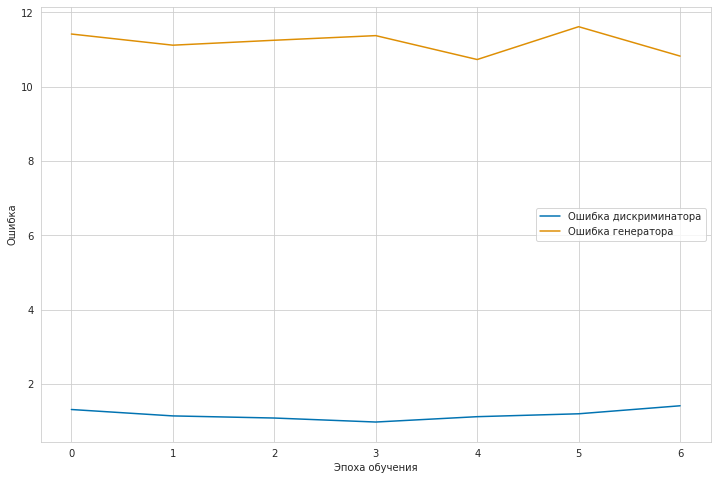

	...epoch 209/300	batch 0/7	D loss: 1.128984	G loss: 11.697858
	...epoch 209/300	batch 1/7	D loss: 1.112693	G loss: 11.947333
	...epoch 209/300	batch 2/7	D loss: 1.139712	G loss: 11.200139
	...epoch 209/300	batch 3/7	D loss: 1.170405	G loss: 11.622013
	...epoch 209/300	batch 4/7	D loss: 1.087642	G loss: 10.779899
	...epoch 209/300	batch 5/7	D loss: 1.103304	G loss: 11.063489
	...epoch 209/300	batch 6/7	D loss: 1.482026	G loss: 11.227297


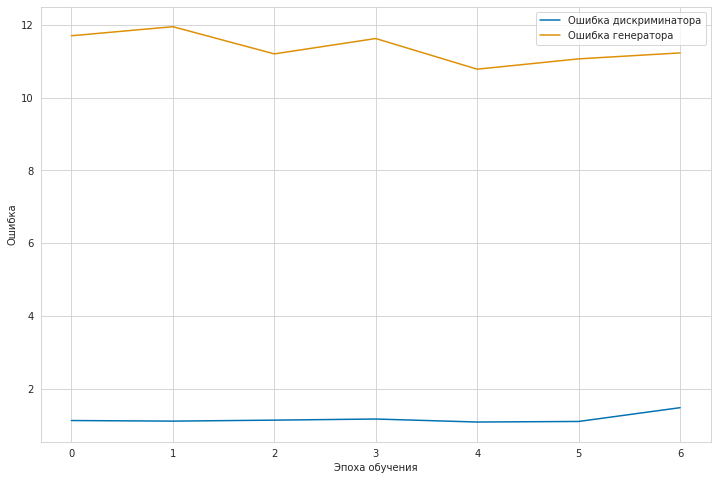

	...epoch 210/300	batch 0/7	D loss: 1.347763	G loss: 13.118142
	...epoch 210/300	batch 1/7	D loss: 1.154549	G loss: 11.867595
	...epoch 210/300	batch 2/7	D loss: 1.292072	G loss: 11.539144
	...epoch 210/300	batch 3/7	D loss: 1.260817	G loss: 11.271334
	...epoch 210/300	batch 4/7	D loss: 1.159962	G loss: 11.108072
	...epoch 210/300	batch 5/7	D loss: 1.005143	G loss: 11.245430
	...epoch 210/300	batch 6/7	D loss: 1.171774	G loss: 11.693750


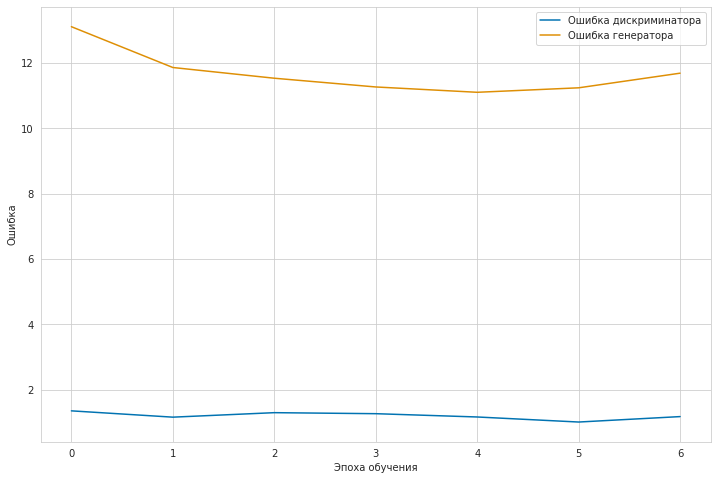

	...epoch 211/300	batch 0/7	D loss: 1.295604	G loss: 11.169964
	...epoch 211/300	batch 1/7	D loss: 0.894534	G loss: 11.377065
	...epoch 211/300	batch 2/7	D loss: 1.188008	G loss: 11.131567
	...epoch 211/300	batch 3/7	D loss: 1.078898	G loss: 11.029036
	...epoch 211/300	batch 4/7	D loss: 1.050387	G loss: 10.701530
	...epoch 211/300	batch 5/7	D loss: 1.024020	G loss: 11.351123
	...epoch 211/300	batch 6/7	D loss: 1.064431	G loss: 13.020238


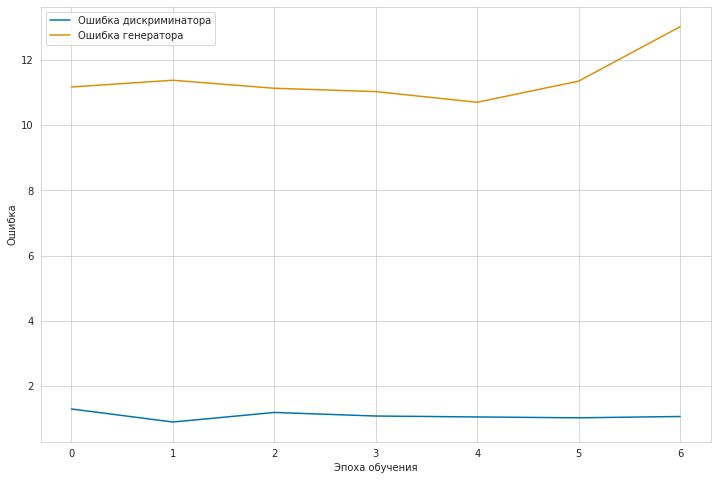

	...epoch 212/300	batch 0/7	D loss: 1.497254	G loss: 11.403966
	...epoch 212/300	batch 1/7	D loss: 1.070319	G loss: 11.124187
	...epoch 212/300	batch 2/7	D loss: 0.991439	G loss: 11.926979
	...epoch 212/300	batch 3/7	D loss: 1.041302	G loss: 12.052605
	...epoch 212/300	batch 4/7	D loss: 1.083983	G loss: 11.034638
	...epoch 212/300	batch 5/7	D loss: 1.110069	G loss: 10.954750
	...epoch 212/300	batch 6/7	D loss: 1.073002	G loss: 11.144245


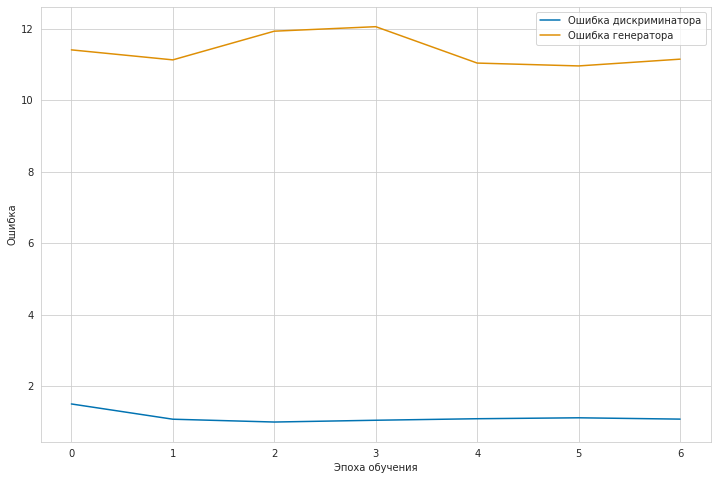

	...epoch 213/300	batch 0/7	D loss: 0.996048	G loss: 12.461650
	...epoch 213/300	batch 1/7	D loss: 1.041624	G loss: 11.771732
	...epoch 213/300	batch 2/7	D loss: 1.015896	G loss: 10.888404
	...epoch 213/300	batch 3/7	D loss: 1.196136	G loss: 12.055555
	...epoch 213/300	batch 4/7	D loss: 1.305811	G loss: 11.133710
	...epoch 213/300	batch 5/7	D loss: 1.020068	G loss: 10.949456
	...epoch 213/300	batch 6/7	D loss: 1.466281	G loss: 13.058116


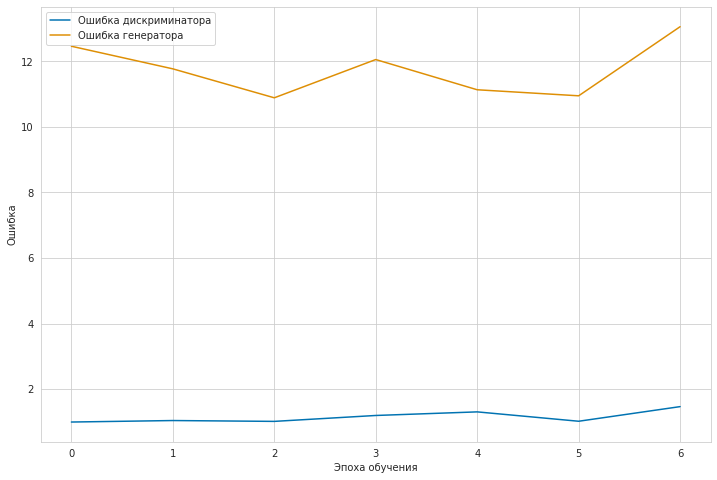

	...epoch 214/300	batch 0/7	D loss: 1.304775	G loss: 11.497124
	...epoch 214/300	batch 1/7	D loss: 1.191376	G loss: 11.032053
	...epoch 214/300	batch 2/7	D loss: 0.997838	G loss: 11.942715
	...epoch 214/300	batch 3/7	D loss: 1.048364	G loss: 11.509941
	...epoch 214/300	batch 4/7	D loss: 1.216073	G loss: 11.411360
	...epoch 214/300	batch 5/7	D loss: 1.032733	G loss: 11.155635
	...epoch 214/300	batch 6/7	D loss: 1.138610	G loss: 11.421841


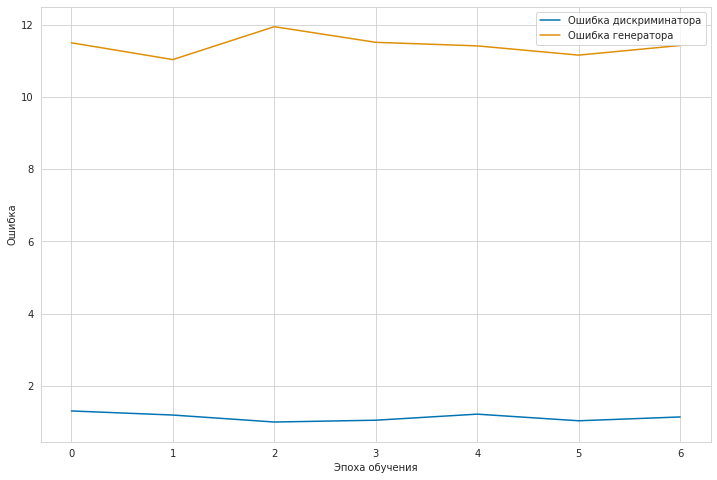

	...epoch 215/300	batch 0/7	D loss: 1.086415	G loss: 11.459518
	...epoch 215/300	batch 1/7	D loss: 1.054879	G loss: 11.503589
	...epoch 215/300	batch 2/7	D loss: 1.076115	G loss: 11.502492
	...epoch 215/300	batch 3/7	D loss: 0.941482	G loss: 10.988356
	...epoch 215/300	batch 4/7	D loss: 1.086749	G loss: 11.507564
	...epoch 215/300	batch 5/7	D loss: 1.143324	G loss: 10.845755
	...epoch 215/300	batch 6/7	D loss: 1.175466	G loss: 11.116086


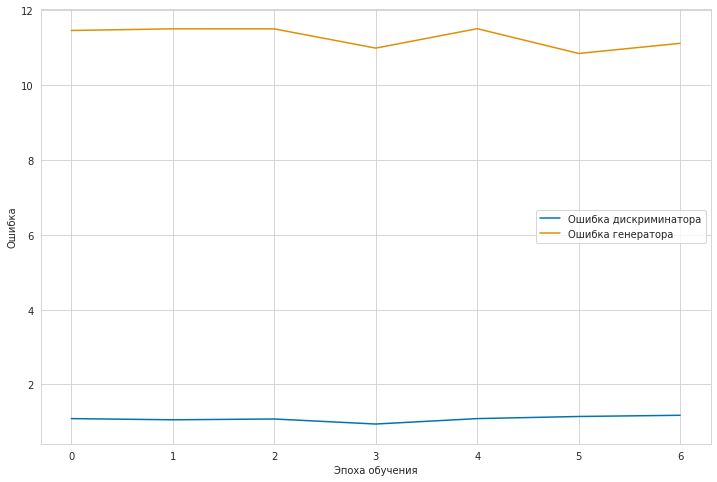

	...epoch 216/300	batch 0/7	D loss: 1.169201	G loss: 12.017462
	...epoch 216/300	batch 1/7	D loss: 1.304649	G loss: 11.076342
	...epoch 216/300	batch 2/7	D loss: 1.056950	G loss: 10.965785
	...epoch 216/300	batch 3/7	D loss: 0.999096	G loss: 11.449124
	...epoch 216/300	batch 4/7	D loss: 0.984000	G loss: 10.926417
	...epoch 216/300	batch 5/7	D loss: 1.129121	G loss: 11.306954
	...epoch 216/300	batch 6/7	D loss: 1.304851	G loss: 10.449536


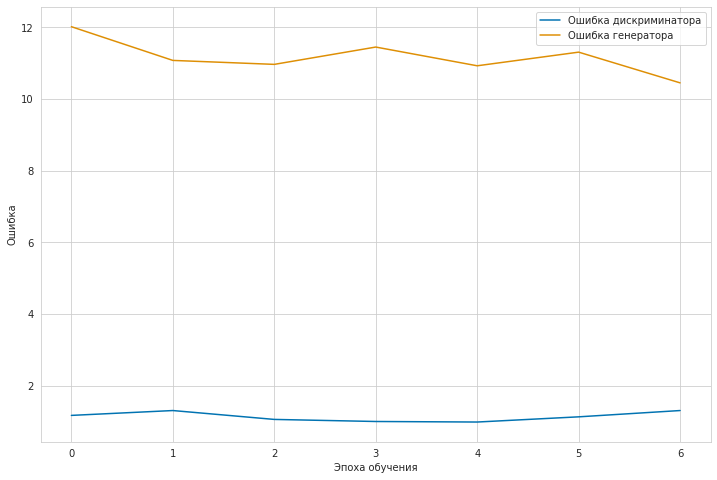

	...epoch 217/300	batch 0/7	D loss: 1.224846	G loss: 13.165023
	...epoch 217/300	batch 1/7	D loss: 1.056417	G loss: 11.602137
	...epoch 217/300	batch 2/7	D loss: 1.091028	G loss: 12.252124
	...epoch 217/300	batch 3/7	D loss: 1.109117	G loss: 11.878138
	...epoch 217/300	batch 4/7	D loss: 1.122978	G loss: 11.287466
	...epoch 217/300	batch 5/7	D loss: 1.008731	G loss: 11.469568
	...epoch 217/300	batch 6/7	D loss: 1.468799	G loss: 10.508437


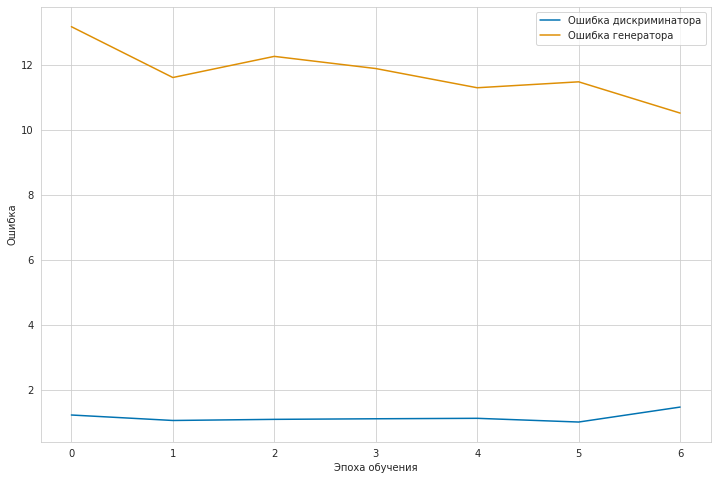

	...epoch 218/300	batch 0/7	D loss: 1.549759	G loss: 12.730321
	...epoch 218/300	batch 1/7	D loss: 1.620068	G loss: 10.804801
	...epoch 218/300	batch 2/7	D loss: 1.339435	G loss: 11.605964
	...epoch 218/300	batch 3/7	D loss: 1.396272	G loss: 10.424528
	...epoch 218/300	batch 4/7	D loss: 1.062196	G loss: 10.291119
	...epoch 218/300	batch 5/7	D loss: 1.232677	G loss: 11.158286
	...epoch 218/300	batch 6/7	D loss: 1.247729	G loss: 11.555649


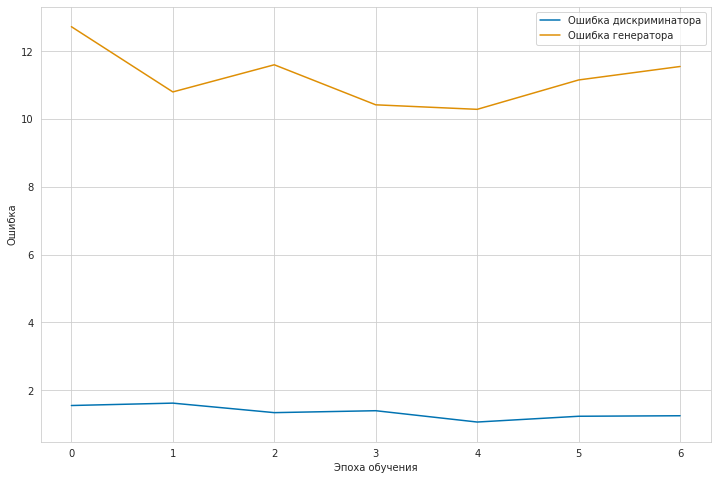

	...epoch 219/300	batch 0/7	D loss: 1.096196	G loss: 11.032209
	...epoch 219/300	batch 1/7	D loss: 1.014281	G loss: 11.499412
	...epoch 219/300	batch 2/7	D loss: 0.956680	G loss: 11.550221
	...epoch 219/300	batch 3/7	D loss: 1.114816	G loss: 10.601943
	...epoch 219/300	batch 4/7	D loss: 1.032478	G loss: 10.740287
	...epoch 219/300	batch 5/7	D loss: 1.037131	G loss: 11.528279
	...epoch 219/300	batch 6/7	D loss: 1.091095	G loss: 11.865156


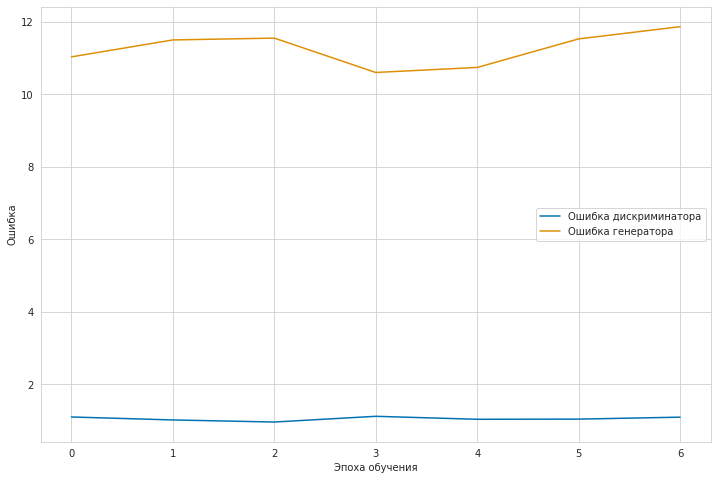

In [ ]:
from torchvision.utils import save_image


batch_size = 64

transform = transforms.Compose([
                  transforms.ToTensor(),
                 transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

path_to_data = '/content/drive/MyDrive/datasets/facades/'

train_data = loadData(path_to_data, 'train', transform)

train_data_loader = torch.utils.data.DataLoader(dataset=train_data,
                                                batch_size=batch_size,
                                                shuffle=True)

test_data = loadData(path_to_data, 'test', transform)
test_data_loader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=batch_size,
                                               shuffle=False)


G = Generator(3, 3)
D = Discriminator(6)
G.cuda()
D.cuda()

BCE_loss = torch.nn.BCELoss().cuda()
L1_loss = torch.nn.L1Loss().cuda()

lr, beta1, beta2 = 0.0002, 0.5, 0.999
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

batches_done = 0

num_epochs = 300

D_losses = []
G_losses = []

for epoch in range(num_epochs):


    for i, (input, target) in enumerate(train_data_loader):

        x_ = Variable(input.cuda())
        y_ = Variable(target.cuda())

        # подаем реальные данные
        D_real = D(x_, y_).squeeze()
        real_ = Variable(torch.ones(D_real.size()).cuda())
        D_real_loss = BCE_loss(D_real, real_)

        # подаем сгенерированные данные
        gen_image = G(x_)
        D_fake = D(x_, gen_image).squeeze()
        fake_ = Variable(torch.zeros(D_fake.size()).cuda())
        D_fake_loss = BCE_loss(D_fake, fake_)

        # пропагиируем дискриминатор
        D_loss = D_real_loss + D_fake_loss
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # тренеруем генератор
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        G_fake_loss = BCE_loss(D_fake_decision, real_)

        l1_loss = 100 * L1_loss(gen_image, y_)

        # пропагиируем генератор
        G_loss = G_fake_loss + l1_loss
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        D_losses.append(D_loss.data.item())
        G_losses.append(G_loss.data.item())
        print("\t...epoch %d/%d\tbatch %d/%d\tD loss: %.6f\tG loss: %.6f" % \
                      (epoch, num_epochs, i, len(train_data_loader),  D_loss.data.item(), G_loss.data.item()))

        batches_done += 1

        if batches_done % 100 == 0:
                gen_imgs = G(x_)
                gen_imgs = gen_image.cpu().data
                save_image(gen_imgs.data[:5], "%s/%05d.png" % (path_to_data + "/out/", batches_done), nrow=5, normalize=True)

    plot_losses(D_losses,G_losses )





In [ ]:
for i, (input, target) in enumerate(test_data_loader):
          gen_imgs = G(x_)
          gen_imgs = gen_image.cpu().data
          save_image(gen_imgs.data[:], "%s/%05d.png" % (path_to_data + "/result/", batches_done), nrow=5, normalize=True)


## CycleGAN

In [ ]:

from torchvision.utils import save_image


batch_size = 64

transform = transforms.Compose([
                  transforms.ToTensor(),
                 transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

path_to_data = '/content/drive/MyDrive/datasets/facades/'

train_data = loadData(path_to_data, 'train', transform)

train_data_loader = torch.utils.data.DataLoader(dataset=train_data,
                                                batch_size=batch_size,
                                                shuffle=True)

test_data = loadData(path_to_data, 'test', transform)
test_data_loader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=batch_size,
                                               shuffle=False)


GA = Generator(3, 3)
DA = Discriminator(6)
GB = Generator(3, 3)
DB = Discriminator(6)

GA.cuda()
DA.cuda()
GB.cuda()
DB.cuda()

cycle_loss = torch.nn.L1Loss().to(device)
identity_loss = torch.nn.L1Loss().to(device)
adversarial_loss = torch.nn.MSELoss().to(device)


g_losses = []
d_losses = []

identity_losses = []
gan_losses = []
cycle_losses = []

BCE_loss = torch.nn.BCELoss().cuda()
L1_loss = torch.nn.L1Loss().cuda()

lr, beta1, beta2 = 0.0002, 0.5, 0.999
G1_optimizer = torch.optim.Adam(G1.parameters(), lr=lr, betas=(beta1, beta2))
D1_optimizer = torch.optim.Adam(D1.parameters(), lr=lr, betas=(beta1, beta2))
G2_optimizer = torch.optim.Adam(G2.parameters(), lr=lr, betas=(beta1, beta2))
D2_optimizer = torch.optim.Adam(D2.parameters(), lr=lr, betas=(beta1, beta2))

batches_done = 0

num_epochs = 300

D_losses = []
G_losses = []

for epoch in range(num_epochs):


    for i, (input, target) in enumerate(train_data_loader):

        inputA = input[0:len(input)//2]
        inputB = input[len(input)//2:]
        
        targetA = input[0:len(target)//2]
        targetB = input[len(target)//2:]

        xA_ = Variable(inputA.cuda())
        yA_ = Variable(targetA.cuda())
        xB_ = Variable(inputB.cuda())
        yB_ = Variable(targetB.cuda())


        # conversion loss
        img_A = GA(xA_)
        loss_identity_A = identity_loss(img_A, y_A) * 5.0
        img_B = GB(xB_)
        loss_identity_B = identity_loss(img_B, y_B) * 5.0

        # D loss
        fake_A = GA(xB_)
        fake_output_A = DA(fake_A)
        loss_GAN_B2A = adversarial_loss(fake_output_A, real_label)

        fake_B = GB(xA_)
        fake_output_B = netD_B(fake_B)
        loss_GAN_A2B = adversarial_loss(fake_output_B, real_label)



        D_real = D(x_, y_).squeeze()
        real_ = Variable(torch.ones(D_real.size()).cuda())
        D_real_loss = BCE_loss(D_real, real_)

        # подаем сгенерированные данные
        gen_image = G(x_)
        D_fake = D(x_, gen_image).squeeze()
        fake_ = Variable(torch.zeros(D_fake.size()).cuda())
        D_fake_loss = BCE_loss(D_fake, fake_)

        # пропагиируем дискриминатор
        D_loss = D_real_loss + D_fake_loss
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # тренеруем генератор
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        G_fake_loss = BCE_loss(D_fake_decision, real_)

        l1_loss = 100 * L1_loss(gen_image, y_)

        # пропагиируем D2
        D2_optimizer.zero_grad()
        real_output_B = DB(yB_)
        errD_real_B = adversarial_loss(real_output_B, real_label)

        fake_image_B = fake_B_buffer.push_and_pop(fake_image_B)
        fake_output_B = netD_B(fake_image_B.detach())
        errD_fake_B = adversarial_loss(fake_output_B, fake_label)

        errD2 = (errD_real_B + errD_fake_B) 
        errD2.backward()
        D2_optimizer.step()




        D_losses.append(D_loss.data.item())
        G_losses.append(G_loss.data.item())
        print("\t...epoch %d/%d\tbatch %d/%d\tD loss: %.6f\tG loss: %.6f" % \
                      (epoch, num_epochs, i, len(train_data_loader),  D_loss.data.item(), G_loss.data.item()))

        batches_done += 1

        if batches_done % 100 == 0:
                gen_imgs = G(x_)
                gen_imgs = gen_image.cpu().data
                save_image(gen_imgs.data[:5], "%s/%05d.png" % (path_to_data + "/out/", batches_done), nrow=5, normalize=True)

    plot_losses(D_losses,G_losses )
